# Project goal

Here we have the goals on the covid-19 worldwide analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths and confirmed cases);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a country);</li>
</ul>


Here we have the goals on the covid-19 Italy analysis.
The goal list is the following:
<ul>
<li>visualization and analysis of the main indicators about the severity of the disease (confirmed deaths, confirmed cases, intensive care people, hospitalized people);</li>
<li>identify if there is a correlation about how the disease is spread in a country and features like population density;</li>
<li>identify if it is possible to predict when the emergency status is going to an end in the most impacted countries and countermeasures put in place (in example the lockdown of a province);</li>
</ul>

# Init process: import libraries, load datasets and evaluate data for next phases

Import ncessary libraries.

In [3]:
import pandas as pd
from pandas import DataFrame
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
import numpy as np
import copy
import os
import math
from os import listdir
from datetime import date,timedelta

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.cluster import KMeans

from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.stats.outliers_influence as st_inf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import decomposition, datasets

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
import warnings
%matplotlib inline
%run Utilities.ipynb
warnings.filterwarnings("ignore")


## World 


Load dataset about total deaths, new deaths, total cases and new cases.

In [4]:
#load full dataset of coronavirus from internet
df_all_data__ = pd.read_csv("https://covid.ourworldindata.org/data/ecdc/full_data.csv")
#rename columns with more meaningful name
df_all_data__.rename(columns={"location": "Country","date":"Date", "new_cases":"New cases",
                            "new_deaths":"New deaths","total_cases":"Total cases", 
                            "total_deaths":"Total deaths"}, inplace = True)
df_all_data__.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths
18550,2020-05-17,Zimbabwe,2,0,44,4
18551,2020-05-18,Zimbabwe,2,0,46,4
18552,2020-05-19,Zimbabwe,0,0,46,4
18553,2020-05-20,Zimbabwe,0,0,46,4
18554,2020-05-21,Zimbabwe,2,0,48,4


Load population dataset. The dataset is updated with 2020 data. 
It has been downloaded from:
https://www.kaggle.com/tanuprabhu/population-by-country-2020.

It is currently saved locally.
The dataset contains for each country the number of inhabitants. This dataset is used later to plot covid-19 deaths and cases basing on number of inhabitants.

In [5]:
#load population dataset keeping only the necessary columns 
#(countries and number of inhabitants) renaiming them
df_population = pd.read_csv("../COVID19_analysis/dataset/population_by_country_2020.csv")
df_population = df_population[['Country (or dependency)','Population (2020)']]
df_population.drop_duplicates(inplace = True)
df_population.rename(columns={"Country (or dependency)": "Country",
                            "Population (2020)":"Population"}, inplace = True)
df_population.head()

,Country,Population
0,China,1439323776
1,India,1380004385
2,United States,331002651
3,Indonesia,273523615
4,Pakistan,220892340


Load lockdown dataset. The dataset has been downloaded from:
https://www.kaggle.com/jcyzag/covid19-lockdown-dates-by-country#countryLockdowndates.csv.

It is currently saved locally.
It contains the following columns:
<ul>
<li>country</li>
<li>province of the country</li>
<li>date in which the lockdown has been put in place</li>
<li>type of lockdown (full, partial or none)</li>
<li>reference (source of the data).</li>
</ul>

In [7]:
#load lockdown dataset
df_lockdown = pd.read_csv("../COVID19_analysis/dataset/countryLockdowndates.csv")

#rename column relative to country
df_lockdown.rename(columns={"Country/Region": "Country","Date":"Beginning Date"}, inplace = True)
#convert string date format from 'dd/mm/yyyy' to 'yyyy-mm-dd'
df_lockdown['Beginning Date'] = pd.to_datetime(df_lockdown['Beginning Date'])
#rename country value from 'US' to 'United States' where needed
df_lockdown['Country'] = df_lockdown['Country'].apply(lambda x : 'United States' if x == 'US' else x)
#delete 'Reference column'
df_lockdown.drop('Reference', axis = 1, inplace = True)
#if value in 'Province' column is not present, 
#replace it with value in 'Country' column
df_lockdown.Province.fillna(df_lockdown.Country, inplace = True)
#keep only the country where the value in the Country column is equal 
#to the value in the Province column. In this way, it eliminates the
#rows reguarding colonies
df_lockdown = df_lockdown[df_lockdown.Province == df_lockdown.Country]
#drop the Province column because it is not necessary
df_lockdown.drop('Province', axis = 1, inplace = True)
df_lockdown.head()

,Country,Beginning Date,Type
0,Afghanistan,2020-03-24,Full
1,Albania,2020-03-08,Full
2,Algeria,2020-03-24,Full
3,Andorra,2020-03-16,Full
4,Angola,2020-03-24,Full


Load population density dataset. The dataset is downloaded from:
https://www.kaggle.com/fernandol/countries-of-the-world#countries%20of%20the%20world.csv

In [9]:
#load dataset
pd.set_option('mode.chained_assignment', None)
df_population_density_ = pd.read_csv("../COVID19_analysis/dataset/population_density.csv")
df_population_density = df_population_density_[['Country','Pop. Density (per sq. mi.)']]
df_population_density.rename(columns = {'Pop. Density (per sq. mi.)': 'Population density'}, inplace = True)
#trim country value because original dataset has a space at the end
df_population_density['Country'] = df_population_density['Country'].apply(lambda x : x.strip())
df_population_density.head()

,Country,Population density
0,Afghanistan,48.0
1,Albania,124.6
2,Algeria,13.8
3,American Samoa,290.4
4,Andorra,152.1


Merge coronavirus dataset and population dataset.

In [10]:
df_all_data_ =df_all_data__.copy()
df_all_data_ = pd.merge (left = df_all_data_, right = df_population, on = 'Country')
df_all_data_ = pd.merge (left = df_all_data_, right = df_population_density, on = 'Country')
df_all_data_['Date'] = pd.to_datetime(df_all_data_['Date'])
df_all_data_.head()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0


Evaluate number of cases and deaths per million of inhabitants and store the information in new columns of the full dataset.

In [11]:
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New cases',
                                            'New cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total cases',
                                            'Total cases per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'New deaths',
                                            'New deaths per million of inhabitants')
df_all_data_ = evaluateRatePerNumberOfMillion(df_all_data_, 'Total deaths',
                                            'Total deaths per million of inhabitants')
df_all_data_.tail()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants
15960,2020-05-17,Zimbabwe,2,0,44,4,14862924,31.3,0.134563,2.960387,0.0,0.269126
15961,2020-05-18,Zimbabwe,2,0,46,4,14862924,31.3,0.134563,3.094950,0.0,0.269126
15962,2020-05-19,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126
15963,2020-05-20,Zimbabwe,0,0,46,4,14862924,31.3,0.000000,3.094950,0.0,0.269126
15964,2020-05-21,Zimbabwe,2,0,48,4,14862924,31.3,0.134563,3.229513,0.0,0.269126


Add lockdown information in the full dataset. For each row, create a new column where if in the country for that date was not present the lockdown, the value is set to 0, if the lockdown is partial set a value of 1, if the lockdown is full, set the value to 2. 

In [12]:
#make a copy of the full dataset
#merge lockdown dataset with full dataset
df_all_data = df_all_data_.copy()
df_all_data = df_all_data.merge(df_lockdown, on='Country', how='left')

#create a new column setting an initial default value of -1.
#This value has no meaning. Its only a "jolly" value that evidences
#that the value hano not been set yet
df_all_data['Lockdown state'] = -1

#set a correct value for each row in the full dataset that depends
#on the lockdown type in that particula date for each country
for i in range(len(df_all_data)):
    if(df_all_data.iloc[i]['Type'] == 'None'):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    elif(df_all_data.iloc[i]['Date'] < df_all_data.iloc[i]['Beginning Date']):
        df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 0
    else:
        if(df_all_data.iloc[i]['Type'] == 'Full'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 2
        elif(df_all_data.iloc[i]['Type'] == 'Partial'):
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = 1
        else:
            df_all_data.iloc[i, df_all_data.columns.get_loc('Lockdown state')] = -2

#drop Type column because it is not usefull now
del df_all_data['Type']

df_all_data.head()

,Date,Country,New cases,New deaths,Total cases,Total deaths,Population,Population density,New cases per million of inhabitants,Total cases per million of inhabitants,New deaths per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state
0,2019-12-31,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
1,2020-01-01,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
2,2020-01-02,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
3,2020-01-03,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0
4,2020-01-04,Afghanistan,0,0,0,0,38928346,48.0,0.0,0.0,0.0,0.0,2020-03-24,0


## Italy


The datasets used in this italian part of the project are the following:
https://github.com/pcm-dpc/COVID-19

This dataset was chosen for two reasons:
<ul>
<li>It's really complete and up to date. Everyday a new entry is added, for provinces and regions.</li>
<li>There are information about everything, like number of tampons, deaths and even hospitilized people.</li>
</ul>   
The downside is that every day is a different file, so in the project every file is selected to generate a new dataset with everything inside and completely automated, taking every entry until the day before.

The other dataset is the following:
https://worldpopulationreview.com/countries/italy-population/cities/

This dataset contains up to date information about italian city population.
There are some missing entries about provinces, so it was necessary to add them manually in the dataset.
It is also badly formatted, resulting in a bad pandas scheme.
The dataset used is a manually modified version of this one.

Another useful dataset would be the density of the population by city, but was not available, so it has been created manually, using wikipedia information.
Since there are 107 provinces in Italy, the region population density was taken, because it's probably more significative than doing that for every single city, and it can be done in a reasonable amount of time.

Next code block will take the date of yesterday to make a vectors of dates.

This will be used for automatic updating of the dataset

In [13]:
yesterday = date.today() - timedelta(days=1)

date_list=pd.date_range(start="2020-02-24",end=yesterday) #time period from when the datasets starts until yesterday
str_date=[]
str_date_formatted=[]
#formatting the data to use it as a name of the columns of the new dataset and to use it for the github files
for i in range(len(date_list)):
    str_date.append(str(date_list[i]).replace("-", ""))
    str_date_formatted.append(str_date[i][:-9])

### Provinces


There are many csv files with shared information.
The following procedure is used to merge different datasets into a unique dataset.

Files are taken directly from the website of github. Everytime that new files are available, they are merged to the full dataset.

In [14]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[0]+'.csv'
time_line_dataset = pd.read_csv(url,encoding='latin-1')
del time_line_dataset['totale_casi']

for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province-'+str_date_formatted[i]+'.csv'    
    temp_data=pd.read_csv(url,encoding='latin-1')
    time_line_dataset[str_date_formatted[i]]=temp_data['totale_casi']

Now let's remove empty data and delete the useless information.

NB: Naples has problems with NA, since the program things it's a NaN value. We have to decide how to manage this information in best possible way, but for now we modified it the in NAP.

In [15]:
time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli']

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,note_it,...,20200511,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520
19,2020-02-24T18:00:00,ITA,15,Campania,63,Napoli,NaN,40.839566,14.25085,NaN,...,2536,2541,2549,2551,2563,2568,2571,2572,2576,2581


In [16]:
time_line_dataset.at[time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli'].index[0],'sigla_provincia']='NAP'
time_line_dataset[time_line_dataset['denominazione_provincia'] == 'Napoli']

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,note_it,...,20200511,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520
19,2020-02-24T18:00:00,ITA,15,Campania,63,Napoli,NAP,40.839566,14.25085,NaN,...,2536,2541,2549,2551,2563,2568,2571,2572,2576,2581


Now we remove the useless information, that are columns like 'latitude' or 'longitude' that doesn't provide useful information for our purposes

In [17]:
time_line_dataset=time_line_dataset[time_line_dataset.sigla_provincia.notnull()]
#removing useless/redundant columns
del time_line_dataset['data'] #we already have data columns added in the reworking
del time_line_dataset['stato'] #it's the italian database, we already know
del time_line_dataset['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['codice_provincia'] #it's an indicative value, it doesn't mean anything
del time_line_dataset['lat'] #We don't need this value knowing the city
del time_line_dataset['long'] #We don't need this value knowing the city
del time_line_dataset['sigla_provincia'] #We don't need this value knowing the city
del time_line_dataset['note_it']
del time_line_dataset['note_en']

#saving reworked dataset. TURN THE OPTION ON IF IT IS NECESSARY TO SAVE IT TO EXTERNAL FILE.
#time_line_dataset.to_csv('rielab_dataset_merged.csv') 
time_line_dataset.head()

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200511,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520
0,Abruzzo,Chieti,0,0,0,0,0,0,0,0,...,772,778,778,778,783,802,804,811,811,813
1,Abruzzo,L'Aquila,0,0,0,0,0,0,0,0,...,243,244,244,246,246,246,246,246,246,246
2,Abruzzo,Pescara,0,0,0,0,0,0,0,0,...,1448,1448,1460,1467,1474,1483,1488,1487,1491,1497
3,Abruzzo,Teramo,0,0,0,1,1,2,5,5,...,644,645,645,645,645,647,648,649,649,649
5,Basilicata,Matera,0,0,0,0,0,0,0,0,...,205,206,206,206,206,206,207,207,207,207


### Regions



Create different datasets for each condition (deaths, tampons, etc.) and then plot the data. In this way, it will be easy afterward to analyze them.
First let's load the dataset, that like the provinces one, it's always up to date.
Other than that, we also load the density dataset we builded from scratch using informations on wikipedia about density population

In [19]:
url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[0]+'.csv'
time_line_dataset_regions = pd.read_csv(url,encoding='latin-1')

#adding density information from our dataset
density=pd.read_csv('../COVID19_analysis/dati aggiuntivi/density.csv')
time_line_dataset_regions.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,casi_testati,note_it,note_en
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,0,5,NaN,NaN,NaN
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN
2,2020-02-24T18:00:00,ITA,21,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
3,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,0,1,NaN,NaN,NaN
4,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,0,10,NaN,NaN,NaN


This datasets will be splitted in different datasets, one for each necessary information, like tampons information or new cases information.

First, the useless column are removed.

In [20]:
#removing useless/redundant columns
del time_line_dataset_regions['data'] #we already have data columns added in the reworking
del time_line_dataset_regions['stato'] #it's the italian database, we already know
del time_line_dataset_regions['codice_regione'] #it's an indicative value, it doesn't mean anything
del time_line_dataset_regions['ricoverati_con_sintomi'] #this column will be its own dataset
del time_line_dataset_regions['lat'] #We don't need this value knowing the city
del time_line_dataset_regions['long'] #We don't need this value knowing the city
del time_line_dataset_regions['note_it']
del time_line_dataset_regions['note_en']
del time_line_dataset_regions['casi_testati']
del time_line_dataset_regions['terapia_intensiva'] #this column will be its own dataset
del time_line_dataset_regions['totale_ospedalizzati'] #this column will be its own dataset
del time_line_dataset_regions['isolamento_domiciliare']#this column will be its own dataset
del time_line_dataset_regions['totale_positivi'] #this column will be its own dataset
del time_line_dataset_regions['nuovi_positivi']#this column will be its own dataset
del time_line_dataset_regions['dimessi_guariti']#this column will be its own dataset
del time_line_dataset_regions['variazione_totale_positivi']#this column will be its own dataset
del time_line_dataset_regions['deceduti'] #this column will be its own dataset
del time_line_dataset_regions['totale_casi'] #this column will be its own dataset
del time_line_dataset_regions['tamponi'] #this column will be its own dataset

time_line_dataset_regions.head()

,denominazione_regione
0,Abruzzo
1,Basilicata
2,P.A. Bolzano
3,Calabria
4,Campania


Columns to this tiny dataset depending on which dataset to build are added. The information in each one of this dataset are copied and then starting to add the columns.

In [21]:
#building a dataset for condition
tl_hospitalized_with_symptoms=copy.deepcopy(time_line_dataset_regions)
tl_intensive_teraphy=copy.deepcopy(time_line_dataset_regions)
tl_total_hospitalized=copy.deepcopy(time_line_dataset_regions)
tl_isolation=copy.deepcopy(time_line_dataset_regions)
tl_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_new_actual_positives=copy.deepcopy(time_line_dataset_regions)
tl_recovered=copy.deepcopy(time_line_dataset_regions)
tl_deaths=copy.deepcopy(time_line_dataset_regions)
tl_total=copy.deepcopy(time_line_dataset_regions)
tl_tampons=copy.deepcopy(time_line_dataset_regions)
tl_variance=copy.deepcopy(time_line_dataset_regions)

Every information of the columns will be exctracted from the web site so they will be always up to date, and show an example of how these datasets are.

In [22]:
#uploading every day for each dataset
for i in range(0,len(str_date_formatted)):
    url = 'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-'+str_date_formatted[i]+'.csv'
    
    temp_data=pd.read_csv(url,encoding='latin-1')
    tl_hospitalized_with_symptoms[str_date_formatted[i]]=temp_data['ricoverati_con_sintomi']
    tl_intensive_teraphy[str_date_formatted[i]]=temp_data['terapia_intensiva']
    tl_total_hospitalized[str_date_formatted[i]]=temp_data['totale_ospedalizzati']
    tl_isolation[str_date_formatted[i]]=temp_data['isolamento_domiciliare']
    tl_actual_positives[str_date_formatted[i]]=temp_data['totale_positivi']
    tl_new_actual_positives[str_date_formatted[i]]=temp_data['nuovi_positivi']
    tl_recovered[str_date_formatted[i]]=temp_data['dimessi_guariti']
    tl_deaths[str_date_formatted[i]]=temp_data['deceduti']
    tl_total[str_date_formatted[i]]=temp_data['totale_casi']
    tl_tampons[str_date_formatted[i]]=temp_data['tamponi']
    tl_variance[str_date_formatted[i]]=temp_data['variazione_totale_positivi']
tl_hospitalized_with_symptoms.head()

,denominazione_regione,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,20200303,...,20200511,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520
0,Abruzzo,0,0,0,1,1,2,3,3,5,...,231,222,214,215,205,195,193,191,188,185
1,Basilicata,0,0,0,0,0,0,0,0,0,...,46,47,42,34,33,29,29,29,26,22
2,P.A. Bolzano,0,1,1,1,1,1,1,1,1,...,63,56,56,54,50,48,50,52,46,43
3,Calabria,0,0,0,0,0,0,0,0,0,...,64,65,64,59,56,56,56,53,50,49
4,Campania,0,0,0,2,2,3,4,4,11,...,436,414,402,387,341,351,342,342,330,318


Lastly, a new dataset for the density population is created.

In [23]:
#This one will contain the population density now on
time_line_dataset_regions=time_line_dataset_regions.merge(density, left_on='denominazione_regione', right_on='Region')
del time_line_dataset_regions['Region']

time_line_dataset_regions.head()

,denominazione_regione,Density(ab./Km^2)
0,Abruzzo,120.48
1,Basilicata,55.50
2,Calabria,127.15
3,Campania,422.25
4,Emilia-Romagna,198.62


# Data visualization

## World

Since italy and world have different data to study, the analysis of the respective data have some differences.
Thus, we have specific sections that analyze different things.

### Analysis by country without considering the number of inhabitants

Firstly, it would be interesting to compare the growth about the number of deaths and cases of some countries starting from a specific point, meant as a common starting point, for a better comparison. Next steps are used to estabilish which is the starting point.

In the first step it is necessary to retrieve what the top ten countries for number of deaths are.

In [24]:
#create a copy of the dataset keeping the necessary columns
df_total_deaths = df_all_data[['Country','Total deaths']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths = df_total_deaths.groupby('Country').max()
df_group_total_deaths.sort_values(by = 'Total deaths',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_deaths = df_group_total_deaths.iloc[0:10]
top_10_total_deaths.reset_index(inplace = True)
#print data of all the world deaths
print("World number of deaths:", df_group_total_deaths['Total deaths'].sum(), end ="\n\n")
top_10_total_deaths

World number of deaths: 326821



,Country,Total deaths
0,United States,93439
1,United Kingdom,35704
2,Italy,32330
3,France,28132
4,Spain,27888
5,Brazil,18859
6,Belgium,9150
7,Germany,8147
8,Iran,7183
9,Mexico,6090


Plot the total number of deaths, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

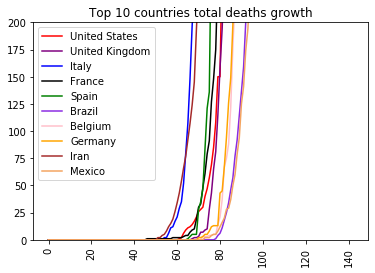

In [25]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth',
                            0, 200)

It is possible to set the starting point to 50 deaths, and this will be the common starting point for comparing the data.

Print data of the top 10 countries for number of deaths and plot the growth starting from the first 50 confirmed deaths.

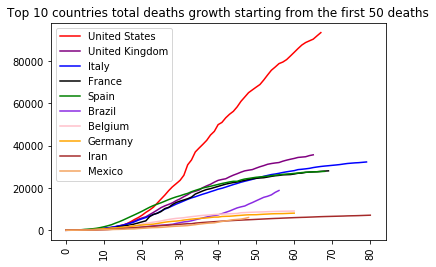

In [26]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths, top_10_total_deaths['Country'], 'Total deaths',
                            'Top 10 countries total deaths growth starting from the first 50 deaths',
                            50)

The same procedure is used for confirmed cases.

First, retrieve information about top 10 countries for total number of cases.

In [27]:
#create a copy of the dataset keeping the necessary columns
df_total_cases = df_all_data[['Country','Total cases']].copy()
#get the maximum value of each country and sort the data in descendent way
df_group_total_cases = df_total_cases.groupby('Country').max()
df_group_total_cases.sort_values(by = 'Total cases',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases = df_group_total_cases.iloc[0:10]
top_10_total_cases.reset_index(inplace = True)
#print data of all the world deaths
print("World number of cases:", df_group_total_cases['Total cases'].sum(), end ="\n\n")
top_10_total_cases

World number of cases: 4927591



,Country,Total cases
0,United States,1551853
1,Russia,308705
2,Brazil,291579
3,United Kingdom,248818
4,Spain,232555
5,Italy,227364
6,Germany,176752
7,Turkey,152587
8,France,143845
9,Iran,126949


Plot the total number of cases, day by day, of the top 10 countries, focusing on a range between 0 and 200 cases.

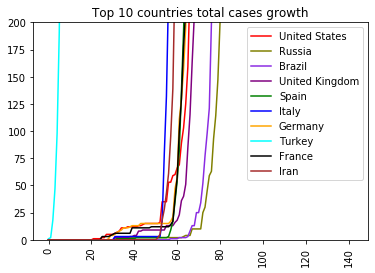

In [28]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'], 'Total cases',
                            'Top 10 countries total cases growth',
                            0, 200)

Because of a stabilization period in China around about 60 cases, this time, the starting point is set to 75 cases.

Print data of the top 10 countries for number of cases and plot the growth starting from the first 75 confirmed case.

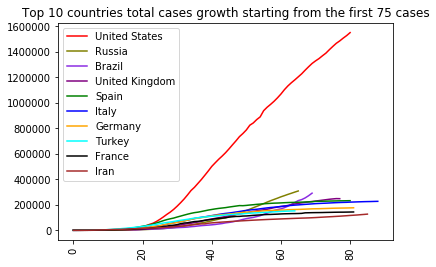

In [29]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases, top_10_total_cases['Country'],'Total cases',
                            'Top 10 countries total cases growth starting from the first 75 cases',
                            75)

### Analysis by country considering the number of inhabitants

As done before, firstly, print data of top ten countries for total deaths.

In [30]:
#create a copy of the dataset
df_total_deaths_x_million = df_all_data[['Country',
                                         'Total deaths per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_deaths_x_million = df_total_deaths_x_million.groupby('Country').max()
df_group_total_deaths_x_million.sort_values(by = 'Total deaths per million of inhabitants',ascending = False, inplace = True)


#loc the first 10 rows
top_10_total_deaths_x_million = df_group_total_deaths_x_million.iloc[0:10]
top_10_total_deaths_x_million.reset_index(inplace = True)
top_10_total_deaths_x_million

,Country,Total deaths per million of inhabitants
0,San Marino,1208.334561
1,Belgium,789.499365
2,Andorra,660.066007
3,Spain,596.473798
4,Italy,534.717559
5,United Kingdom,525.940462
6,France,430.986469
7,Sweden,379.334536
8,Netherlands,335.456256
9,Ireland,318.158786


Plot data day by day of the top 10 countries to try to detect a common starting point for comparing the growth focusing on a range between 0 and 20 cases per million of inhabitants.

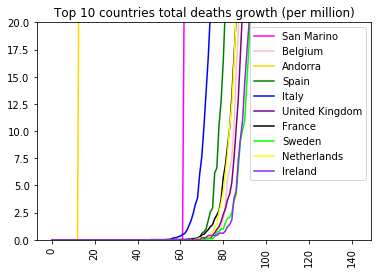

In [31]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth (per million)',
                            0, 20)

For some countries, such as Andorra and San Marino, there is not a slow growth but they have a very fast increase. A part these, it is possible to consider, as a common starting point, a value of 2.5.

Plot the growth starting from the point where the rate was upper than 2.5.

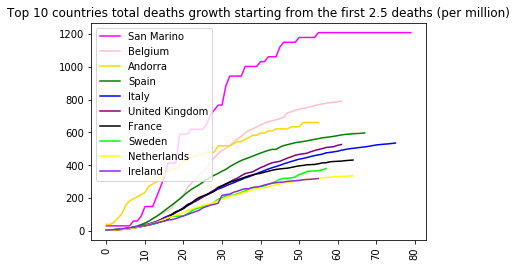

In [32]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_deaths_x_million, top_10_total_deaths_x_million['Country'], 
                            'Total deaths per million of inhabitants',
                            'Top 10 countries total deaths growth starting from the first 2.5 deaths (per million)',
                            2.5)

The growth is almost linear for the top 10 countries.

Print data of the top 10 countries for number of cases per million.

In [33]:
#create a copy of the dataset
df_total_cases_x_million = df_all_data[['Country',
                                         'Total cases per million of inhabitants']].copy()

#get the maximum value of each country and sort the data in descendent way
df_group_total_cases_x_million = df_total_cases_x_million.groupby('Country').max()
df_group_total_cases_x_million.sort_values(by = 'Total cases per million of inhabitants',ascending = False, inplace = True)
#loc the first 10 rows
top_10_total_cases_x_million = df_group_total_cases_x_million.iloc[0:10]
top_10_total_cases_x_million.reset_index(inplace = True)
top_10_total_cases_x_million

,Country,Total cases per million of inhabitants
0,San Marino,19333.352981
1,Qatar,12876.194919
2,Andorra,9862.162687
3,Luxembourg,6343.673420
4,Iceland,5283.624866
5,Singapore,5019.193750
6,Spain,4973.930151
7,Ireland,4924.271728
8,Belgium,4830.441853
9,United States,4688.340094


As done before, plot the growth to detect a common comparison starting point focusing on a range between 0 and 20 cases per million of inhabitants.

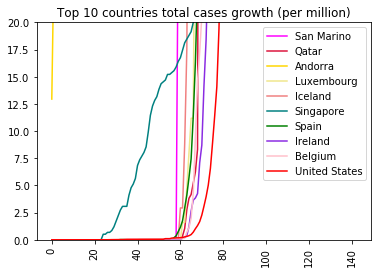

In [34]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth (per million)',
                            0, 20)

The growth increases very fast. A common starting point for comparison could be 2.5 cases per million of inhabitants.

Plot the growth starting from the point where the rate was upper than 2.5 cases per million of inhabitants.

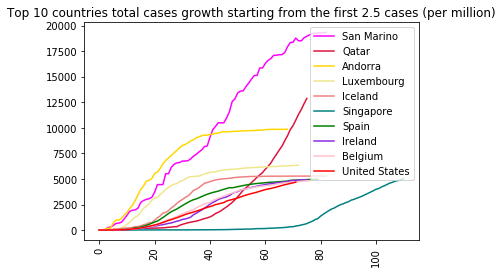

In [35]:
#plot the graph
plotGrowthDataFromFirstCases(df_total_cases_x_million, top_10_total_cases_x_million['Country'], 
                            'Total cases per million of inhabitants',
                            'Top 10 countries total cases growth starting from the first 2.5 cases (per million)',
                            2.5)

It is interesting to see how small countries have a higher concentration of deaths and cases and thye occupies the first places in number of cases and deaths in this ranking. It is now possible to find out if at a first glance there is a correlation between population density and the virus spread. Following, the population density distribution. 

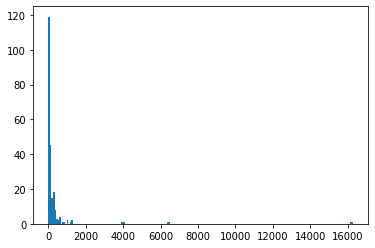

In [36]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.show()

To better visualize the distribution, a cut is placed at 1500 in the plot visualization. There are a few values upper than that. 

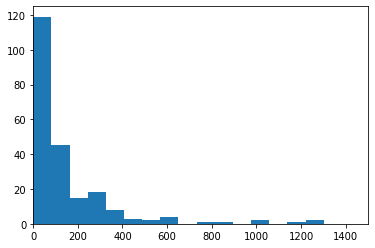

In [37]:
#plot population density
plt.hist(df_population_density['Population density'], bins=200) 
plt.xlim(0, 1500)
plt.show()

Print also some statistical information of these data.

In [38]:
df_population_density['Population density'].describe()

count      227.000000
mean       379.047137
std       1660.185825
min          0.000000
25%         29.150000
50%         78.800000
75%        190.150000
max      16271.500000
Name: Population density, dtype: float64

It is now necessary to print the population density of the top 10 countries for total number of deaths and for total number of deaths per million of inhabitants. Then we can use the mean value of the population density to compare the two groups.

In [39]:
print('Population density of top 10 countries for number of deaths:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths:

            Country  Population density
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
135          Mexico                54.5
190           Spain                80.0
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6
19          Belgium               340.0

Mean value: 135.20999999999998


In [40]:
print('Population density of top 10 countries for number of deaths per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_deaths_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of deaths per million of inhabitants:

            Country  Population density
195          Sweden                20.0
98          Ireland                57.8
190           Spain                80.0
69           France               111.3
4           Andorra               152.1
101           Italy               193.0
213  United Kingdom               247.6
19          Belgium               340.0
146     Netherlands               397.1
177      San Marino               479.5

Mean value: 207.84


The same computation is done for the total number of cases.

In [41]:
print('Population density of top 10 countries for number of cases:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases:

            Country  Population density
169          Russia                 8.4
27           Brazil                22.1
214   United States                31.0
96             Iran                41.7
190           Spain                80.0
206          Turkey                90.2
69           France               111.3
101           Italy               193.0
76          Germany               230.9
213  United Kingdom               247.6

Mean value: 105.62


In [42]:
print('Population density of top 10 countries for number of cases per million of inhabitants:\n')
print(df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())].sort_values(by = 'Population density'))
print('\nMean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_total_cases_x_million['Country'].to_list())]['Population density'].mean())

Population density of top 10 countries for number of cases per million of inhabitants:

           Country  Population density
93         Iceland                 2.9
214  United States                31.0
98         Ireland                57.8
166          Qatar                77.4
190          Spain                80.0
4          Andorra               152.1
121     Luxembourg               183.5
19         Belgium               340.0
177     San Marino               479.5
184      Singapore              6482.2

Mean value: 788.64


In this last computation there is Gibraltar that can be considered as an "outlier" for the computation of the mean value. It is possible to recompute the mean value without considering it.

In [43]:
top_10_without_gibraltar = top_10_total_cases_x_million[top_10_total_cases_x_million['Country'] != 'Gibraltar']
print('\nNew mean value:',df_population_density.loc[df_population_density['Country'].isin(top_10_without_gibraltar['Country'].to_list())]['Population density'].mean())


New mean value: 788.64


Because in the top 10 countries of the two lists, a part Gibraltar, the max value is around 500 and basing on the density population distribution most of the values are under 500, in the next step the density population dataset is filtered to remove all the data over 500. Next, statistical description is computed to better explain the impact of population density on virus spread.

In [44]:
df_filtered_population_density = df_population_density.loc[df_population_density['Population density'] < 500]
print("Statistical description of population density under a value of 500")
df_filtered_population_density.describe()

Statistical description of population density under a value of 500


,Population density
count,209.000000
mean,106.803828
std,108.814715
min,0.000000
25%,26.700000
50%,66.900000
75%,142.700000
max,496.000000


Comparing mean values of the two lists, for the number of deaths, there is a slighty difference between the top 10 countries for number of deaths and the top 10 countries for number of deaths per million of inhabitants in respect of the population density. So, the initial hypotesis that the population density could have an impact in the virus spread, is not verified.
About the difference in the confirmed cases, although the difference is more evident, it is not significant if it is taken in consideration that the standard deviation  of the population density in the filtered data is 108. The difference between the two means value is about 61 that is less than the 57% of the standard deviation. At a first glance, it is safe to say that there is not a strong correlation between the virus spread and the population density. 

## Focus on the number of new deaths an new cases.

Print data of the top ten day/country for new deaths

In [45]:
#copy the dataframe
df_new_deaths = df_all_data[['Date','Country','New deaths']].copy()
#delete the row regarding the entire world
df_new_deaths = df_new_deaths[df_new_deaths['Country'] != 'World']
#sort the data in descending order and print the top 10 rows
df_new_deaths.sort_values(by = 'New deaths', ascending = False, inplace = True)
df_new_deaths.head(10)

,Date,Country,New deaths
15393,2020-04-16,United States,4928
15395,2020-04-18,United States,3770
15401,2020-04-24,United States,3179
15407,2020-04-30,United States,2611
15399,2020-04-22,United States,2524
15392,2020-04-15,United States,2408
15414,2020-05-07,United States,2353
15394,2020-04-17,United States,2299
15415,2020-05-08,United States,2239
15403,2020-04-26,United States,2172


Evaluate the moving average for new deaths taking in consideration a period of 10 days.

In [46]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new deaths for the row date
df_matrix_new_deaths = get_matrix_dataset(df_, 'New deaths')
df_matrix_new_deaths.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-17,0,0,6,2,0,0,7,3,0,0,...,468,1186,0,0,0,0,0,4,0,0
2020-05-18,1,0,6,0,0,0,3,5,0,0,...,170,808,1,1,0,0,0,1,0,0
2020-05-19,4,0,7,0,0,0,16,1,0,1,...,160,791,0,1,0,0,0,0,0,0
2020-05-20,5,0,6,0,0,0,11,3,0,0,...,545,1568,0,0,0,0,0,8,0,0
2020-05-21,9,0,7,0,1,0,10,3,0,1,...,363,1518,0,0,0,0,0,1,0,0


In [47]:
#evaluate the moving average of the new cases matrix
df_new_deaths_moving_average_ = df_matrix_new_deaths.copy()
df_new_deaths_moving_average_ = evaluate_moving_average(df_new_deaths_moving_average_, 10)
df_new_deaths_moving_average_.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-17,4,0,5,0,0,0,7,1,0,1,...,579,1788,0,0,0,0,0,0,0,0
2020-05-18,4,0,5,0,0,0,8,1,0,1,...,602,1855,0,0,0,0,0,0,0,0
2020-05-19,4,0,5,0,0,0,8,1,0,1,...,622,1942,0,0,0,0,0,0,0,0
2020-05-20,4,0,5,0,0,0,8,1,0,0,...,593,1882,0,0,0,0,0,0,0,0
2020-05-21,5,0,5,0,0,0,8,1,0,0,...,549,1782,0,0,0,0,0,0,0,0


It is now interesting to see the evaluation, basing on the moving average of the new deaths, about the number of days between the day in which the lockdow has been set and when the peak in number of deaths has been reached. This evaluation is displayed for the top 10 countries for number of deaths. The number of days between the lockdown date and the peak is showed inside each graph.

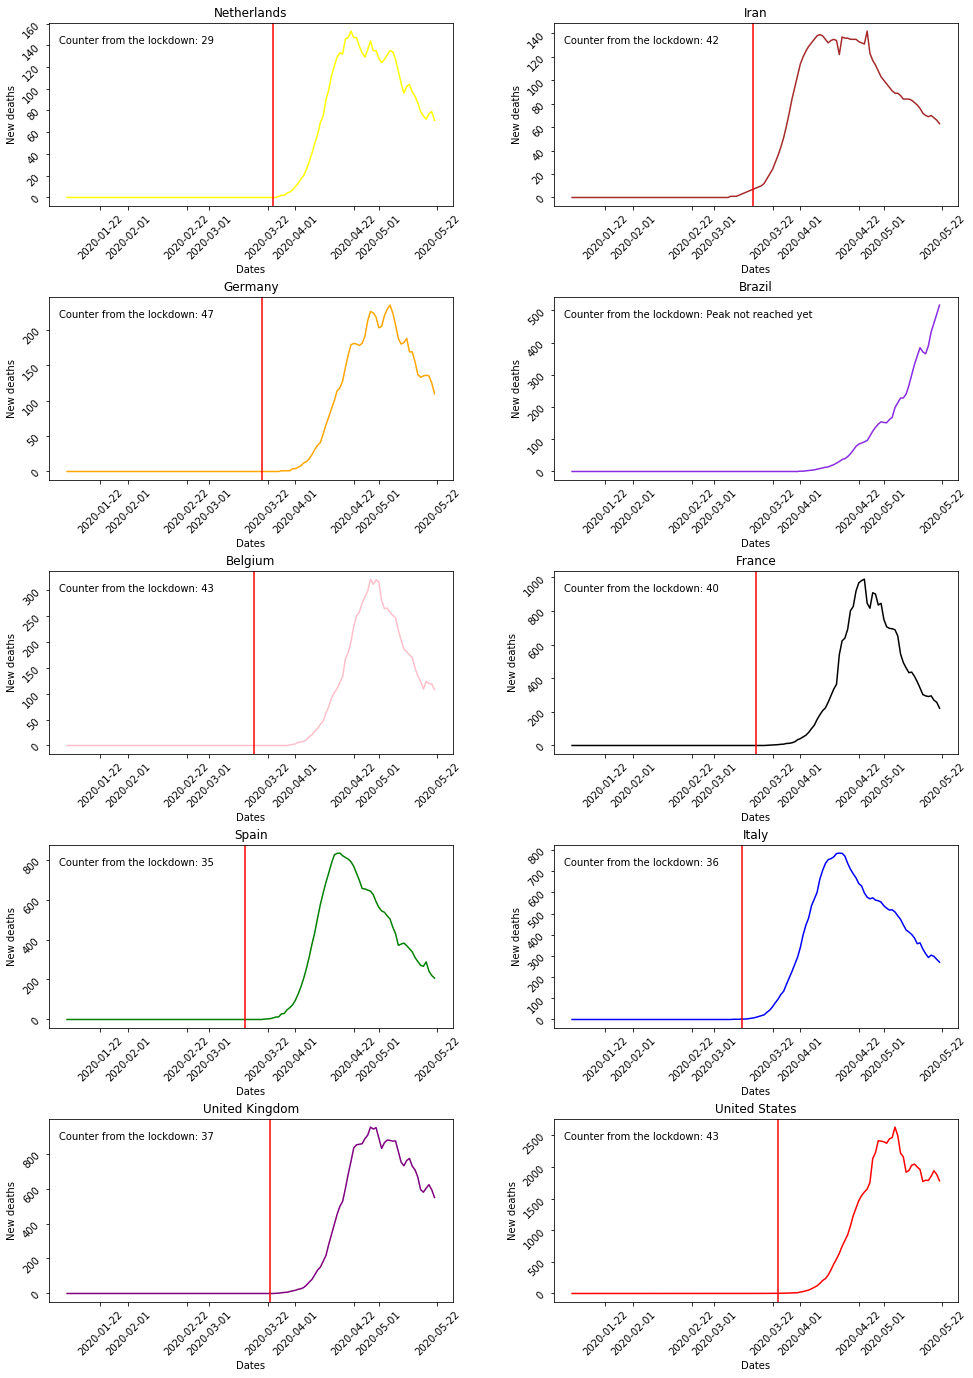

In [48]:
#calculating the top ten for deaths making the sum of all the deaths and plotting it
max_deaths=df_new_deaths_moving_average_.sum(axis = 0, skipna = True)
top_ten_new_deaths_moving_average=max_deaths.sort_values()[-10:].index

plotWithLockdown(top_ten_new_deaths_moving_average,df_lockdown,df_new_deaths_moving_average_,'New deaths')


Print data of the top ten day/country for new cases

In [49]:
#copy the dataframe
df_new_cases = df_all_data[['Date','Country','New cases']].copy()
#delete the row regarding the entire world
df_new_cases = df_new_cases[df_new_cases['Country'] != 'World']
df_new_cases.sort_values(by = 'New cases', ascending = False, inplace = True)
df_new_cases.head(10)

,Date,Country,New cases
15403,2020-04-26,United States,48529
15399,2020-04-22,United States,37289
15388,2020-04-11,United States,35527
15382,2020-04-05,United States,34272
15409,2020-05-02,United States,33955
15387,2020-04-10,United States,33901
15386,2020-04-09,United States,33323
15396,2020-04-19,United States,32922
15381,2020-04-04,United States,32425
15394,2020-04-17,United States,31667


Evaluate the moving average for new cases taking in consideration a period of 10 days.

In [50]:
#copy di full dataset
df_ = df_all_data.copy()
#create a matrix of the new deaths, in this way, each column represent
#a country and the index row are the date. In the corresponding row 
#there is the number of new cases for the row date
df_matrix_new_cases = get_matrix_dataset(df_, 'New cases')
df_matrix_new_cases.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
2020-05-17,0,17,192,0,0,0,326,239,0,17,...,3450,24487,1,50,45,5,0,18,11,2
2020-05-18,262,13,198,0,0,0,0,189,0,9,...,3534,18873,1,12,37,2,0,4,74,2
2020-05-19,408,2,182,0,0,0,566,351,0,15,...,2711,21841,3,49,77,4,0,2,8,0
2020-05-20,581,1,176,0,2,0,438,218,0,8,...,2412,19970,1,78,131,0,0,37,11,0
2020-05-21,492,15,165,1,2,0,474,230,0,11,...,-525,23285,8,70,75,0,0,13,60,2


In [51]:
#evaluate the moving average of the new cases matrix
df_new_cases_moving_average_ = df_matrix_new_cases.copy()
df_new_cases_moving_average = evaluate_moving_average(df_new_cases_moving_average_, 20)
df_new_cases_moving_average.tail()

,Afghanistan,Albania,Algeria,Andorra,Angola,Anguilla,Argentina,Armenia,Aruba,Australia,...,United Kingdom,United States,Uruguay,Uzbekistan,Venezuela,Vietnam,Western Sahara,Yemen,Zambia,Zimbabwe
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-17,58,17,96,11,0,0,110,46,1,47,...,5028,30070,9,76,8,1,0,0,2,1
2020-05-18,59,17,97,10,0,0,106,48,1,43,...,5061,29885,9,74,8,0,0,0,2,1
2020-05-19,66,17,102,9,0,0,113,50,1,38,...,5095,29482,10,70,8,0,0,0,2,1
2020-05-20,70,17,103,8,0,0,115,52,1,34,...,5020,29022,9,69,8,0,0,0,2,1
2020-05-21,73,17,109,8,0,0,118,50,0,29,...,5007,28693,9,71,8,0,0,0,2,1


The same evaluation done before for the number of deaths, is now done for the new cases.

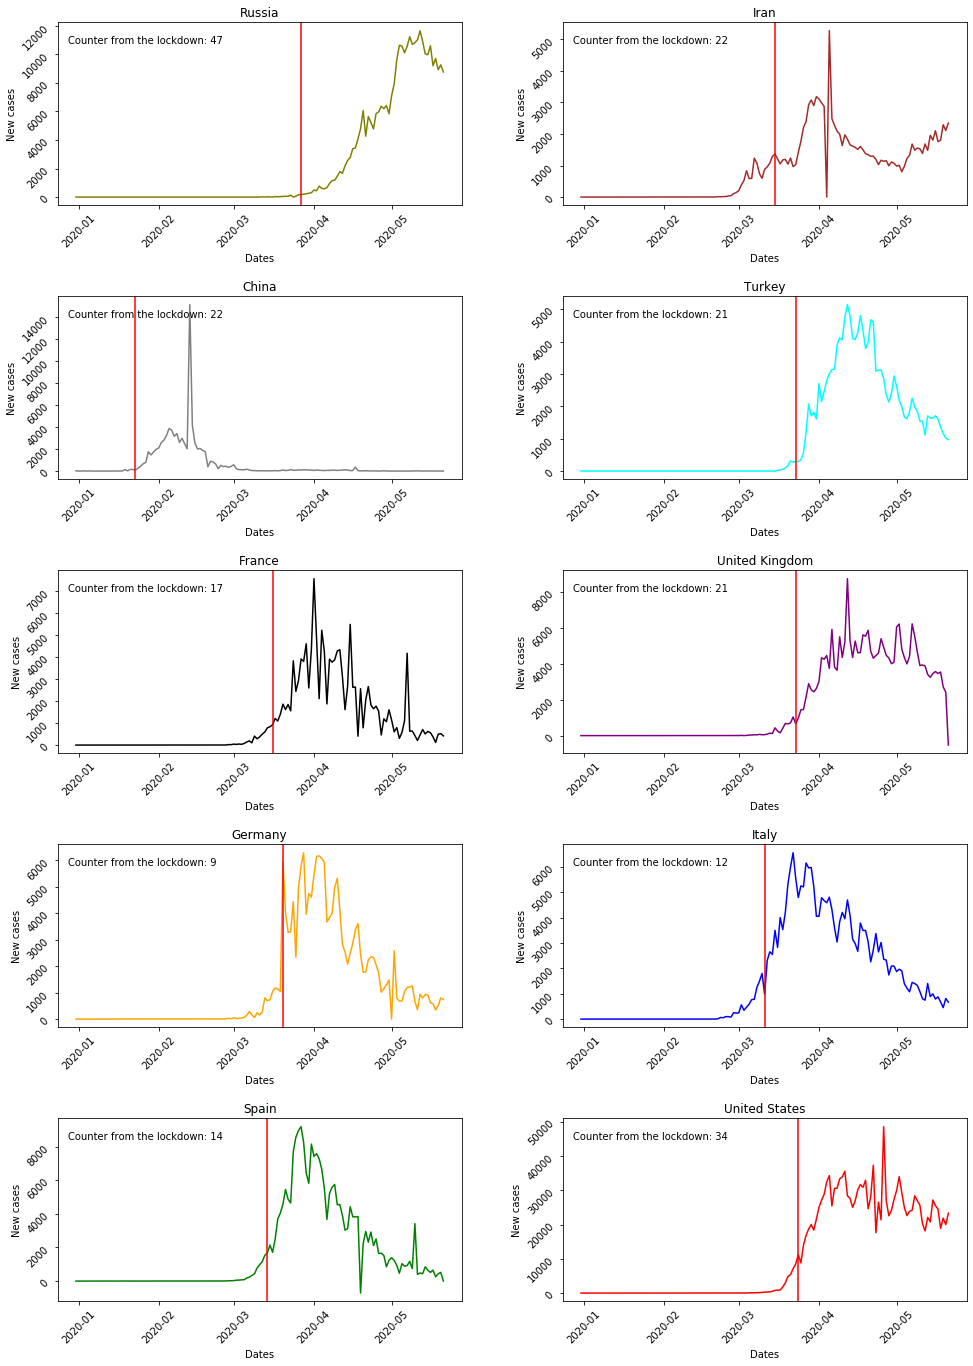

In [52]:
max_cases=df_new_cases_moving_average.sum(axis = 0, skipna = True)
top_ten_new_cases_moving_average=max_cases.sort_values()[-10:].index

plotWithLockdown(top_ten_new_cases_moving_average,df_lockdown,df_new_cases_moving_average_,'New cases')

An immediate consideration that can be done looking at these final data is that while for the new cases graphs of the top 10 countries the peak is always passed, for the number of deaths many countries has not been reached the peak yet and generally, the average period of the new cases to get the peak is faster than the corresponding value of the number of deaths. A hypotesis could be that once the virus is identified in a country, there are a lot of cases already present in that country. The lockdown is a containtment action that allow to block the spread so, in a few days, the number of new cases decrease. Unlike this, the deaths come later because the virus doesn't kill a person immediately. It needs many days to make it happen.

Another consideration that can be highlighted is that the graph about deaths is more linear than the number of cases. This could be because the number of cases is also influenced by the number of swabs executed in each day. Unfortunately this data are not available for al the countries and often are not reliable.

## Analysis of the percentage of growth

In this section, an evaluation on the growth rate for the total number of deaths and cases has been computed. The growth rate is evaluated considering the difference in terms of total number of deaths or total number of cases between two consecutive days divided the total number of deaths or cases that the desease has generated for a particular country. Then the top 5 countries data are displayed.

Create a dataframe with the total deaths grow rate for each country day by day.

In [53]:
df_total_deaths = df_all_data[['Date','Country','Total deaths']].copy()
death_growth_rate = evaluateGrowthRate(df_total_deaths, 1, 'Total deaths')

Plot the death grow rate of the top 5 countries for deaths.

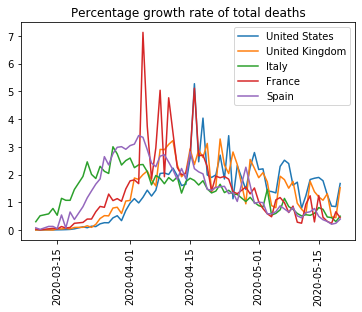

In [54]:
#get the list of the top 5 countries
top_5_death_countries_list = top_10_total_deaths['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_deaths_growth = death_growth_rate[top_5_death_countries_list]

some_countries_deaths_growth=some_countries_deaths_growth[some_countries_deaths_growth>0]
some_countries_deaths_growth=some_countries_deaths_growth.dropna()
for country in top_5_death_countries_list:
    plt.plot(some_countries_deaths_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total deaths")
plt.show()

Create a dataframe with the total cases grow rate for each country day by day.

In [55]:
df_total_cases = df_all_data[['Date','Country','Total cases']].copy()
case_growth_rate = evaluateGrowthRate(df_total_cases, 1, 'Total cases')

Plot the grow rate of the top 5 countries for number of cases.

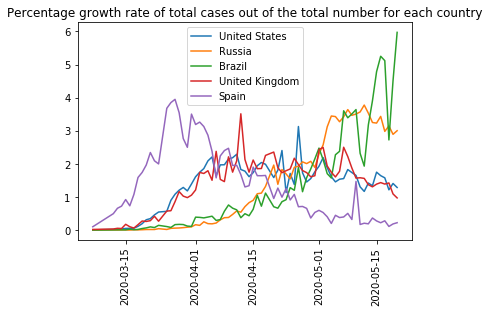

In [56]:
#get the list of the top 5 countries
top_5_case_countries_list = top_10_total_cases['Country'].to_list()[0:5]
#select the growth rate only of the countries list
some_countries_cases_growth = case_growth_rate[top_5_case_countries_list]
some_countries_cases_growth=some_countries_cases_growth[some_countries_cases_growth > 0]
some_countries_cases_growth=some_countries_cases_growth.dropna()
for country in top_5_case_countries_list:
    plt.plot(some_countries_cases_growth[country], label = country)
plt.legend()
plt.xticks(rotation = 90)
plt.title("Percentage growth rate of total cases out of the total number for each country")
plt.show()

In this last graphs it is possible to see which are the days, for the top 5 countries, more critical. Obviously, the real problem is in the days after each peak, where the emergency must be managed in term of cases (hospital) or deaths (death bodies management).

## Italy

### Provinces Analysis not considering the number of hinabitants

Exploring the dataset to mine useful information.
Plot data to visualize ongoing desease in the various provinces.

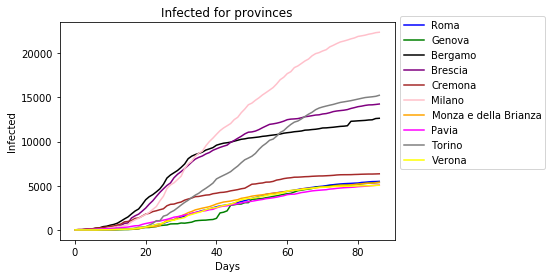

<Figure size 432x288 with 0 Axes>

In [57]:
x=len(time_line_dataset.columns[2:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

Milano is the most hit province for number of infected.

Some new information could be required to have a better picture.
One of this information is the total population for each city taken in exam.
We will discuss this in detail later on.
For now the graph it's aligned with what the informations that we can hear in TV and News in general are accurate.
Of course i cannot provide proof of that, but a little search on google should validate my considerations.

In [59]:
population=pd.read_csv('../COVID19_analysis/dati aggiuntivi/it.csv',encoding = "ISO-8859-1")

difference =pd.Index(time_line_dataset['denominazione_provincia'].tolist()).symmetric_difference( population['index'])
population_time_line_dataset=time_line_dataset.merge(population, left_on='denominazione_provincia', right_on='index')
del population_time_line_dataset['location']
del population_time_line_dataset['google']
del population_time_line_dataset['index']

population_time_line_dataset.head()

,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520,population
0,Abruzzo,Chieti,0,0,0,0,0,0,0,0,...,778,778,778,783,802,804,811,811,813,44444
1,Abruzzo,L'Aquila,0,0,0,0,0,0,0,0,...,244,244,246,246,246,246,246,246,246,33691
2,Abruzzo,Pescara,0,0,0,0,0,0,0,0,...,1448,1460,1467,1474,1483,1488,1487,1491,1497,116596
3,Abruzzo,Teramo,0,0,0,1,1,2,5,5,...,645,645,645,645,647,648,649,649,649,36099
4,Basilicata,Matera,0,0,0,0,0,0,0,0,...,206,206,206,206,206,207,207,207,207,54891


### Provinces Analysis considering the number of hinabitants

Since the distribution of the population for each city could give misleading information, a sample of 75000 inhabitants to even the things up was used.

I used the median factor to decide that, beacuse there are big cities that represents outliers in the population distribution and the median should not consider those outliers.


In [60]:
population_time_line_dataset['population'].median()

77124.0

Now let's redo a top ten to see if something changed from the previous approach

In [61]:
for i in range(2,len(population_time_line_dataset.columns)-1):
    column=population_time_line_dataset.columns[i]
    population_time_line_dataset[column]=(population_time_line_dataset[column]/population_time_line_dataset['population'])*75000

population_time_line_dataset.sort_values(by=[str(yesterday).replace("-", "")],ascending=False)[:10]


,denominazione_regione,denominazione_provincia,20200224,20200225,20200226,20200227,20200228,20200229,20200301,20200302,...,20200512,20200513,20200514,20200515,20200516,20200517,20200518,20200519,20200520,population
38,Lombardia,Bergamo,0.0,11.825301,13.139223,47.301204,67.667000,72.265728,137.304883,159.641562,...,8076.680507,8092.447574,8111.499448,8127.266516,8144.347506,8174.567720,8187.706943,8282.309350,8299.390340,114162
41,Lombardia,Cremona,0.0,66.738302,71.775155,114.588405,154.883229,171.253001,269.471634,280.804553,...,7876.378839,7899.044677,7914.155236,7936.821074,7949.413207,7962.005339,7962.005339,7977.115898,7996.004097,59561
44,Lombardia,Mantova,0.0,0.000000,0.000000,0.000000,0.000000,1.910341,7.641365,9.551707,...,6218.160978,6239.174733,6256.367804,6267.829852,6269.740194,6286.933265,6286.933265,6292.664289,6304.126337,39260
43,Lombardia,Lodi,0.0,229.965413,235.484583,292.516006,334.829642,436.014423,632.864817,706.453749,...,6058.208845,6072.926632,6095.003312,6117.079991,6146.515564,6164.912797,6168.592244,6198.027817,6218.264773,40767
47,Lombardia,Pavia,0.0,30.805976,30.805976,41.074634,55.907141,62.752913,88.995041,94.699851,...,5499.437125,5532.525025,5586.150242,5612.392369,5640.916421,5680.850093,5729.911461,5758.435513,5798.369185,65734
39,Lombardia,Brescia,0.0,0.000000,0.811574,4.057871,5.275232,5.681019,19.883566,24.347224,...,5578.760564,5616.904548,5659.917977,5684.265201,5717.945527,5740.669603,5745.133260,5761.770530,5782.059883,184826
48,Lombardia,Sondrio,0.0,3.473830,10.421491,10.421491,10.421491,10.421491,10.421491,10.421491,...,4575.034738,4588.930060,4647.985178,4651.459009,4734.830940,4748.726262,4755.673923,4786.938397,4804.307550,21590
57,Piemonte,Alessandria,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4375.331110,4388.185983,4404.546729,4416.232977,4427.919225,4436.099598,4440.774097,4448.954470,4455.966219,64178
60,Piemonte,Cuneo,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4280.312823,4296.471044,4307.781799,4328.787487,4338.482420,4343.329886,4359.488108,4362.719752,4372.414685,46416
42,Lombardia,Lecco,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,3.220266,4.830399,...,4123.550880,4158.973809,4184.735938,4212.108201,4241.090597,4258.802061,4263.632460,4326.427651,4332.868184,46580


Now let's compare the original graph with the new one,spot some differences and think about some conclusions.
Unfortunately we don't have a lot of information for provinces, a lot of invformation revolves around regions.Everything we will say could be an additional information for the regions, but as it is now, it's just speculations

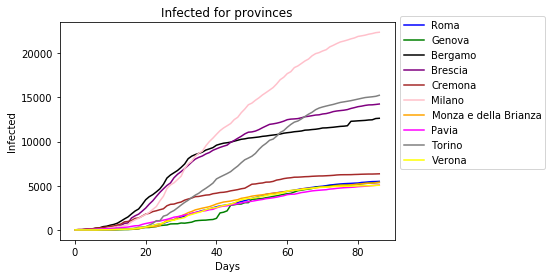

<Figure size 432x288 with 0 Axes>

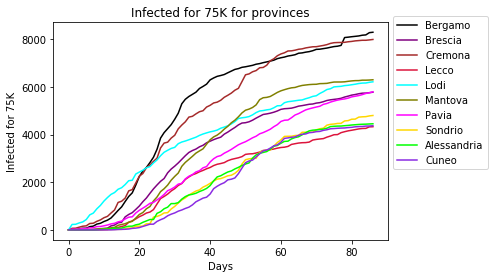

<Figure size 432x288 with 0 Axes>

In [62]:
x=len(time_line_dataset.columns[2:])
x=range(0,x)
condition_plot(x,top_ten_list(time_line_dataset,1),['Infected','provinces'])

x=len(population_time_line_dataset.columns[2:-1]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(population_time_line_dataset.loc[:,:str(yesterday).replace("-", "")],1),['Infected for 75K','provinces'])


It is possible to see a clear difference. 
While cities like Bergamo and Brescia are still in both plots, we have new cities as well, such as Lodi or Pavia in top ten.
Confronting this information with what we hear in TV, the inhabitant consideration could be more appropriate.
In TV we always hear about Bergamo being the most hit with this pandemic, and the second plot reflect that.
Most of the cities are in North Italy like we excpect since the boom of the pandemic started prom Lombardia.
We can give conclusions about regions in the next part, but for now let's say one more thing about the provinces.
Most of the provinces that are in the top ten(if not all) are huge urban metropolies,where people travel a lot every day.
It's not surprising then that the virus spread so much in those areas, considering the density of the population as well.

We can have a counter example as well. Roma has the most habitant in all italian cities, and in fact in the first plot it's present. But, from personal experience, and reliable sources, Roma is not as active as a city like Milano. There are few transports, and just 2 metros. Relaing on cars for moving, or just simple walk could be one cause of less spreading of the virus. Still there are a lot of people, so of course the virus spread a lot there as well.

### Region analysis

A look at each datasets plot and then trying to give some interpretations to what is showed.
Before starting, a look at the top ten density population of the regions:

In [63]:
time_line_dataset_regions.sort_values(by=['Density(ab./Km^2)'],ascending=False)[:10]

,denominazione_regione,Density(ab./Km^2)
8,Lombardia,422.76
3,Campania,422.25
6,Lazio,340.47
7,Liguria,286.30
17,Veneto,267.42
12,Puglia,205.33
4,Emilia-Romagna,198.62
14,Sicilia,192.36
11,Piemonte,171.60
15,Toscana,162.25


This information could be useful to give some conclusion on the next plots that will be analyze, so it's better to keep them in mind.

Starting with the hospitalized with symptoms, but not in grave condition.

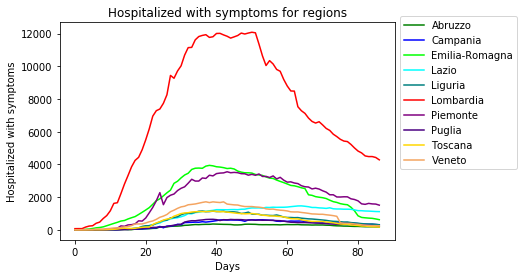

<Figure size 432x288 with 0 Axes>

In [64]:
x=len(tl_hospitalized_with_symptoms.columns[1:]) #number of days. Everytime we will add a new day, the value of x will be updated
x=range(0,x)

condition_plot(x,top_ten_list(tl_hospitalized_with_symptoms,0),['Hospitalized with symptoms','regions'])

Lombardia is one of the most affected regions, but this is expected.
New sites and TV always referes to that, so there is nothing new.
Based on what did before, it is safe to say that most of the cities within Lombardia are the most affected, so computing these results, Lombardia will come on top for the most hit region by the virus.
While this datasets revolves around the hospitalized people, another conclusion can be done.

Lombardia has the most advanced hospitals in all Italy, so naturally most of the people are here because there are a lot of experts in the matter or in their part of Italy, there are not Hospitals that can sustain them.
One example, in example, with a quick google search, Napoli has a huge problem with hospitals. They are in bad state, and the medical staff doesn't work properly (in general, not every single one of them.). So it's likely that the people want to go to a better hospital or just don't go there. In the top ten ranking, Campania is the last one in fact even if the density population it's really high.

Although there are 20 regions, and not everyone appears, but those regions are really small, so the amount of hospitals could be really small, forcing them to go elsewhere.

It is possible at least to say that the curve is reducing, toward a better perspective.

Next step is to have a look on intensive therapy.

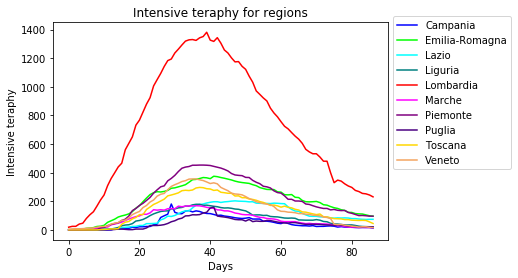

<Figure size 432x288 with 0 Axes>

In [65]:
condition_plot(x,top_ten_list(tl_intensive_teraphy,0),['Intensive teraphy','regions'])

The situation is almost exactly the same as before. The discussion is the same: more and qualitative hospitals are in northen region of the Italy. Naturally most of the people want to be cured by specialist, or if other hospitals don't have enough space, in Lombardia and such there are a lot of hospitals (unfortunately not enough for this pandemic).
One example could be the center of intensive therapy now opened in Rho, in place of the Expo. Since in Lombardia there are a lot of hospitals (even new ones made just for this pandemic), there are more patients than the available places. Of course density of the population is a factor as well.

Next step is to have a look at the deaths.

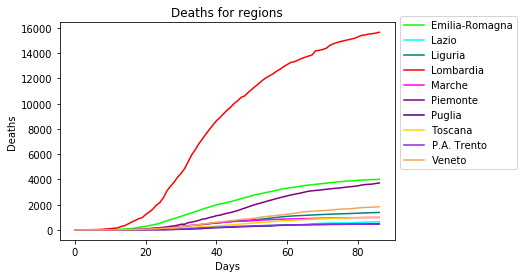

<Figure size 432x288 with 0 Axes>

In [66]:
condition_plot(x,top_ten_list(tl_deaths,0),['Deaths','regions'])

While Lombardia is on top again, almost every other region is different.
Being that the most of the ill are in Lombardia, it's not surprising that the most amount of deaths is here as well.
Lazio and Toscana could also be in the top ranking because the amount of the population.
The new one here are Marche, and Trentino alto adige. While it's difficul to pin point why this is like this, one possibility is that the lockdown in those regions was a bit further in the line.
The interesting to see though, it's about the dates.
Lombardia sky rocketted with deaths in hust 10-20 days going as far as 12000+ deaths. The other regions don't have this amount of deaths.
The logical explanation is that for a couple of weeks, only Lombardia had COVID cases, while the other regions didn't.
When the virus then arrived in those regions, precautions where already made, so less people died.

Next step is to have a look to the isolations.

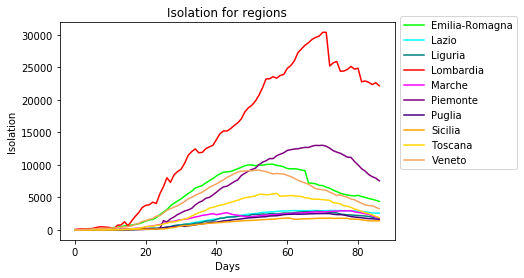

<Figure size 432x288 with 0 Axes>

In [67]:
condition_plot(x,top_ten_list(tl_isolation,0),['Isolation','regions'])

This graphs doesn't really suggest nothing interesting. Of course more and more people get confined due to the laws made for this pandemic.
The interesting thing though, is that it is possible to see that the lines sometimes goes down. A deduction can be made: a lot of italians are just irresponsible, and get out anyways despite the law.

Next step is to have a look at the actual postives.

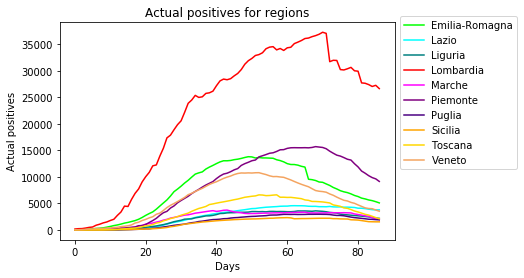

<Figure size 432x288 with 0 Axes>

In [68]:
condition_plot(x,top_ten_list(tl_actual_positives,0),['Actual positives','regions'])

Nothing interesting to say here as well, the more hospitalized, the more positives we have.
One thing to note is that the positives are not decreasing, while the hospitilized are.
This could be that a lot of people are asintomatic, and so, they don't need to be in the hospital.
Doing a ratio between hospitalized and poitives could hint a rough amount of the asintomatic for region.

Next plot shows how the positive rate is growing.

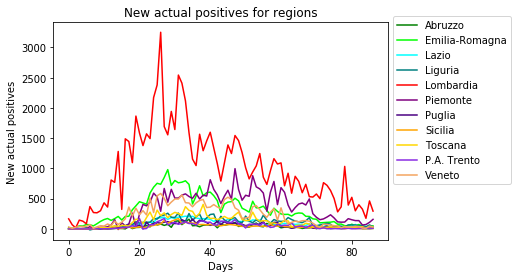

<Figure size 432x288 with 0 Axes>

In [69]:
condition_plot(x,top_ten_list(tl_new_actual_positives,0),['New actual positives','regions'])

This plot is really fuzzy. This is propably due to the fact that not every day there are new positives.
Before analyzing it, last plot can be stabilized applying a moving average on the value.

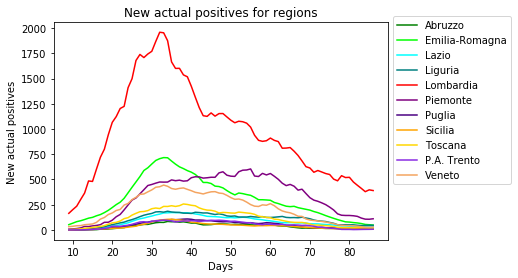

<Figure size 432x288 with 0 Axes>

In [70]:
x2=len(tl_hospitalized_with_symptoms.columns[1:]) 
x2=range(9,x2) #Starting index is in regars of the window frame of the moving mean, in this case 10 (0 to 9)

moving_averages_NPositive=moving_mean_with_names(top_ten_list(tl_new_actual_positives,0),10)
moving_averages_variance=moving_mean_with_names(top_ten_list(tl_variance,0),10)
condition_plot(x2,moving_averages_NPositive,['New actual positives','regions'])
#condition_plot(x2,moving_averages_variance,['Variance total positives','regions'])

It is possible to see that the new postives are decreasing more and more.
The fact that the actual positives are on an higher value it's just because once someone is positive, the illness will last for a couple of weeks.
Since around day 30, the lockdown started for everyone so the graph displays that new positives are decreasing. The countermeasure taken by the government seems to work pretty fine.

Next step is to have a look at the recovered people.

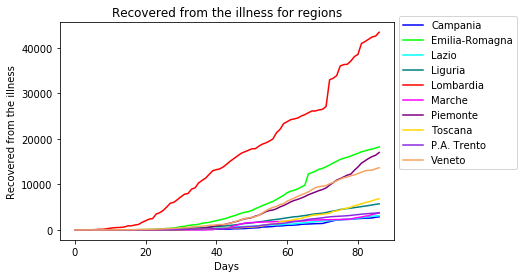

<Figure size 432x288 with 0 Axes>

In [71]:
condition_plot(x,top_ten_list(tl_recovered,0),['Recovered from the illness','regions'])

The recovery from the illness is not related to the lockdown, since once you have the illness, it has to pass on its own.
There is not much to analyze here, only that where there is a peak of recovered (around 50-60 days), the amount of hospitilez decreases.

Next a plot about the number of tampons.

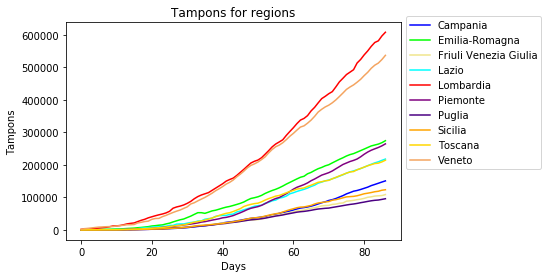

<Figure size 432x288 with 0 Axes>

In [72]:
condition_plot(x,top_ten_list(tl_tampons,0),['Tampons','regions'])

On the curve itself there is not much to say, the tampons are growing exponentially every day, beacuse there is the necessity to do the most amount of them for isolating positive people. The interesting thing to analyze are the regions.
Veneto is on the same level of the Lombardia.
This is beacuse news and TV said that Veneto started to use them before the pandemic even began. It's not surpirsing to see them like that.
Another thing that it is possible to see is that with all these tampons done, Veneto has not a lot of positives, hospitalized and everything saw up until now. This data enforces the thesis about the importance in executing tampons to isolate as soon as possible positive people.
That's possible beacuse stricter investigations where done, and the spreading of the virus reduced a lot in respect of other regions.

One final look at the total of cases(recovered and not).

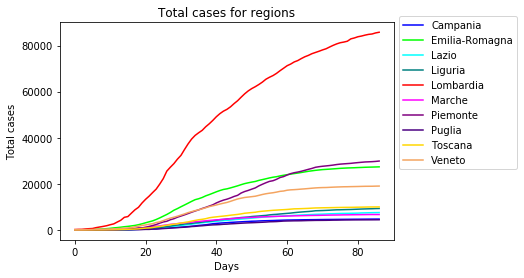

<Figure size 432x288 with 0 Axes>

In [73]:
condition_plot(x,top_ten_list(tl_total,0),['Total cases','regions'])

Everything said up until now stands.
There is nothing to say about this plot but as a matter of fact, it is possible to see that every single region with the greater number of infected, is in the list of the most density population list.
It's not a perfect match, because even though Lombardia is in the first place of both the density and almost every plots, other regions are not. 
In example, Campania occupies the second place of the population density ranking, but it's one of the lower displayed in the actual positive graph and a hypothesis has been done why this could be the case.
More than one factor could concern this aspect, such as the date of lockdown, or the population behavior, but it seems that the density population helped the diffusion of the virus as well. 

It is possible to see that the total cases are really high and there are not stabilizing yet.
When the lines will be parallel to the X axis, we could say that finally the illness it's under control.
Sadly, Lombardia trend is nowhere near to be flat, but other regions like Emilia-Romagna could give some brim of hope for the near future.

# Time series

In this section, an analysis to understand the stationarity of the series about the country (Italy) and the region (Lombardia) where we live has been computed. The analysis has been done graphically, with the autocorrelation and partial autocorrelation plot and then numerically, with the Dickey-Fuller test. Then, basing on the result about the stationarity of the series, the ARIMA model has been applied in order to compute a forecast of the new cases for a short term prediction.

Firstly, let's plot our series

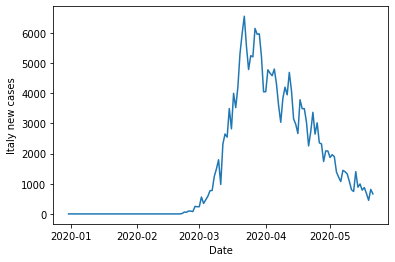

In [223]:
df_series_Italy = df_matrix_new_cases['Italy'].copy()

plt.xlabel('Date')
plt.ylabel('Italy new cases')
plt.plot(df_series_Italy)

Now, let's plot with the series the rolling mean and the rolling standard deviation to better understand the trend.

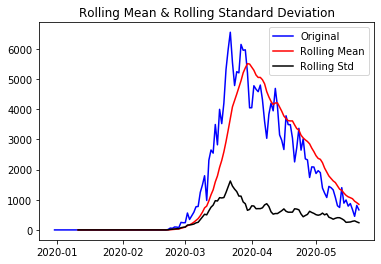

In [191]:
rolling_mean = df_series_Italy.rolling(window = 12).mean()
rolling_std = df_series_Italy.rolling(window = 12).std()
plt.plot(df_series_Italy, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As it is possible to see, the rolling mean and the rolling standard deviation increase and then decrease, so it is possible to conclude that the series is not stationary. A further test that we can perfom for understanding if the series is stationary is the Dickey-Fuller test. Let's compute it.

In [192]:
dickey_fuller_test = dickeyFuller(df_series_Italy)

ADF Statistic: -1.7727133365529937
p-value: 0.39409041650785204
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598


It is possible to see from these last data that the series is not stationary because th p-value is greater than the 5% and the ADF statistic value is greater than the 5% critical value.
Now, for lowering the rate at which the rolling mean increase it is possible to take the logaritm of the dependent variable of the series.

Now, one of the transformation that it is possible to compute to make a series stationary, is to subtract the rolling mean.

In [219]:
rolling_mean = df_series_log.rolling(window=12).mean()
df_series_log_minus_mean = df_series_log - rolling_mean
df_series_log_minus_mean.dropna(inplace=True)

Now we can test the series again with the Dickey-Fuller test to verify if after the transformation the series is stationary.

In [220]:
dickey_fuller_test = dickeyFuller(df_series_log_minus_mean)

ADF Statistic: -2.4050642528780486
p-value: 0.14031215953239018
Critical Values:
	1%: -3.481281802271349
	5%: -2.883867891664528
	10%: -2.5786771965503177


Because the series is not yet stationary, let's try to apply a multiplicative approach to detrend it.

Text(0.5, 1.0, 'Italy new cases subtracting the trend component (multiplicative)')

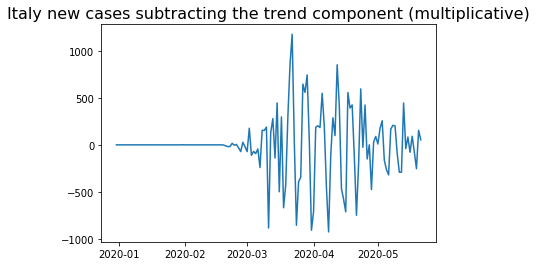

In [233]:
#replace 0 value to avoid error later
df_series_Italy = df_series_Italy.replace(0, 1)
result_mul = seasonal_decompose(df_series_Italy, model='multiplicative', extrapolate_trend='freq')
detrended = df_series_Italy.tolist() - result_mul.trend
plt.plot(df_series_Italy.index, detrended)
plt.title('Italy new cases subtracting the trend component (multiplicative)', fontsize=16)

In [234]:
dickey_fuller_test = dickeyFuller(detrended)

ADF Statistic: -3.3508040444154266
p-value: 0.012754743035706069
Critical Values:
	1%: -3.480500383888377
	5%: -2.8835279559405045
	10%: -2.578495716547007


Ok, now the series is detrended. Let's plot the autocorrelation and partial autocorrelation plot to define the ARIMA parameters.

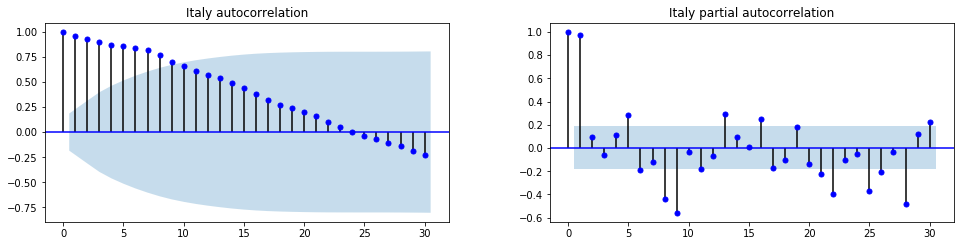

In [237]:
autocorrelationPlot('Italy',df_matrix_new_cases,30)

We can use ACF to determine the optimal parameter of MA while PACF to determine the optimal parameter for AR. Looking to the PACF graph there are 

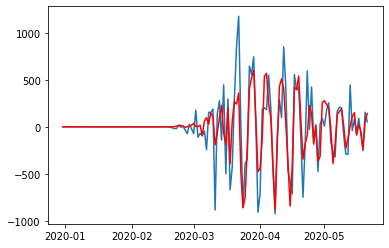

In [244]:
decomposition = seasonal_decompose(detrended) 
model = ARIMA(detrended, order=(3,0,7))
results = model.fit(disp=-1)
plt.plot(detrended)
plt.plot(results.fittedvalues, color='red')

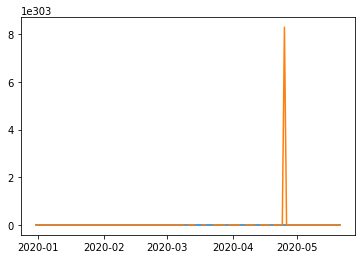

In [246]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_ = detrended
predictions_ARIMA_ = predictions_ARIMA_.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_)
plt.plot(df_series_Italy)
plt.plot(predictions_ARIMA)

SARIMAX: 
(4, 0, 6)
predicted=627.349961, expected=202.428571
predicted=599.354827, expected=183.857143
predicted=94.116577, expected=548.714286
predicted=139.739612, expected=194.857143
predicted=-193.475694, expected=-455.857143
predicted=-637.082635, expected=-925.285714
predicted=-166.630692, expected=-112.428571
predicted=276.365303, expected=287.571429
predicted=496.501275, expected=98.285714
predicted=486.341932, expected=850.857143
predicted=49.241761, expected=415.857143
predicted=-290.966907, expected=-463.428571
predicted=-748.694667, expected=-579.000000
predicted=-532.178984, expected=-712.142857
predicted=289.550009, expected=556.142857
predicted=368.785593, expected=391.285714
predicted=506.370778, expected=424.000000
predicted=272.298595, expected=-120.428571
predicted=-440.231164, expected=-748.571429
predicted=-163.251619, expected=-208.142857
predicted=-156.098141, expected=594.857143
predicted=205.787693, expected=-25.857143
predicted=110.297426, expected=423.000000

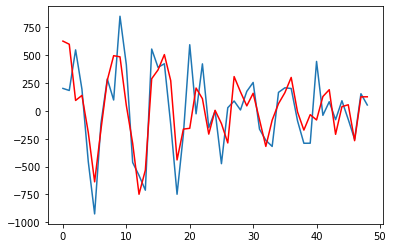

In [245]:
    
autoArima(detrended,0.66,True)

Now, let's focus on Lombardia region. A little bit of preprocessing to adapt the italian dataset to the autocorrelation functions just declared is performed.

In [77]:
#print(tl_new_actual_positives[tl_new_actual_positives['denominazione_regione']=='Abruzzo'].iloc[0])
transpose_cases=tl_new_actual_positives.set_index('denominazione_regione')
transpose_cases=transpose_cases.transpose()

max_cases=transpose_cases.sum(axis = 0, skipna = True)
top_ten_region_new_cases=max_cases.sort_values()[-5:].index

Now compute the same analysis done for the Italy country to check the stationarity of the series of the Lombardia region for number of new cases.

ADF Statistic: -2.287855376348993
p-value: 0.17591477576813885
Critical Values:
	1%: -3.5194805351545413
	5%: -2.9003945086747343
	10%: -2.5874984279778395


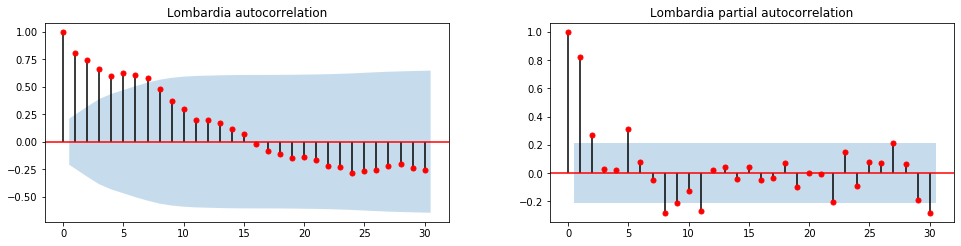

In [78]:
autocorrelationPlot('Lombardia',transpose_cases,30)
dickey_cases_italian_0 = dickeyFuller(transpose_cases['Lombardia'])

As for the country in which Lombardia is kept, the series is not stationary. The dickey-fuller test confirm this assumption.

ARIMA: 
(5, 0, 2)
predicted=678.779193, expected=960.000000
predicted=786.328511, expected=1161.000000
predicted=1119.607220, expected=1073.000000
predicted=1183.344390, expected=1091.000000
predicted=1078.456334, expected=713.000000
predicted=775.044315, expected=920.000000
predicted=822.368624, expected=590.000000
predicted=771.098316, expected=869.000000
predicted=916.690308, expected=786.000000
predicted=876.478021, expected=598.000000
predicted=733.954977, expected=737.000000
predicted=650.227854, expected=533.000000
predicted=584.728688, expected=526.000000
predicted=598.019732, expected=577.000000
predicted=614.985153, expected=500.000000
predicted=605.912084, expected=764.000000
predicted=676.777189, expected=720.000000
predicted=676.114515, expected=634.000000
predicted=627.375956, expected=502.000000
predicted=521.121727, expected=282.000000
predicted=428.466650, expected=364.000000
predicted=462.712243, expected=1033.000000
predicted=814.504523, expected=394.000000
predicted

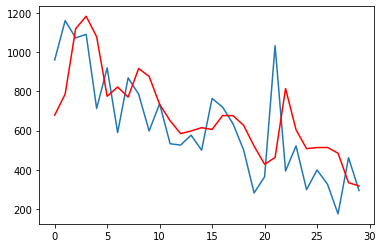

In [79]:
if(dickey_cases_italian_0[0]>dickey_cases_italian_0[4]['5%']):
    stationary=False
else: 
    stationary=True
    
autoArima(transpose_cases['Lombardia'],0.66,stationary)

# Models

# ARIMA

Link utili:
Autocorrelazione e arima: https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q

Codice Arima: https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

Parametri per Arima: https://machinelearningmastery.com/tune-arima-parameters-python/

First, we fit an ARIMA(p,d,q) model.

it's easy to determin d. In our case, we see the first order differencing make the ts stationary. d= 1.

Let's put Iran as example.
AR model might be investigated first with lag length selected from the PACF or via empirical investigation. In our case, it's clearly that within 5 lags the p is significant. Which means, we can use p = 5

To avoid the potential for incorrectly specifying the q order (in the case where the q is first tried then the q order is being set to 0), it may often make sense to extend the lag observed from the last significant term in the PACF.

What is interesting is that when the AR model is appropriately specified, the the residuals from this model can be used to directly observe the uncorrelated error. This residual can be used to further investigate alternative MA and ARMA model specifications directly by regression.

When fitting the model, a lot of debug information is provided about the fit of the linear regression model. We can turn this off by setting the disp argument to 0.

In [74]:
# fit model
model = ARIMA(df_matrix_new_cases['Iran'], order=(6,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                 D.Iran   No. Observations:                  142
Model:                 ARIMA(6, 1, 0)   Log Likelihood               -1060.998
Method:                       css-mle   S.D. of innovations            424.106
Date:                Thu, 21 May 2020   AIC                           2137.997
Time:                        13:04:53   BIC                           2161.643
Sample:                    01-01-2020   HQIC                          2147.606
                         - 05-21-2020                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           16.0557     16.735      0.959      0.337     -16.745      48.856
ar.L1.D.Iran    -0.8700      0.084    -10.419      0.000      -1.034      -0.706
ar.L2.D.Iran    -0.4478      0.110     -4.05

This prints a summary of the fit model. This summarizes the coefficient values used as well as the skill of the fit on the on the in-sample observations.

For a good model, we want to see the residual is normal distribution. And ACF, PACF has not significant terms.

Now, we get a line plot of the residual errors, suggesting that there may still be some trend information not captured by the model.

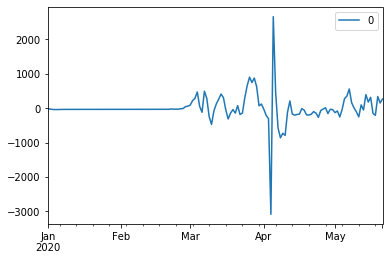

In [75]:
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()


Next, we get a density plot of the residual error values, suggesting the errors are Gaussian.

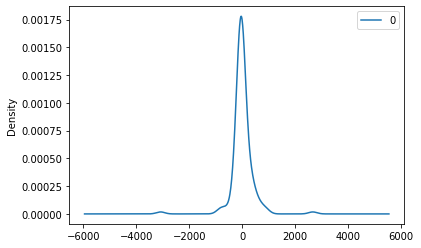

In [76]:
residuals.plot(kind='kde')
plt.show()


The distribution of the residual errors is displayed. The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

In [77]:
print(residuals.describe())

                 0
count   142.000000
mean     -0.047204
std     425.609710
min   -3083.091167
25%     -64.032643
50%     -34.222593
75%      35.475832
max    2660.977949


Using the forecast() function performs a one-step forecast using the model.

We can split the training dataset into train and test sets, use the train set to fit the model, and generate a prediction for each element on the test set.

A rolling forecast is required given the dependence on observations in prior time steps for differencing and the AR model. A crude way to perform this rolling forecast is to re-create the ARIMA model after each new observation is received.

We manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended each iteration.

We can also calculate a final mean squared error score (MSE) for the predictions, providing a point of comparison for other ARIMA configurations.



ESEMPIO UNITED STATES: CAMBIA LO STATO PER VARI RISULTATI
POTREI FARE UN MODELLO PER PAESE IN TOP TEN NELLA SEZIONE PRECEDENTE PER CONFRONTARLO CON L'AUTOCORRELAZIONE, MA C'è DA CAPIRE COSA DIMOSTRARE

A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). We can see the values show some trend and are in the correct scale

Dataset reworking for better suiting the linear regression

Now, let's try to see if there is a correlation between the population density in the world countries and the total cases.
Firstly, prepare the dataset with the necessary columns. We have to add a column to store the data of each country about the ratio between the total number of cases and the population.

In [80]:
df_regression_friendly=df_all_data[pd.to_datetime(df_all_data['Date'])==pd.to_datetime(yesterday) ].copy()
df_regression_friendly=df_regression_friendly[df_regression_friendly['Lockdown state']==2]
df_regression_friendly['Ratio cases-population']=df_regression_friendly['Total cases']/df_regression_friendly['Population']
del df_regression_friendly['New cases']
del df_regression_friendly['New deaths']
del df_regression_friendly['New cases per million of inhabitants']
del df_regression_friendly['New deaths per million of inhabitants']
df_regression_friendly=df_regression_friendly.reset_index()
del df_regression_friendly['index']
df_regression_friendly.head()

,Date,Country,Total cases,Total deaths,Population,Population density,Total cases per million of inhabitants,Total deaths per million of inhabitants,Beginning Date,Lockdown state,Ratio cases-population
0,2020-05-20,Afghanistan,7653,178,38928346,48.0,196.591964,4.572504,2020-03-24,2,0.000197
1,2020-05-20,Albania,949,31,2877797,124.6,329.766137,10.772129,2020-03-08,2,0.000330
2,2020-05-20,Algeria,7377,561,43851044,13.8,168.228606,12.793310,2020-03-24,2,0.000168
3,2020-05-20,Andorra,761,51,77265,152.1,9849.220216,660.066007,2020-03-16,2,0.009849
4,2020-05-20,Angola,50,2,32866272,9.7,1.521316,0.060853,2020-03-24,2,0.000002


Let's try to compute a linear regression between the population density and the total cases, to see if there is a linear correlation between these two variables.

Coefficients: 
 [-3.40655258]
Mean squared error: 5160224791.15
Coefficient of determination: 0.00


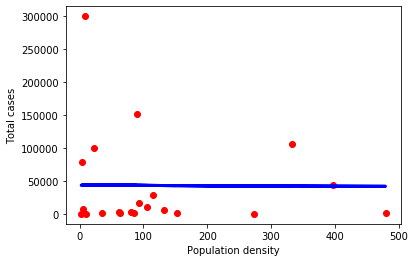

In [81]:
linearRegression(df_regression_friendly['Population density'], df_regression_friendly['Total cases'],'Population density','Total cases')

The statistics description and and the graph suggest that there isn't a linea correlation and also, that there isn't any type of correlation.

Now, let's try to compute the same analysis but scaling the total number of cases with the population of each country. In this way, it is possible to see the correlation between the population density and the total number of cases in ratio with the population.

Coefficients: 
 [7567360.64994722]
Mean squared error: 107898891132.72
Coefficient of determination: -0.02


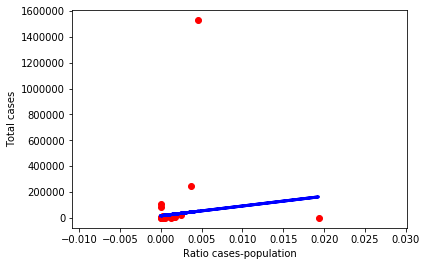

In [82]:
linearRegression(df_regression_friendly['Ratio cases-population'], df_regression_friendly['Total cases'],'Ratio cases-population','Total cases')

At a first glance, no correlation seems to be exist. But before draw this conclusion, let's try to remove the data that seems to be an outlier and then try to compute the regression again.

Coefficients: 
 [1.18705663]
Mean squared error: 108967196.16
Coefficient of determination: -0.02


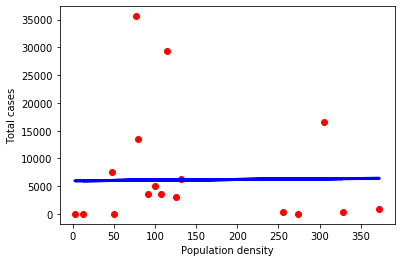

Coefficients: 
 [155153.61441126]
Mean squared error: 75628079.17
Coefficient of determination: 0.08


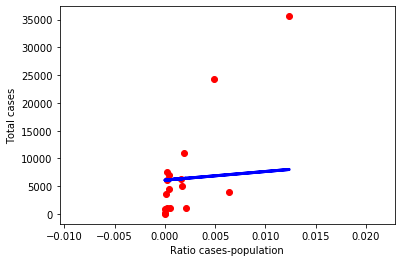

In [83]:
df_regression_friendly_WO=df_regression_friendly[df_regression_friendly['Total cases']<40000]
df_regression_friendly_WO=df_regression_friendly_WO[df_regression_friendly_WO['Population density']<4000]

linearRegression(df_regression_friendly_WO['Population density'], df_regression_friendly_WO['Total cases'],'Population density','Total cases')
linearRegression(df_regression_friendly_WO['Ratio cases-population'], df_regression_friendly_WO['Total cases'],'Ratio cases-population','Total cases')


Even without the outlier, no correlation appears to be present between these two variables.
So, we can conclude that the population density has not a direct impact in term of covid-19 cases. This evaluation was already been done during the visualization phase, where we had note that there were in the top ten countries for total number of cases, countries with a high rate of population density and countries with a low rate of population density.

## World new cases prediction modelling

In this section the goal is to try to predict the new cases trend in countries where the covid-19 was spread since a short period of time. In other words, the goal will be to take the trend of the countries where the virus was present when the covid-19 has been detected in the first months of the year, and try to predict the trend in countries where the virus has been detected some days ago. The process steps will be the following:
<ul>
<li>plot the new cases of coronavirus of the top new cases countries, starting from a common point, that is when a country has exceeded a predefined threshold of new cases. The other countries will be temporaly discarded. The goal of this first phase is trying to detect a similarity between the trend of the series. We are confident that some simililarities will be present because this intuition has started to grow in our mind in the visualization phase of this project;</li>
<li>if a silimilarity is found, the next step will be to classify the country trend assigning a class to each country with a similiar trend;</li>
<li>then, set a minimum number of days used to select all the countries to consider to train a model that later will be used to predict the trend for the "new" covid-19 countries;</li>
<li>prepare a dataset to train and test the models;</li>
<li>use the models to predict the trend for the covid-19 countries in which the viurs has started to spread from fewer days than the "hystorical" covid-19 countries.</li>
</ul>

As written before, let's start to plot the data of the top ten countries for new cases starting from a threshold of 200 cases

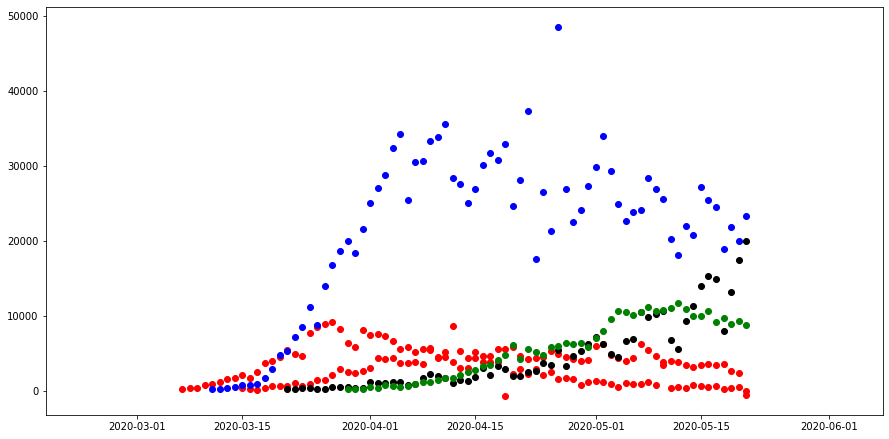

In [84]:
scatterCases(top_ten_new_cases,df_matrix_new_cases,200,True)

Plot the data separately to better understand the trend.

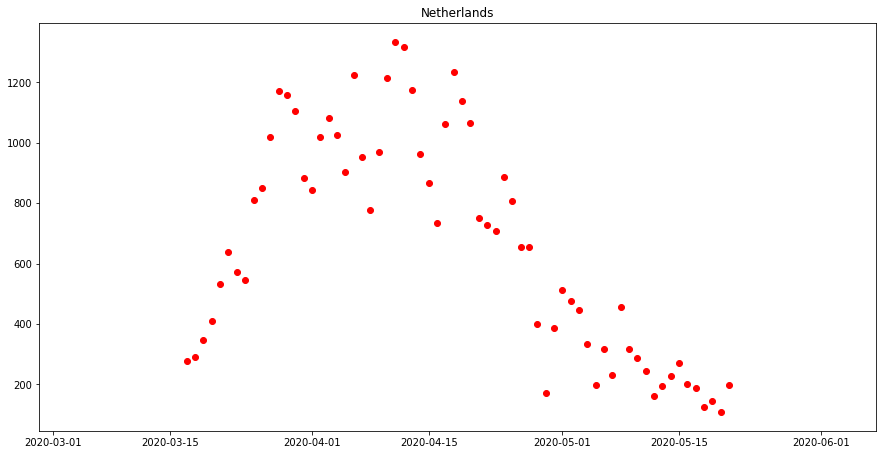

<Figure size 432x288 with 0 Axes>

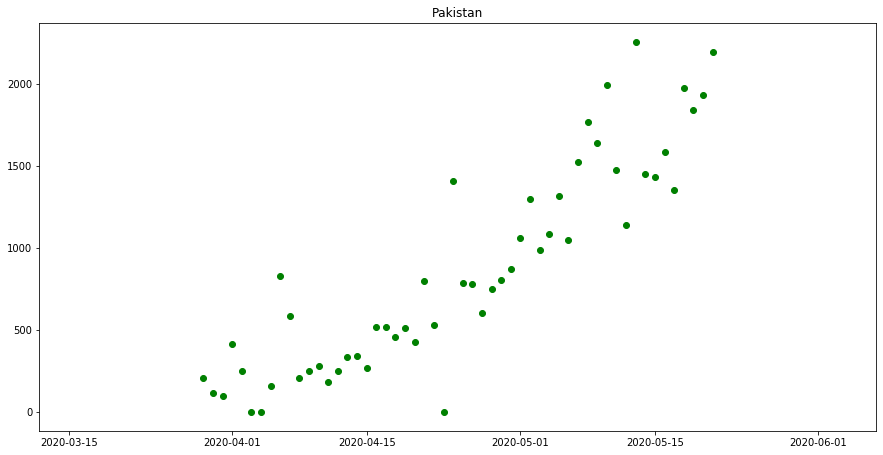

<Figure size 432x288 with 0 Axes>

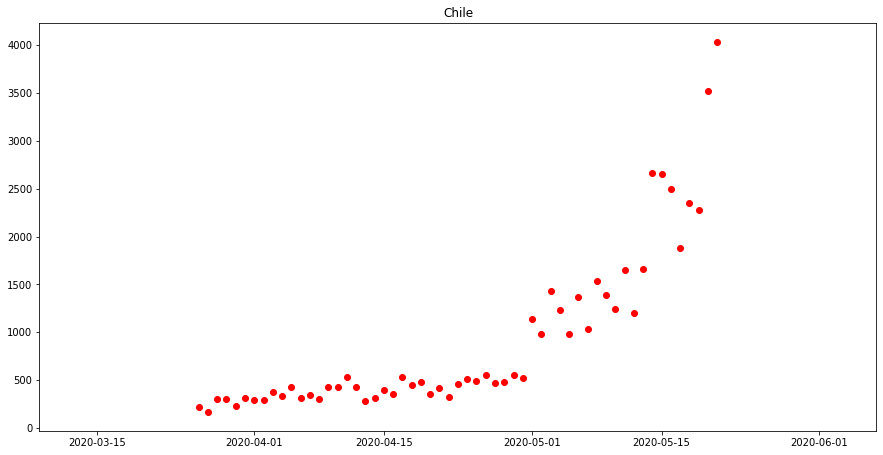

<Figure size 432x288 with 0 Axes>

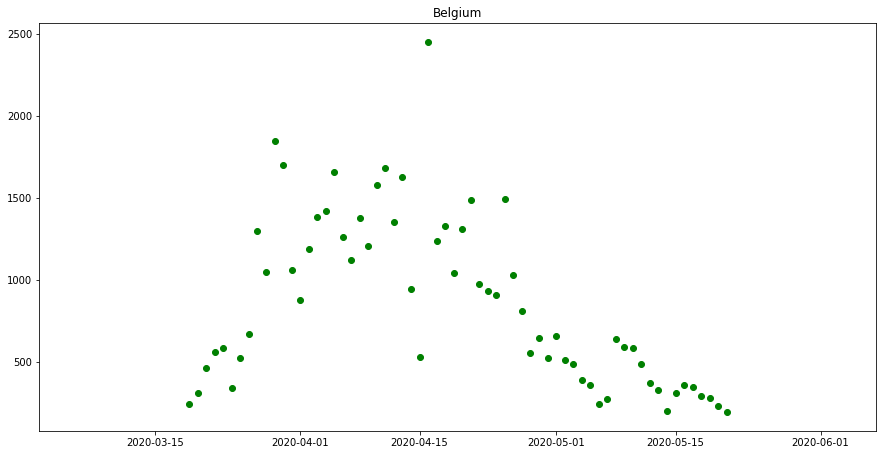

<Figure size 432x288 with 0 Axes>

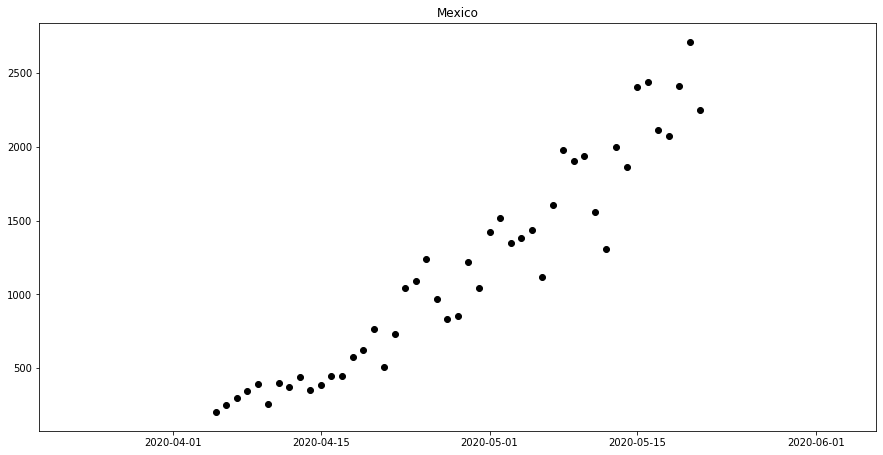

<Figure size 432x288 with 0 Axes>

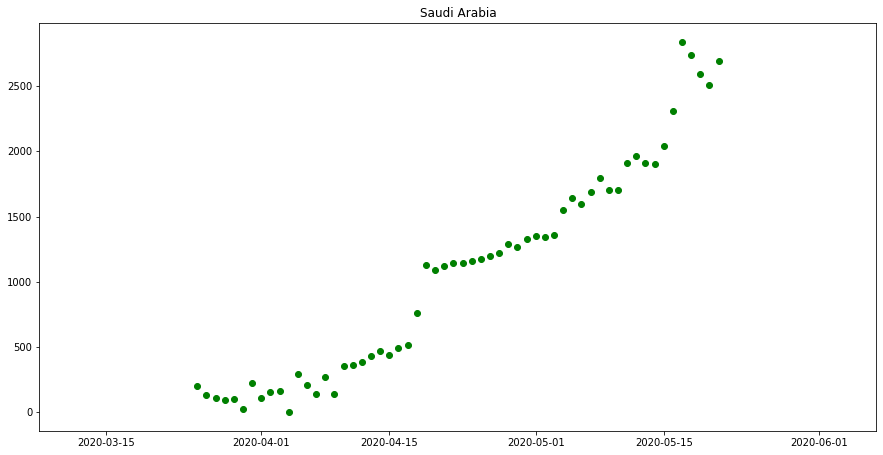

<Figure size 432x288 with 0 Axes>

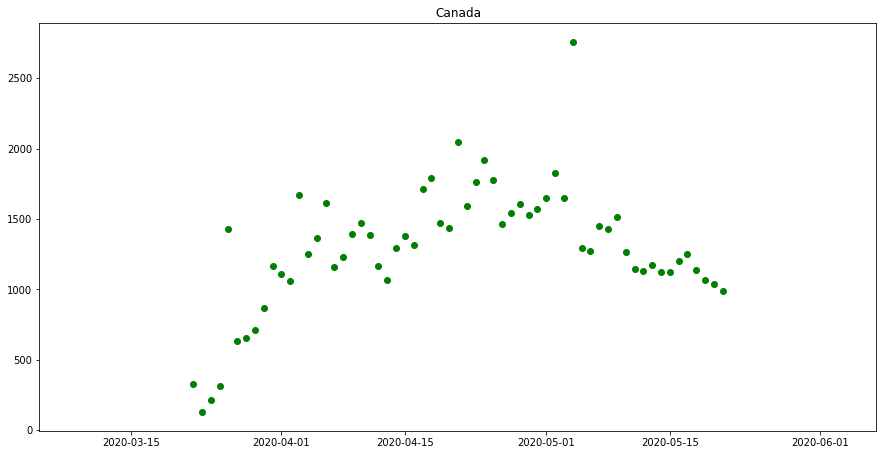

<Figure size 432x288 with 0 Axes>

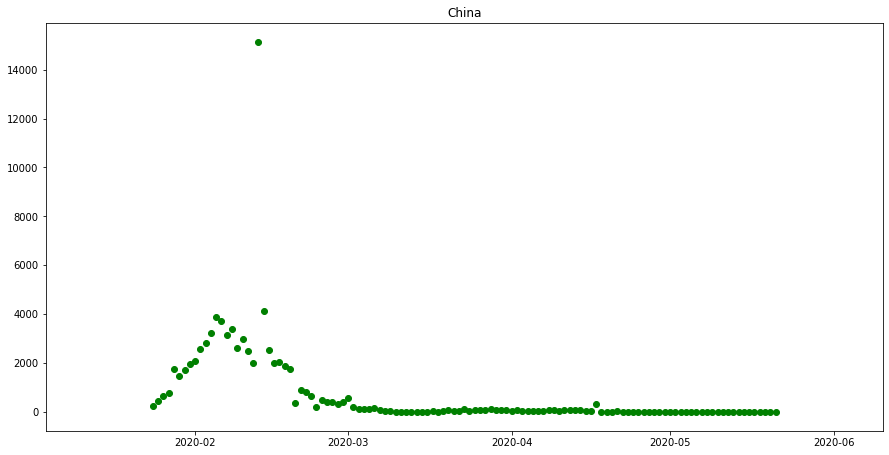

<Figure size 432x288 with 0 Axes>

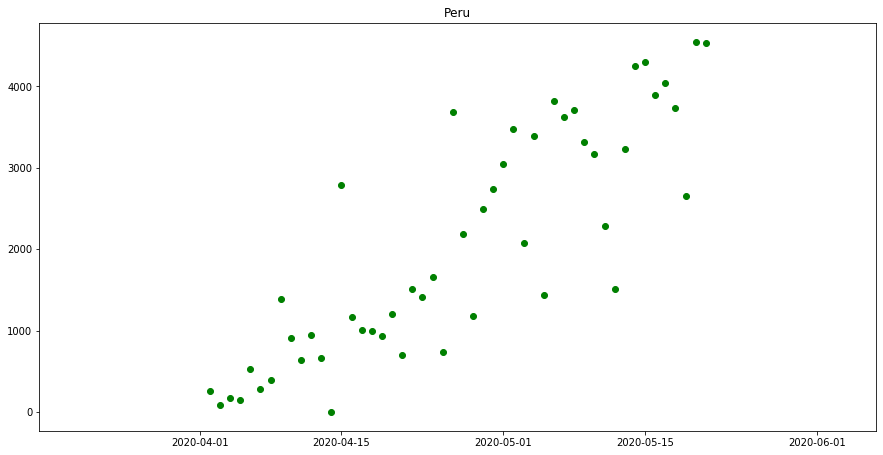

<Figure size 432x288 with 0 Axes>

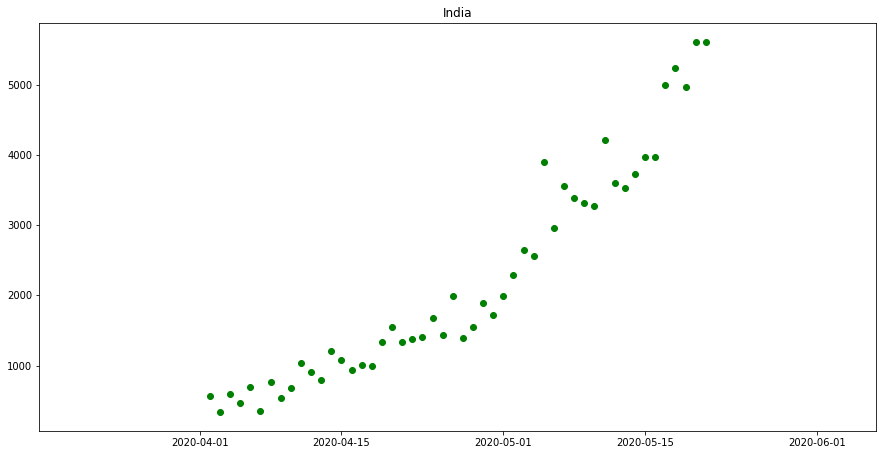

<Figure size 432x288 with 0 Axes>

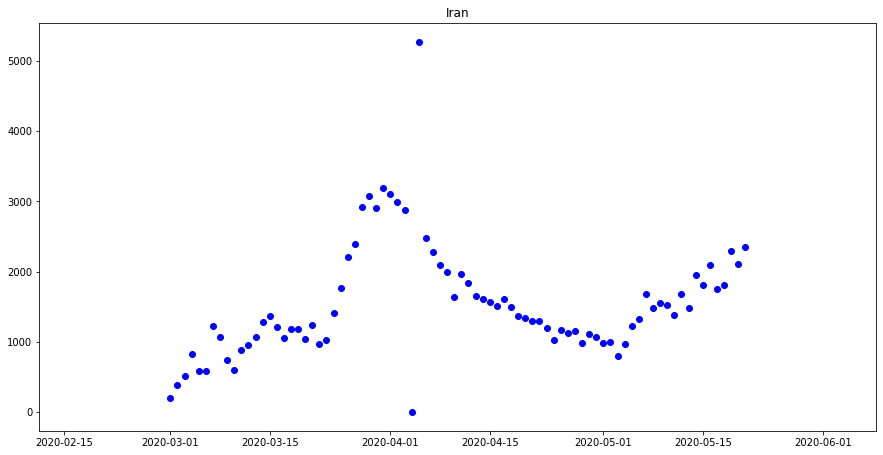

<Figure size 432x288 with 0 Axes>

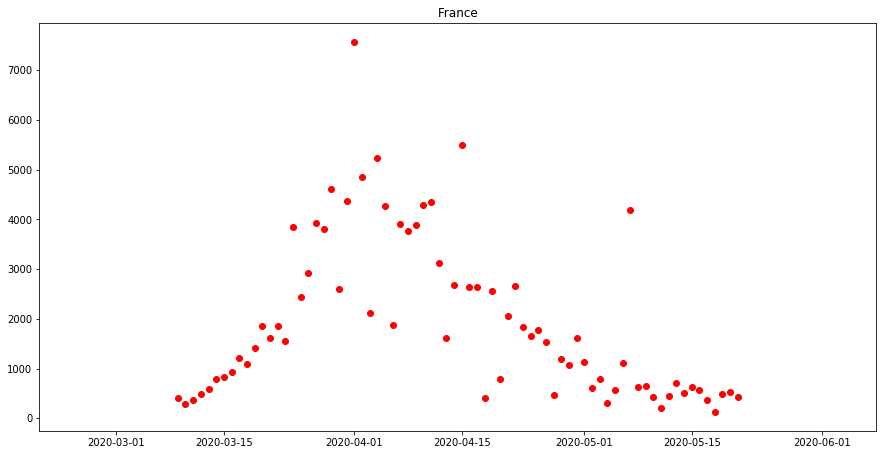

<Figure size 432x288 with 0 Axes>

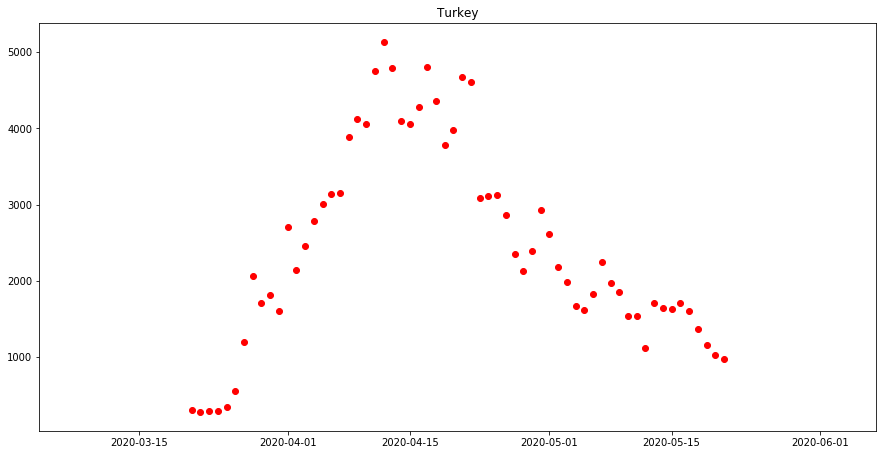

<Figure size 432x288 with 0 Axes>

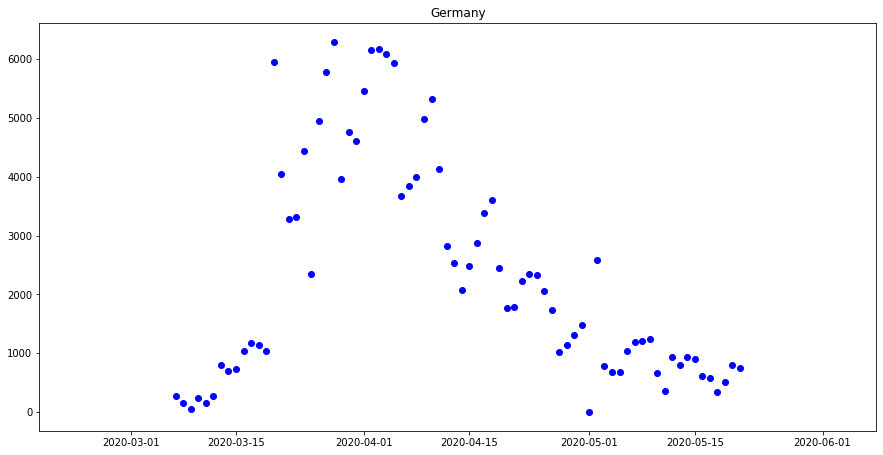

<Figure size 432x288 with 0 Axes>

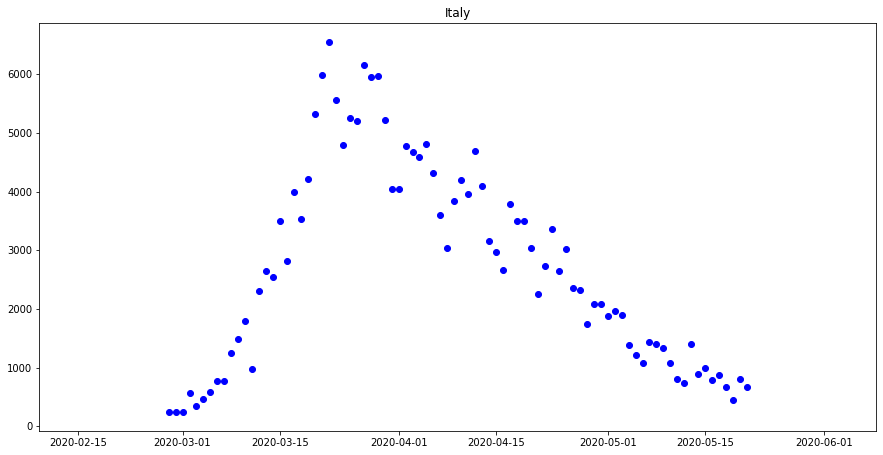

<Figure size 432x288 with 0 Axes>

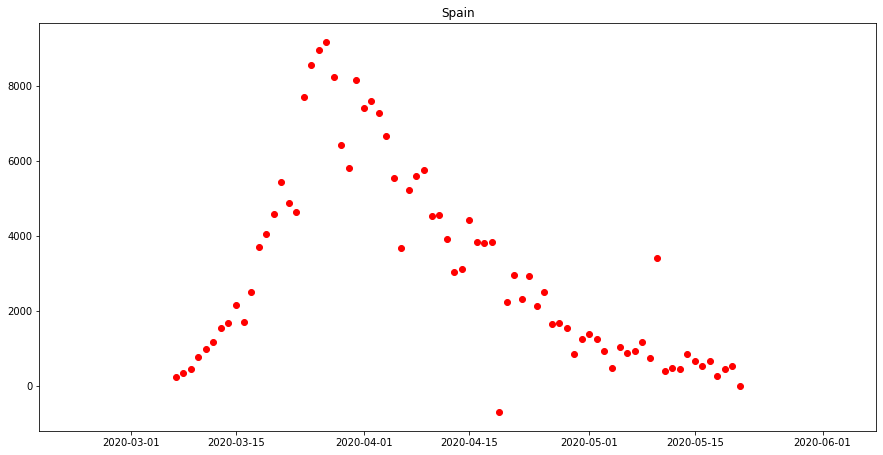

<Figure size 432x288 with 0 Axes>

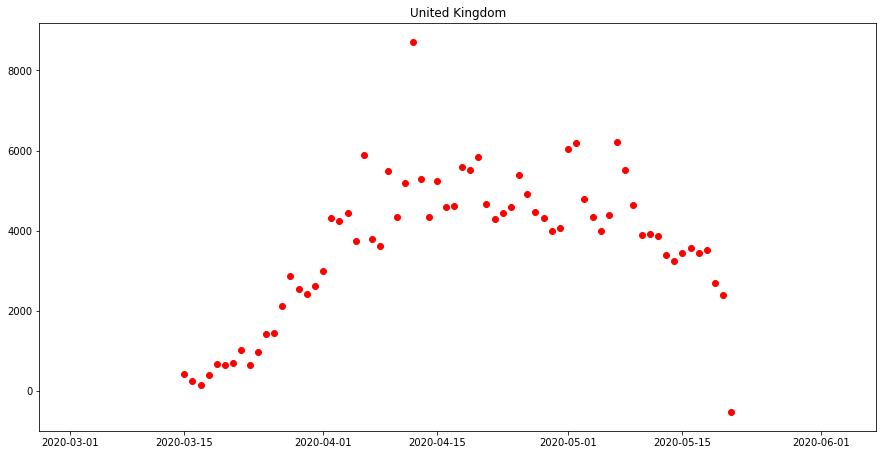

<Figure size 432x288 with 0 Axes>

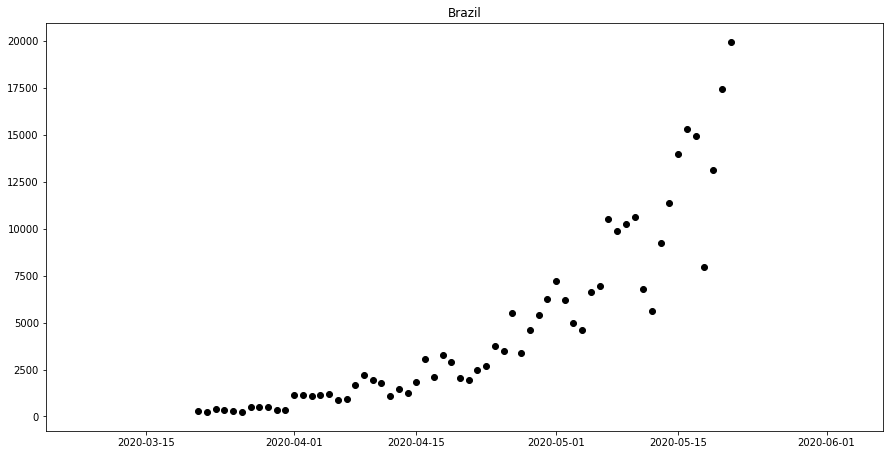

<Figure size 432x288 with 0 Axes>

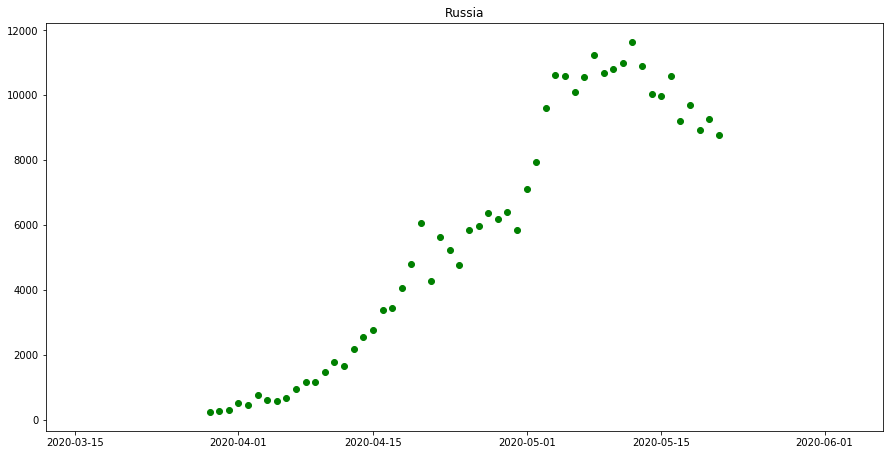

<Figure size 432x288 with 0 Axes>

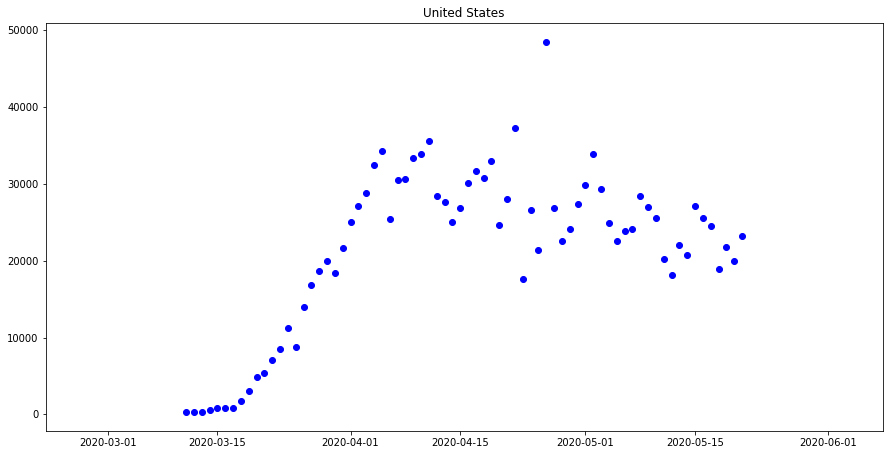

<Figure size 432x288 with 0 Axes>

<Figure size 1080x540 with 0 Axes>

In [85]:
max_cases=df_matrix_new_cases.sum(axis = 0, skipna = True)
top_twenty_new_cases=max_cases.sort_values()[-20:].index

scatterCases(top_twenty_new_cases,df_matrix_new_cases,200,False)

At a first glance, it seems there is a similarity between some countries. Try to plot in the same graph some of the countries that seem to be similar.

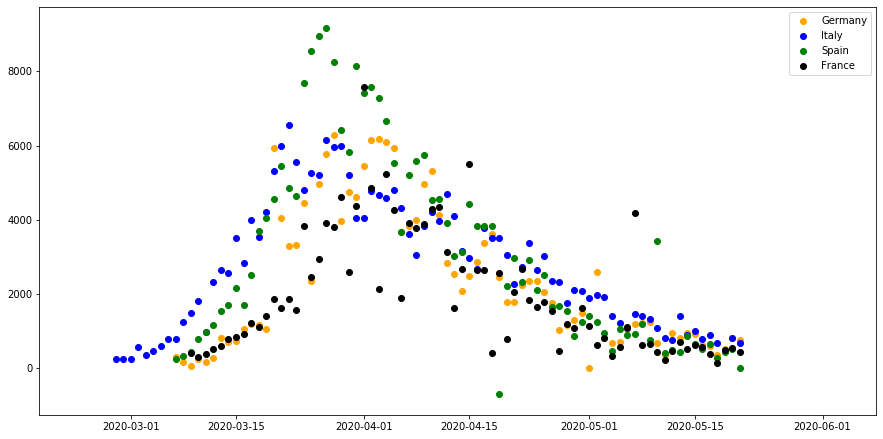

In [86]:
listC=['Germany','Italy','Spain','France']
def scatterSimilar(listC):
    plt.figure(figsize=(15,7.5))
    for country in listC:
       
        for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                 matrix=df_matrix_new_cases[country][i:]
                 break
        
        plt.scatter(matrix.index,matrix,color=colorMapWorld[country],label=country)
    plt.legend()        
scatterSimilar(listC)

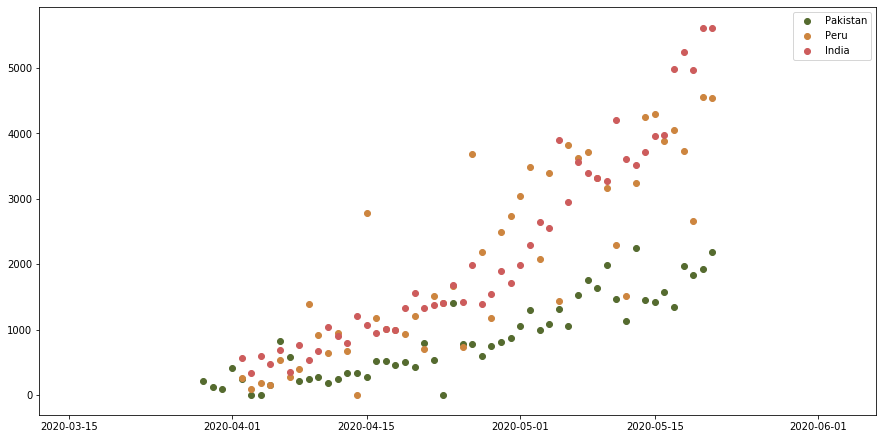

In [87]:
listC=['Pakistan','Peru','India']
scatterSimilar(listC)

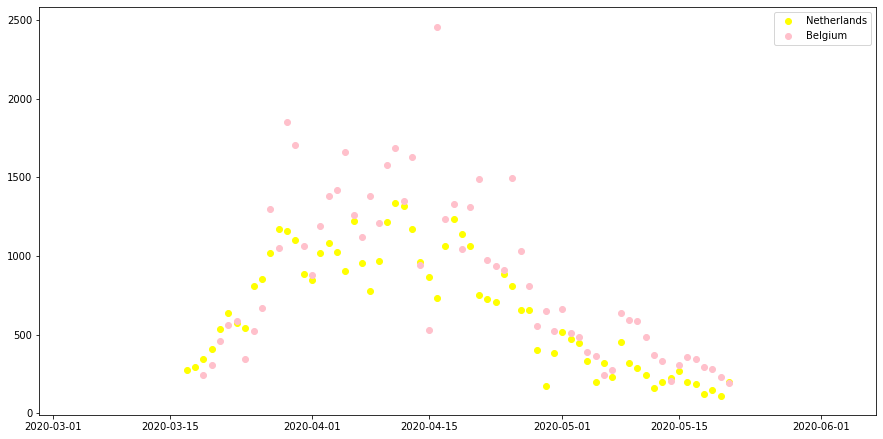

In [88]:
listC=['Netherlands','Belgium']
scatterSimilar(listC)

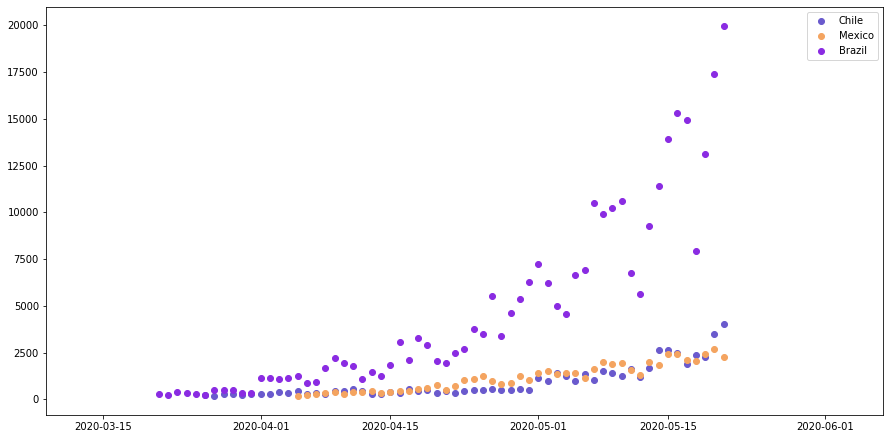

In [89]:
listC=['Chile','Mexico','Brazil']
scatterSimilar(listC)

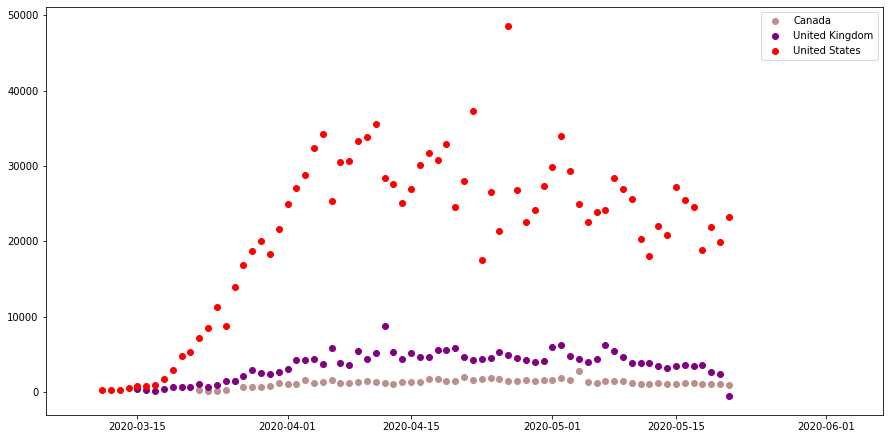

In [90]:
listC=['Canada','United Kingdom','United States']
scatterSimilar(listC)

The initial intuition seems to be correct. 
Now, let's filter all the countries that exceeded the threshold of 200 confirmed cases and count how many are and how many days are elapsed from the first day where the threshold of 200 cases was passed. The threshold has been set empirically, always from an intuition that came out in the visualization phase of the project.

In [91]:
array=[]
justNumbers=[]
for country in df_matrix_new_cases.columns:
    for i in range(0,len(df_matrix_new_cases[country])):
            if(df_matrix_new_cases[country][i]>200):
                 array.append((country,len(df_matrix_new_cases[country][i:])))
                 justNumbers.append(len(df_matrix_new_cases[country][i:]))
                 break
print(array)
print("\nNumber of countries with more than 200 cases in a day:",len(array))

[('Afghanistan', 21), ('Argentina', 26), ('Armenia', 5), ('Australia', 61), ('Austria', 67), ('Azerbaijan', 2), ('Bahrain', 38), ('Bangladesh', 37), ('Belarus', 43), ('Belgium', 64), ('Bolivia', 19), ('Brazil', 62), ('Cameroon', 48), ('Canada', 61), ('Chile', 57), ('China', 119), ('Colombia', 44), ('Denmark', 71), ('Djibouti', 1), ('Dominican Republic', 51), ('Ecuador', 62), ('Egypt', 47), ('Finland', 47), ('France', 74), ('Germany', 76), ('Ghana', 32), ('Honduras', 14), ('Hungary', 42), ('India', 50), ('Indonesia', 45), ('Iran', 82), ('Ireland', 59), ('Israel', 63), ('Italy', 84), ('Japan', 50), ('Kazakhstan', 38), ('Kuwait', 27), ('Luxembourg', 58), ('Malaysia', 59), ('Mexico', 47), ('Moldova', 37), ('Morocco', 47), ('Netherlands', 66), ('Nigeria', 21), ('Norway', 71), ('Oman', 38), ('Pakistan', 54), ('Panama', 43), ('Peru', 50), ('Philippines', 54), ('Poland', 54), ('Portugal', 62), ('Qatar', 71), ('Romania', 55), ('Russia', 54), ('Saudi Arabia', 58), ('Serbia', 54), ('Singapore', 4

Plot the distrubution of the number of days elapsed from the first day when the threshold of 200 new cases has been passed to better understand what could be the threshold, in terms of number of days, to set when considering the countries to use to create the classification.

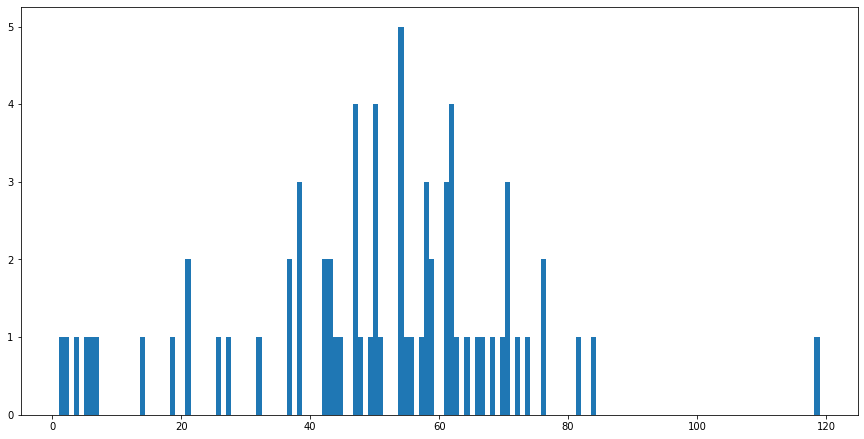

In [90]:
plt.figure(figsize=(15,7.5))
plt.hist(justNumbers, bins=150)
plt.show()

Basing on these last data, 50 days could be a good threshold to have a sufficent number of days to define a right amount of classes. Now, it is necessary to filter all the countries that have at least 60 days from the first day when the threshold of 200 cases has been passed. The index is number of the next dataset represent the days elapsed from the threshold, the columns the country filtered and the value in each row is the number of new cases in a specific day.

In [92]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                 if (couple[1]>=50):
                     filtered_new_cases[couple[0]]=np.array(df_matrix_new_cases[couple[0]][i:i+50])
                     break

filtered_new_cases.head()

,China,Italy,Iran,Germany,Spain,France,United States,Denmark,Norway,Qatar,...,Pakistan,Philippines,Poland,Russia,Serbia,Dominican Republic,India,Japan,Peru,Ukraine
0,259,250,205,284,233,410,271,252,212,238,...,211,272,249,228,202,208,568,225,258,245
1,441,238,385,163,330,286,287,160,132,0,...,118,343,224,270,82,175,336,439,91,10
2,665,240,523,55,433,372,351,128,0,58,...,99,666,193,302,0,96,601,318,181,183
3,787,561,835,237,772,497,511,23,286,17,...,414,0,256,501,159,108,472,336,151,109
4,1753,347,586,157,975,595,777,48,170,64,...,252,227,243,440,160,90,693,383,535,155


Now, for each country has been created a polynomial regression model that seems to fit well the trend on the new cases. But first, it is necessary to detect which could be the right degree for the polynomial regression function. Take in example Italy country and try to compute the model with different degrees.
First with degree equal to 3.

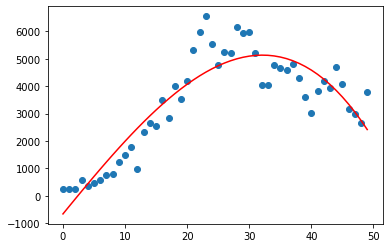

In [96]:
poly_features=PolynomialFeatures(degree=3,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()

linear_reg.fit(x_poly,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
plt.plot(predI,color='red')

Now try with degree equal to 4.

Italy


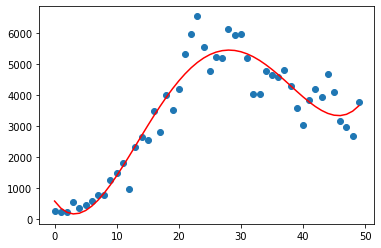

In [100]:
poly_features = PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

linear_reg=LinearRegression()
linear_reg.fit(x_poly_,filtered_new_cases['Italy'])
predI = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Italy'])
print("Italy")
plt.plot(predI,color='red')

Looking to these graph, maybe the right degree would be between 3 and 4, but, because a choice between these two value has to be done, we decide to select the degree 4 that better fit the data.
Let's compute the same trial with other countries to validate the degree of the polynomial function.

Spain


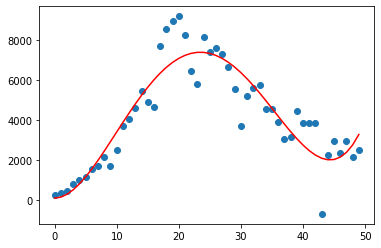

In [101]:
linear_reg=LinearRegression()
linear_reg.fit(x_poly,filtered_new_cases['Spain'])
predS = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Spain'])
print("Spain")
plt.plot(predS,color='red')

Germany


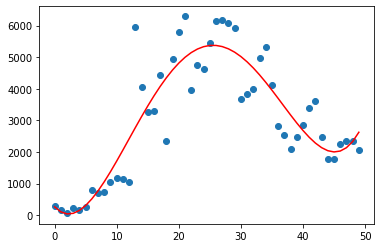

In [102]:
linear_reg=LinearRegression()
linear_reg.fit(x_poly,filtered_new_cases['Germany'])
predG = linear_reg.predict(x_poly)
plt.scatter(filtered_new_cases.index,filtered_new_cases['Germany'])
print("Germany")
plt.plot(predG,color='red')

It seems all the executed models perform well. 

Now, it's time to create the classes to create the supervised dataset that allow to train a model for the final prediction. Let's try to use an unsupervised algortithm such as k-means that should be a good choice when performing analysis on epidemiological data. We then plot the score of the clustering with the Elbow method and the silhouette plot to choose what should be a good number of classes.

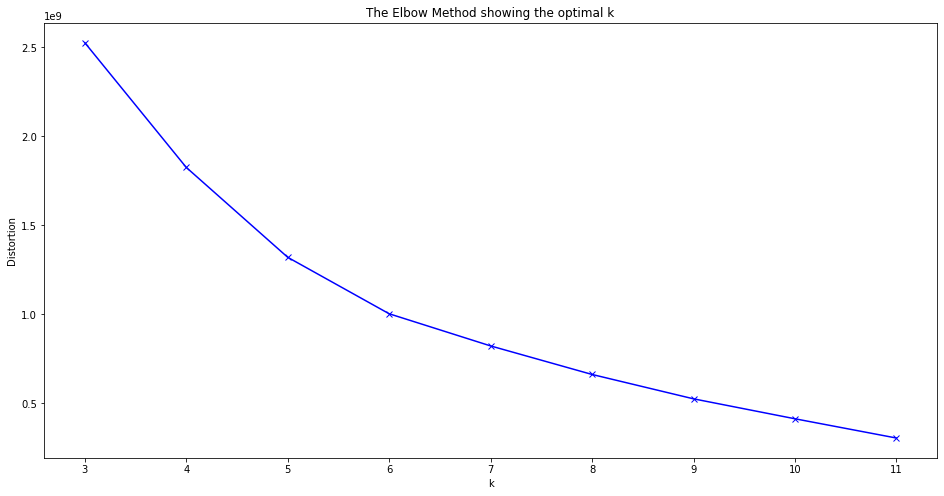

In [103]:
new_filtered_df=filtered_new_cases.transpose()
K = range(3,12)
distortions = []
for k in K:
    kmeanModel = KMeans(n_clusters=k,random_state=10)
    kmeanModel.fit(new_filtered_df)
    distortions.append(kmeanModel.inertia_)
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

For n_clusters = 7 The average silhouette_score is : 0.39655123866646197
For n_clusters = 8 The average silhouette_score is : 0.4106908211724944
For n_clusters = 9 The average silhouette_score is : 0.41543791048896694
For n_clusters = 10 The average silhouette_score is : 0.41281879551803513
For n_clusters = 11 The average silhouette_score is : 0.4215173097532947


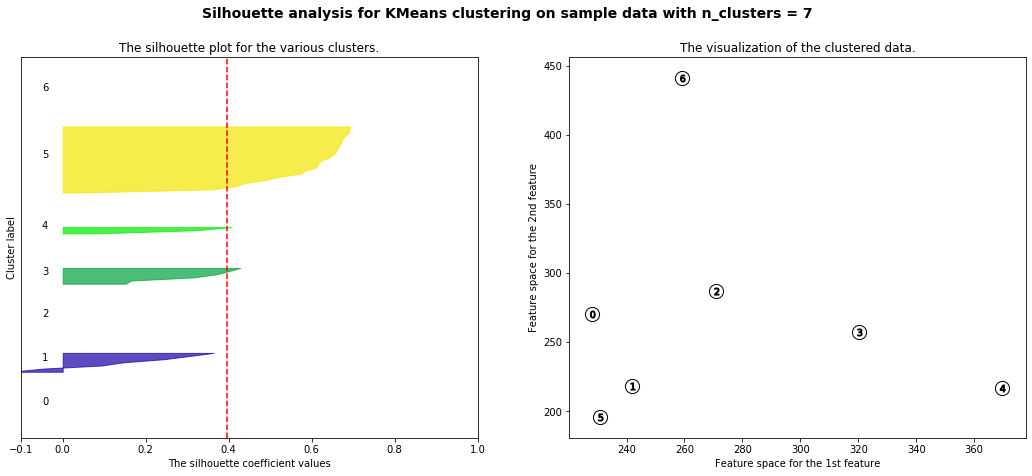

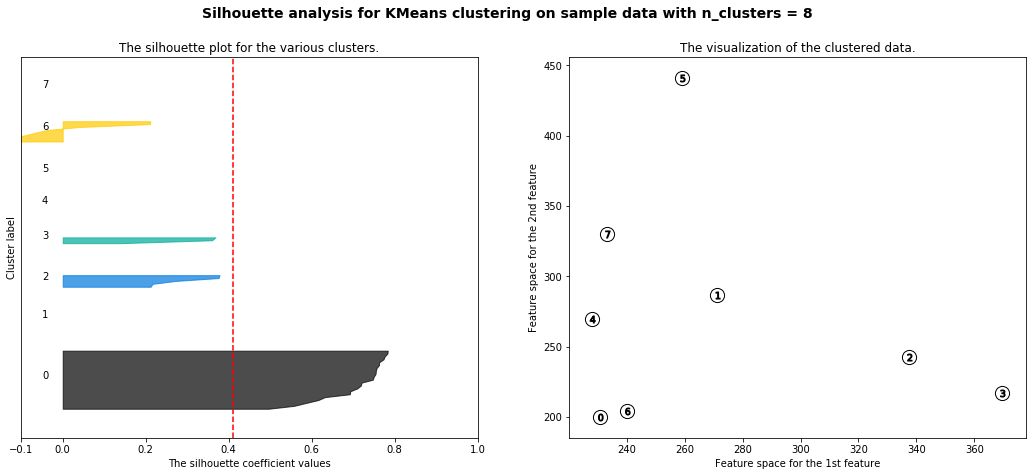

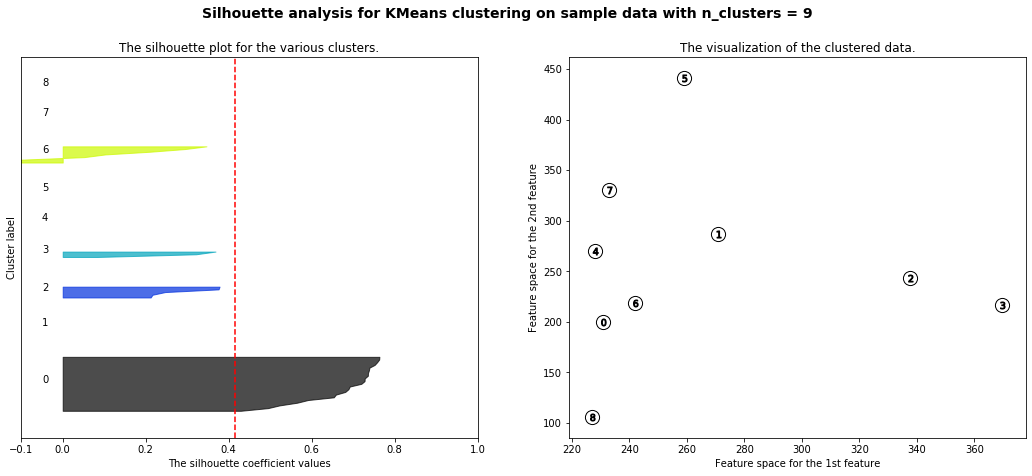

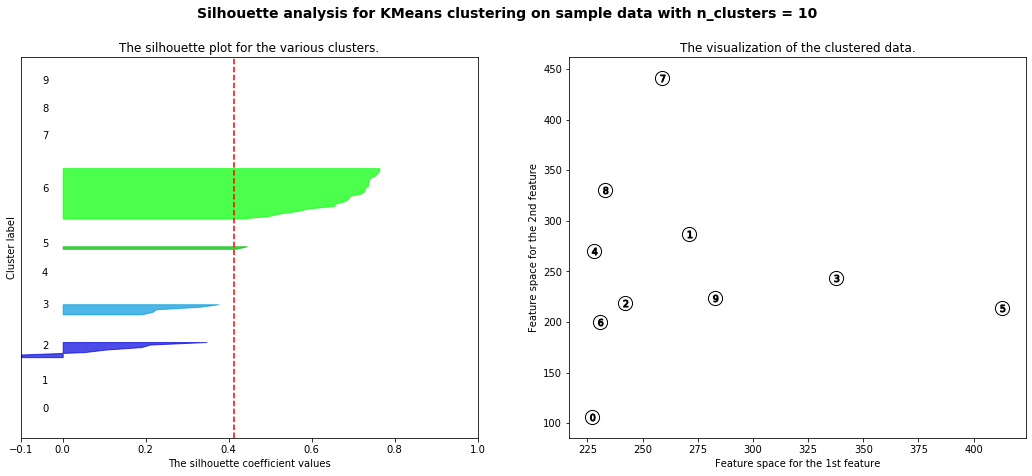

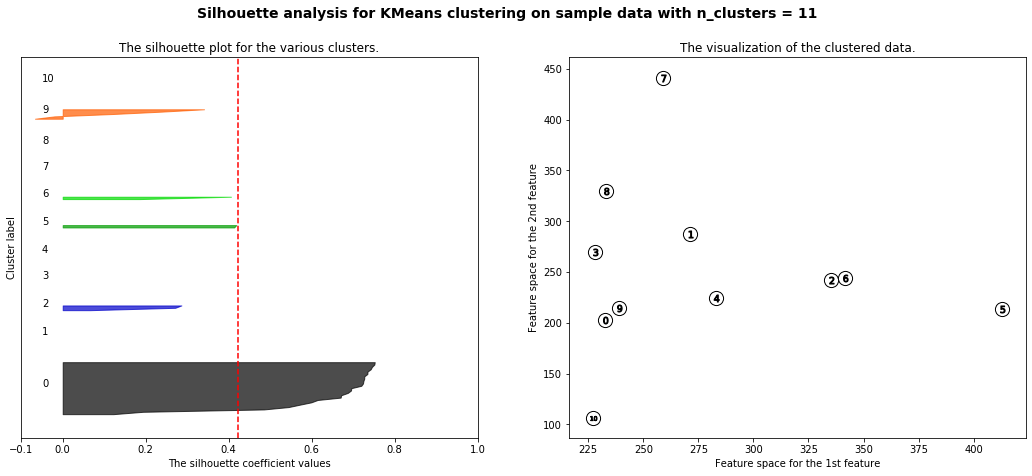

In [104]:
range_n_clusters = [7,8,9,10,11]
for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(new_filtered_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    km=KMeans(n_clusters=n_clusters,n_jobs=4,random_state=0)
    cluster_labels=km.fit(new_filtered_df)
    predict=cluster_labels.predict(new_filtered_df)
    silhouette_avg = silhouette_score(new_filtered_df, predict)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(new_filtered_df, predict)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[predict == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(predict.astype(float) / n_clusters)
    #ax2.scatter(filtered_new_cases.transpose().index, filtered_new_cases.transpose().columns, marker='.', s=30, lw=0, alpha=0.7,
    #            c=colors, edgecolor='k')

    # Labeling the clusters
    centers = km.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()


In [107]:
n_cl=9 #number of clusters
km=KMeans(n_clusters=n_cl,n_jobs=4,random_state=10)
km.fit(new_filtered_df)
predict=km.predict(new_filtered_df)
predict

array([6, 3, 1, 3, 7, 3, 0, 5, 5, 5, 5, 3, 5, 1, 1, 5, 2, 8, 5, 3, 5, 1,
       5, 5, 5, 5, 1, 5, 1, 5, 5, 1, 5, 5, 4, 5, 5, 2, 5, 2, 5])

In [116]:
i=0
new_classes_km=[[] for i in range(0,n_cl)]
for country in filtered_new_cases.columns:
    new_classes_km[predict[i]].append(country)
    i=i+1
    
new_classes_km    

[['United States'],
 ['Iran',
  'Netherlands',
  'Belgium',
  'Canada',
  'Saudi Arabia',
  'Chile',
  'Pakistan'],
 ['Brazil', 'India', 'Peru'],
 ['Italy', 'Germany', 'France', 'United Kingdom', 'Turkey'],
 ['Russia'],
 ['Denmark',
  'Norway',
  'Qatar',
  'Switzerland',
  'Austria',
  'Israel',
  'Portugal',
  'Australia',
  'Thailand',
  'Ireland',
  'Malaysia',
  'Luxembourg',
  'Sweden',
  'South Africa',
  'Romania',
  'Philippines',
  'Poland',
  'Serbia',
  'Dominican Republic',
  'Japan',
  'Ukraine'],
 ['China'],
 ['Spain'],
 ['Ecuador']]

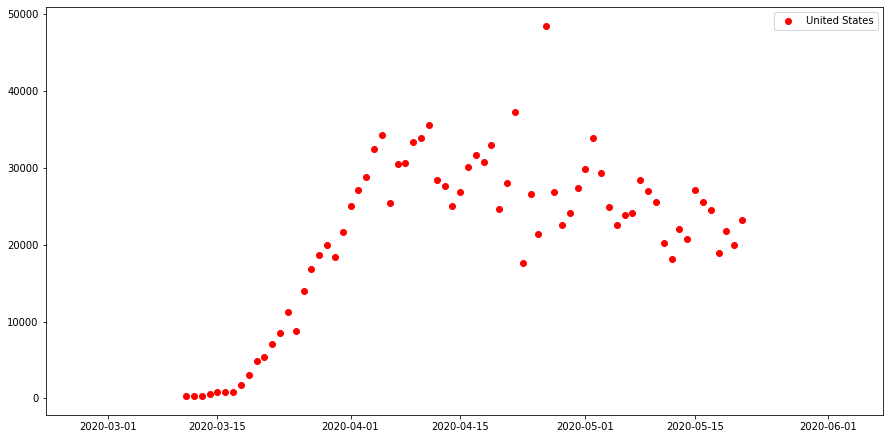

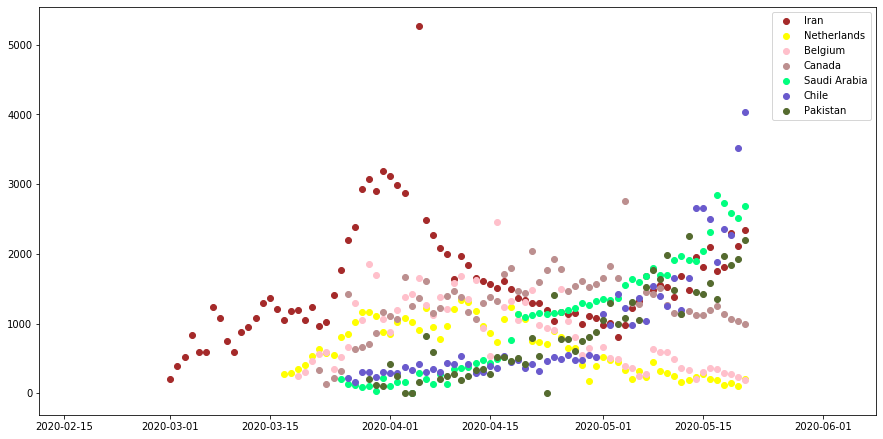

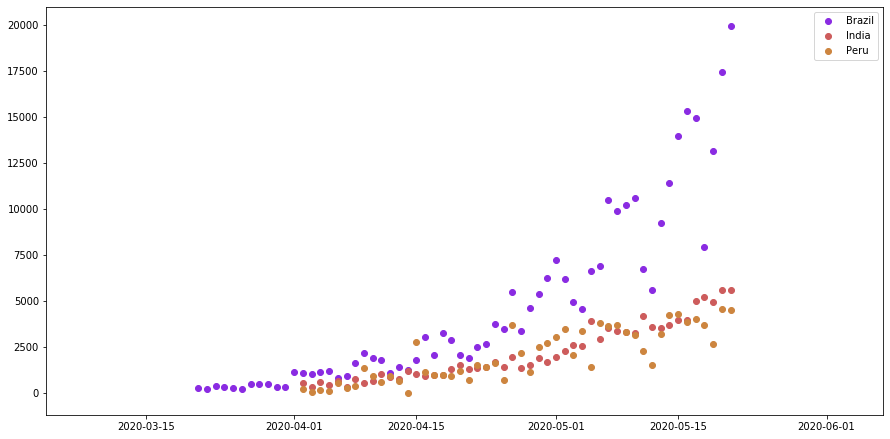

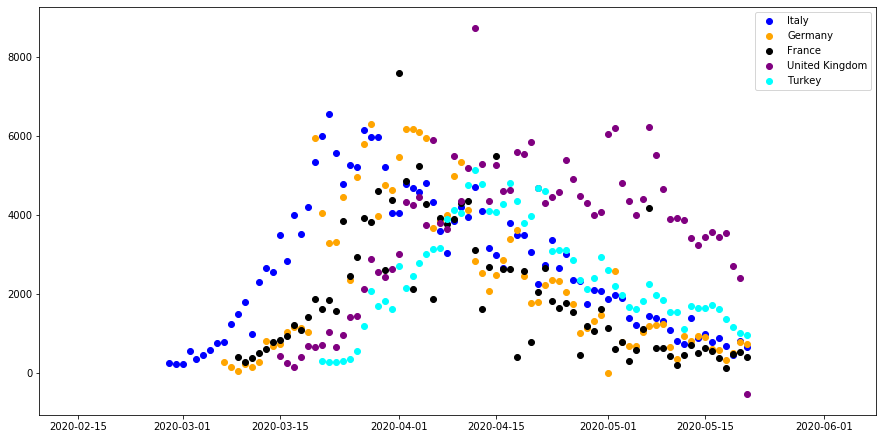

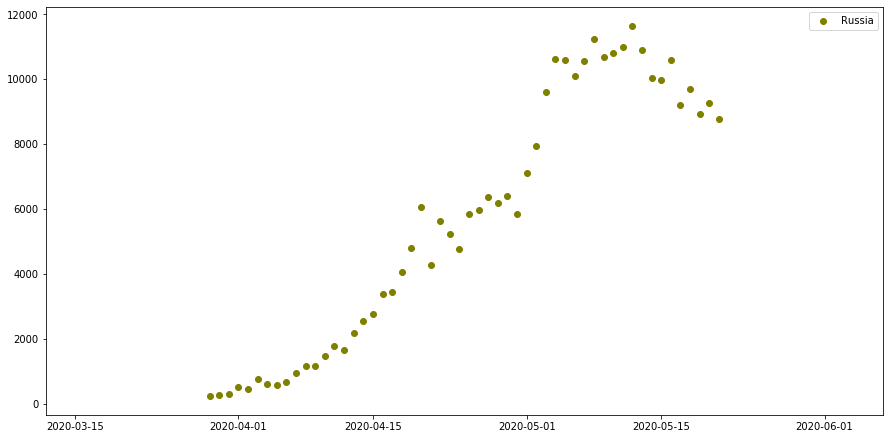

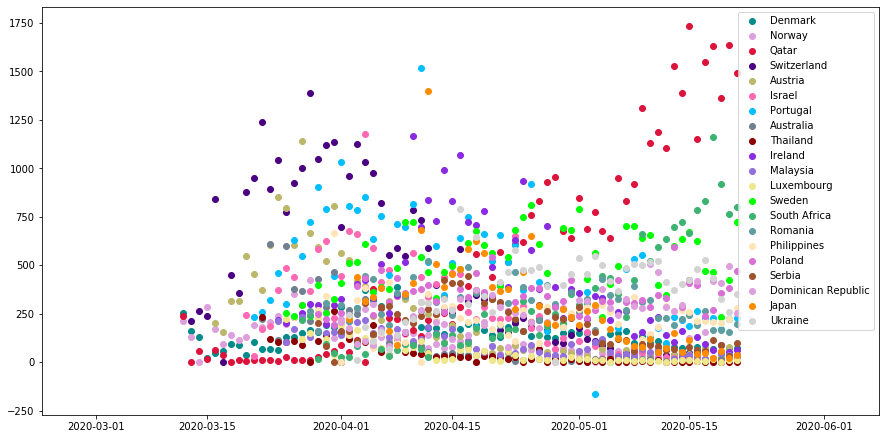

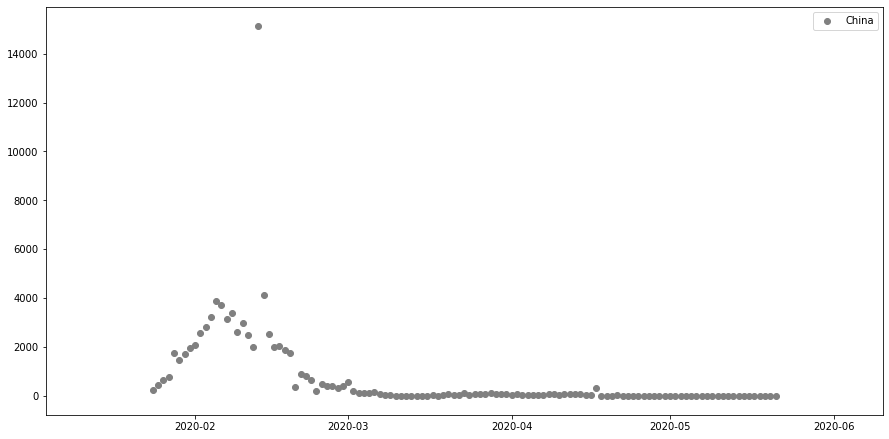

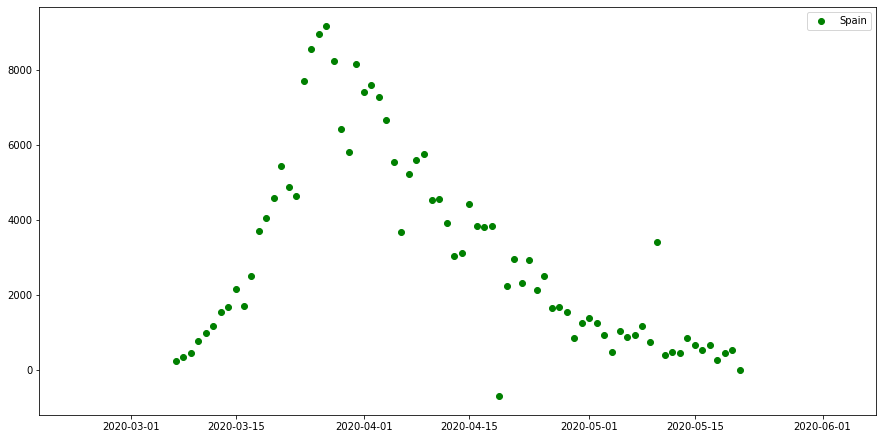

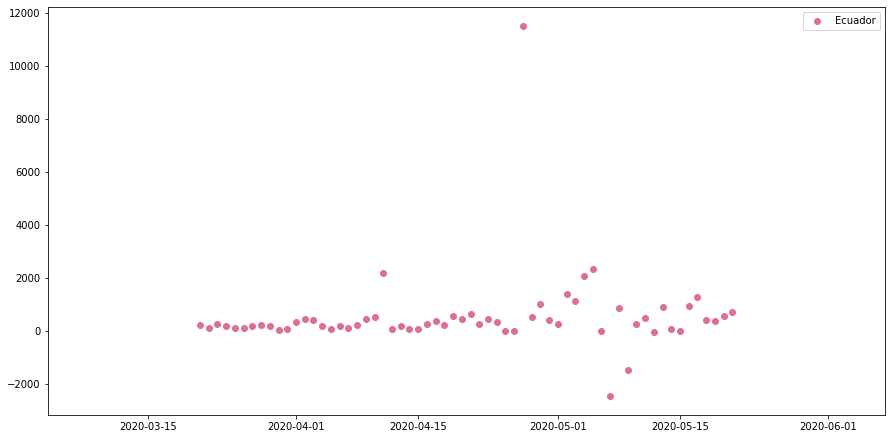

In [117]:
for c in new_classes_km:
        scatterSimilar(c)

Now, let's add to our dataset the classification label for each country. In this way we can then performs the training of a supervised learning algorith.

In [138]:
groups=[]
inserted=False
for country in new_filtered_df.index:
    for i in range(0,len(new_classes_km)):
        if country in new_classes_km[i]:
            groups.append(i)
            inserted=True
            break
    

new_filtered_df['Cases trend group']=groups
new_filtered_df.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,Cases trend group
China,259,441,665,787,1753,1466,1740,1980,2095,2590,...,117,170,101,46,45,20,29,24,22,6
Italy,250,238,240,561,347,466,587,769,778,1247,...,3836,4204,3951,4694,4092,3153,2972,2667,3786,3
Iran,205,385,523,835,586,591,1234,1076,743,595,...,1972,1837,1657,1617,1574,1512,1606,1499,1374,1
Germany,284,163,55,237,157,271,802,693,733,1043,...,3380,3609,2458,1775,1785,2237,2352,2337,2055,3
Spain,233,330,433,772,975,1153,1531,1683,2144,1706,...,3818,3836,-713,2218,2951,2312,2916,2114,2506,7


Now, let's split the dataset in train and test with a test percentage of 30%.

In [120]:
dataForTheModel=new_filtered_df[range(0,50)][0:len([val for sublist in new_classes_km for val in sublist])]
#put the range to make a classifier for a specific day
labels=new_filtered_df['Cases trend group'][0:len([val for sublist in new_classes_km for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0)

The supervised algorthm we want to use for the prediction is a decision tree. Decision tree fit very well in classification task. Other advantages are that it does not require normalization of data and scaling of data too.
We use the GridSearch function to evaluate which are the parameters that better performs. We choose between different number of components, different max depths and different criterions.

In [139]:
sc = StandardScaler()
# Create a pca object
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree =DecisionTreeClassifier()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X_train.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X_train,y_train)

# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])


Best Criterion: entropy
Best max_depth: 4
Best Number Of Components: 21

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=4, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


The grid search suggest to use the entropy as best criterion, 4 as best max depth of the tree and 21 as best number of components, between the ones we have passed as parameter.

Now, let's train and test a decision tree to predict the class of the countries with 50 days from the 200 new cases threshold.

In [141]:
clf_50 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=6)

# Train Decision Tree Classifer
clf_50 = clf_50.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_50.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7692307692307693


The accuracy is not so bad.

Now, let's make the train and test a decision tree to predict 3 days more than 47.

In [142]:
dataForTheModel=new_filtered_df[range(0,47)][0:len([val for sublist in new_classes_km for val in sublist])]
labels=new_filtered_df['Cases trend group'][0:len([val for sublist in new_classes_km for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0)

In [144]:
clf_47 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=8)

# Train Decision Tree Classifer
clf_47 = clf_47.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_47.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8461538461538461


Also in this case the accuracy of the test prediction is not so bad.

Now, let's train and test a decision tree to predict 12 days than the 38th day from the threshold.

In [145]:
dataForTheModel=new_filtered_df[range(0,38)][0:len([val for sublist in new_classes_km for val in sublist])]
labels=new_filtered_df['Cases trend group'][0:len([val for sublist in new_classes_km for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0)

In [146]:
clf_38 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=8)

# Train Decision Tree Classifer
clf_38 = clf_38.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_38.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7692307692307693


Now, let's build a dataset with all the countries that we temporaly discared. These countries have not reached the 50th day from the threshold and we can use them to predict the remaining day. We will use our classifiers to get the class that better fit the trend of the country under prediction and then we will plot the originally dataset of the country and the prediction for the period of 50 days.

In [147]:
threshold_cases=pd.DataFrame()
for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                     threshold_cases[couple[0]]=df_matrix_new_cases[couple[0]][i:]
                     
                     if(couple[0]==array[0][0]):
                         index=len(df_matrix_new_cases[couple[0]][i:])
                     break

                

threshold_cases.index=range(0,index)
threshold_cases=threshold_cases.transpose()

for i in range(0,len(threshold_cases.index)):
     while(True):
        if(math.isnan(threshold_cases[0][i])):
                threshold_cases[0:][i:]=threshold_cases[0:][i:].shift(-1,axis=1)
        else:
            break

threshold_cases.head()

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
China,259.0,441.0,665.0,787.0,1753.0,1466.0,1740.0,1980.0,2095.0,2590.0,...,1.0,7.0,6.0,5.0,9.0,6.0,10.0,9.0,2.0,2.0
Italy,250.0,238.0,240.0,561.0,347.0,466.0,587.0,769.0,778.0,1247.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iran,205.0,385.0,523.0,835.0,586.0,591.0,1234.0,1076.0,743.0,595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,284.0,163.0,55.0,237.0,157.0,271.0,802.0,693.0,733.0,1043.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spain,233.0,330.0,433.0,772.0,975.0,1153.0,1531.0,1683.0,2144.0,1706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [130]:
test=threshold_cases[range(0,38)][1:2] #put the country row between the second[], for more days change the range
print(test)

          0      1      2      3      4      5      6      7      8       9   \
Italy  250.0  238.0  240.0  561.0  347.0  466.0  587.0  769.0  778.0  1247.0   

       ...      28      29      30      31      32      33      34      35  \
Italy  ...  6153.0  5959.0  5974.0  5217.0  4050.0  4053.0  4782.0  4668.0   

           36      37  
Italy  4585.0  4805.0  

[1 rows x 38 columns]


In [131]:
ynew = clf_38.predict(test)
# show the inputs and predicted outputs

print("X=%s, Predicted=%s" % (test[0], ynew[0]))

X=Italy    250.0
Name: 0, dtype: float64, Predicted=3


CONTROLLO VISIVO PER VEDERE SE LA PREDIZIONE PUO AVERE SENSO

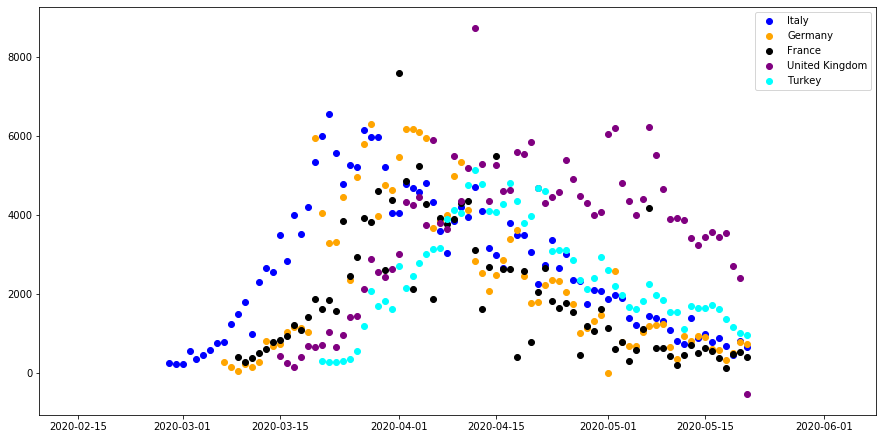

In [132]:
scatterSimilar(new_classes_km[3])#put the predicted class between []

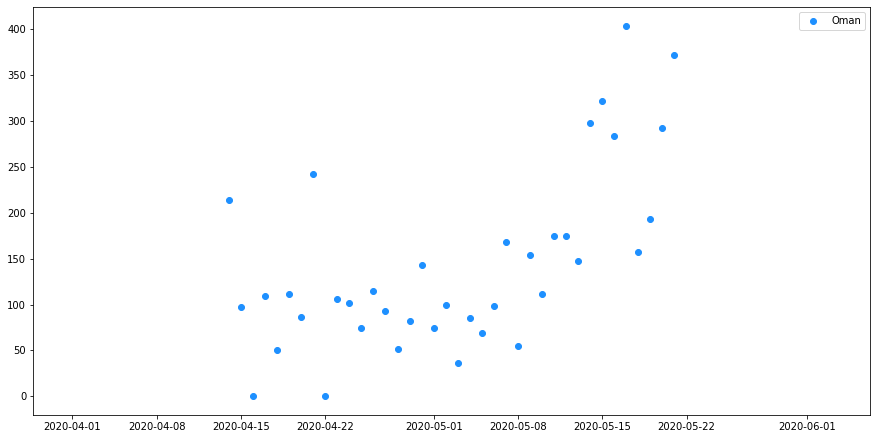

In [1336]:
scatterSimilar(['Oman']) #put the country between [] PS: VISTO CHE STIAMO USANDO L'ITALIA SAREBBE STUPIDO UNIRE I DUE GRAFICI, L'ITALIA E' Gia sul grafico

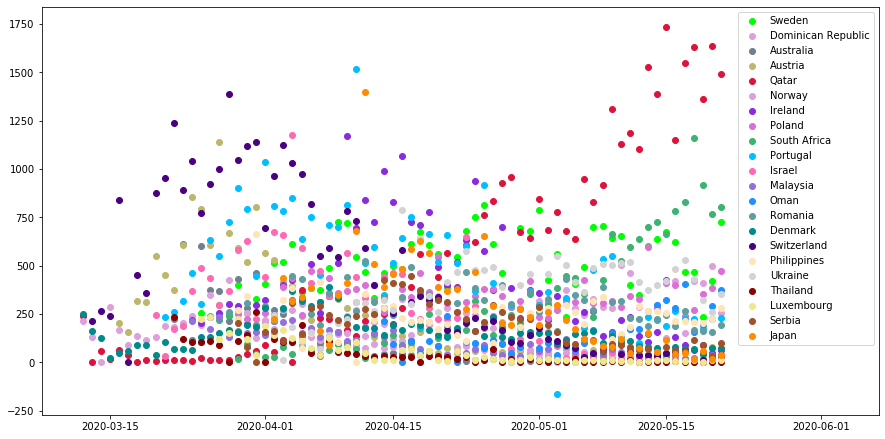

In [133]:
scatterSimilar(Union(new_classes_km[5],['Oman'])) #put the predicted class between [] and the country to put the graphs togheter

MODELLO DI REGRESSIONE DELLA CLASSE APPOSITA

In [134]:
test=threshold_cases.transpose()[new_classes_km[3]] #put the predicted class between []
test=test.transpose()
test=test[range(0,50)]
test=test.transpose()
print(test)

     Italy  Germany  France  United Kingdom  Turkey
0    250.0    284.0   410.0           433.0   311.0
1    238.0    163.0   286.0           251.0   277.0
2    240.0     55.0   372.0           152.0   289.0
3    561.0    237.0   497.0           407.0   293.0
4    347.0    157.0   595.0           680.0   343.0
5    466.0    271.0   785.0           647.0   561.0
6    587.0    802.0   838.0           706.0  1196.0
7    769.0    693.0   924.0          1035.0  2069.0
8    778.0    733.0  1210.0           665.0  1704.0
9   1247.0   1043.0  1097.0           967.0  1815.0
10  1492.0   1174.0  1404.0          1427.0  1610.0
11  1797.0   1144.0  1861.0          1452.0  2704.0
12   977.0   1042.0  1617.0          2129.0  2148.0
13  2313.0   5940.0  1847.0          2885.0  2456.0
14  2651.0   4049.0  1559.0          2546.0  2786.0
15  2547.0   3276.0  3838.0          2433.0  3013.0
16  3497.0   3311.0  2446.0          2619.0  3135.0
17  2823.0   4438.0  2931.0          3009.0  3148.0
18  4000.0  

GRAFICHIAMO LA PREDIZIONE DEL DECISION TREE E L'EFFETTIVA CURVA POLINOMIALE

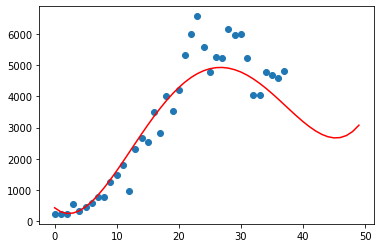

In [150]:
plt.scatter(range(0,38),threshold_cases.transpose()['Italy'][0:38]) #put the country you want to check between [], change the range for more or less days

poly_y=test.mean(axis=1)

poly_features=PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(test.index).reshape(-1, 1))


linear_reg=LinearRegression()


linear_reg.fit(x_poly,poly_y)


predI = linear_reg.predict(x_poly)







plt.plot(predI,color='red')


.









.









# MSE approach

Now, basing on the previous assumption, it is necessary to create a polynomial model for each country and divide them in groups. The output of the next phase will be the groups created for simililarity of the models. 

In [1108]:
classes=[]
for i in range(0,len(filtered_new_cases.columns)):
    
    linear_regI=LinearRegression()
    
    linear_regI.fit(x_poly,filtered_new_cases[filtered_new_cases.columns[i]])
    predI = linear_regI.predict(x_poly)
    classe=[filtered_new_cases.columns[i]]
    
    '''
    plt.scatter(filtered_new_cases.index,filtered_new_cases[filtered_new_cases.columns[i]])
    plt.plot(predI,color='red')
    '''
    for j in range(i+1,len(filtered_new_cases.columns)):
        linear_regE=LinearRegression()
    
        linear_regE.fit(x_poly,filtered_new_cases[filtered_new_cases.columns[j]])
        
        predE = linear_regE.predict(x_poly)
        
        if (mean_squared_error(predI,predE)<=3000000):
            classe.append(filtered_new_cases.columns[j])
    classes.append(classe)          

In [1109]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def checkMSE(country1,country2):
    linear_regI=LinearRegression()
    
    linear_regI.fit(x_poly,filtered_new_cases[country1])
    predI = linear_regI.predict(x_poly)
    linear_regE=LinearRegression()
    
    linear_regE.fit(x_poly,filtered_new_cases[country2])
    predE = linear_regE.predict(x_poly)
    return mean_squared_error(predI,predE)

def Union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list 



              

for c in classes:
    for d in classes:
       
        inter=intersection(c,d)
        
        if(len(c)==1):
            continue
        if(len(d)==1):
            continue
        if(len(inter)==len(c)==len(d) or len(inter)==0):
            continue
        else:
             for e in inter:
                    if(e==d[0]):
                        if(len(d)==1):
                            continue
                        if(checkMSE(c[0],e)<= checkMSE(d[1],e)):
                            continue
                        else:
                            c.remove(e)
                    else:
                        if(checkMSE(c[0],e)<= checkMSE(d[0],e)):
                            continue
                        else:
                            c.remove(e)
              




            

In [1110]:
for i in range(0,len(classes)):
    for j in range(i+1,len(classes)):
        if(len(intersection(classes[i],classes[j]))>0):
            classes[i]=Union(classes[i],classes[j])
            classes[j]=[]



Now, plot the data of each class with the original countries data.

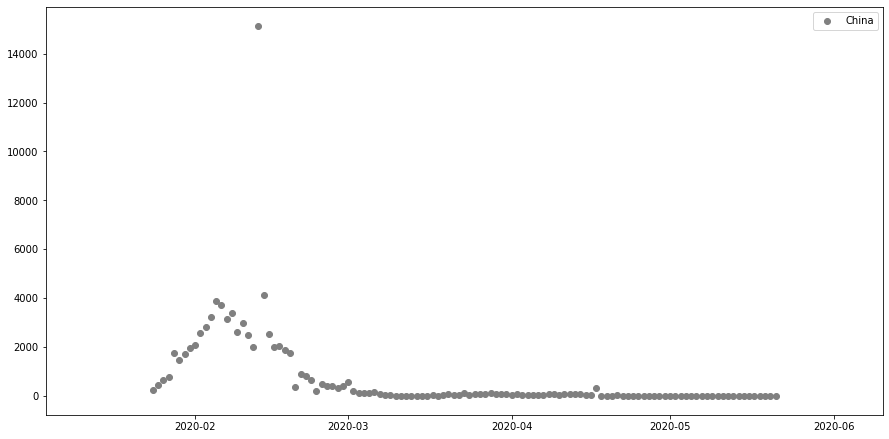

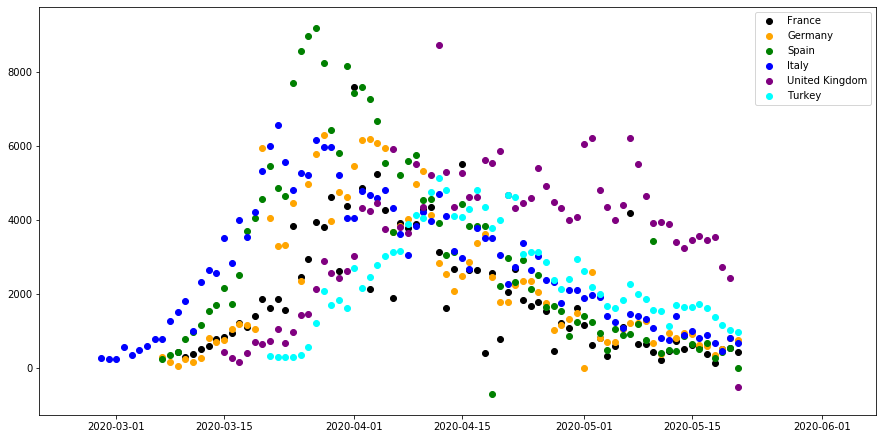

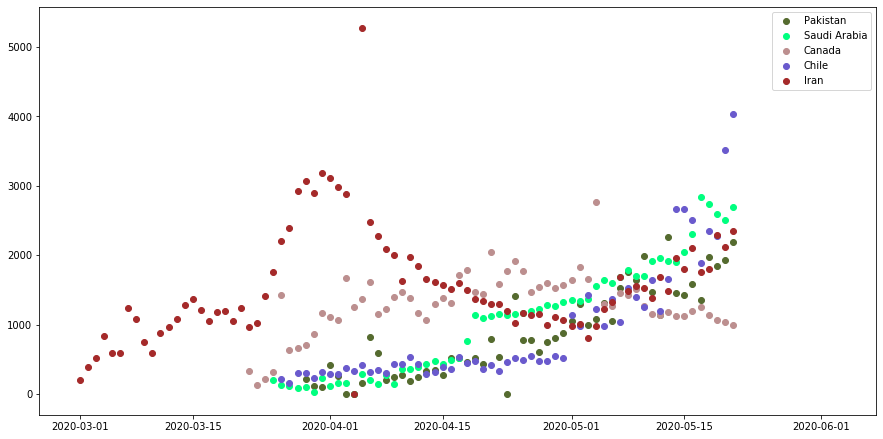

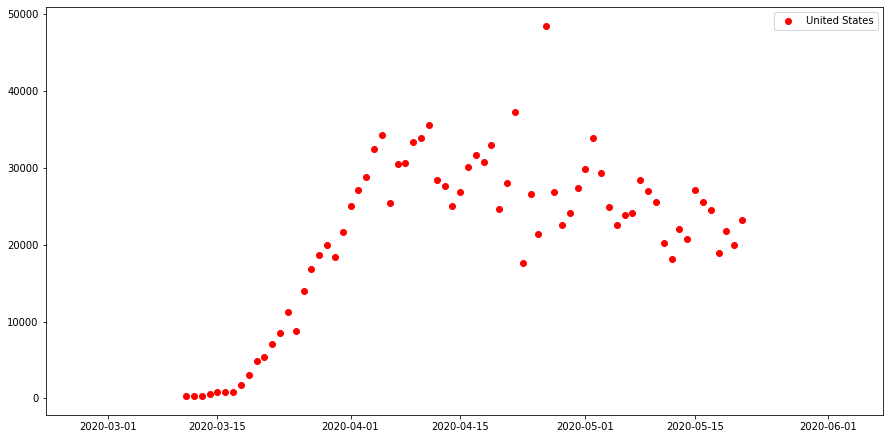

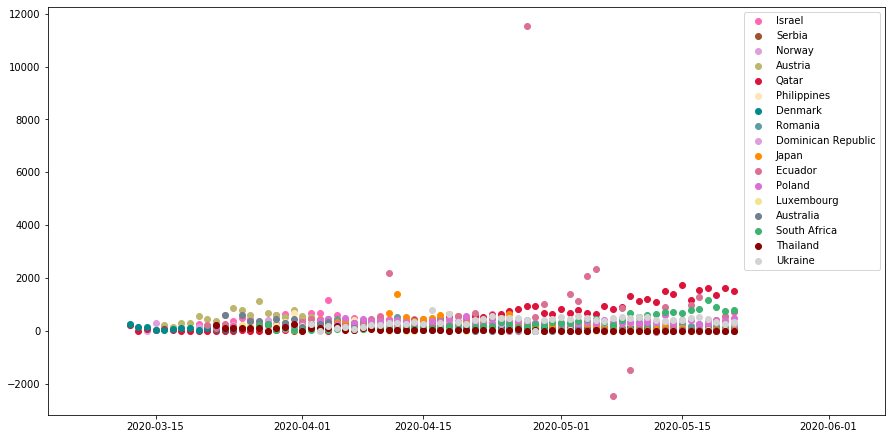

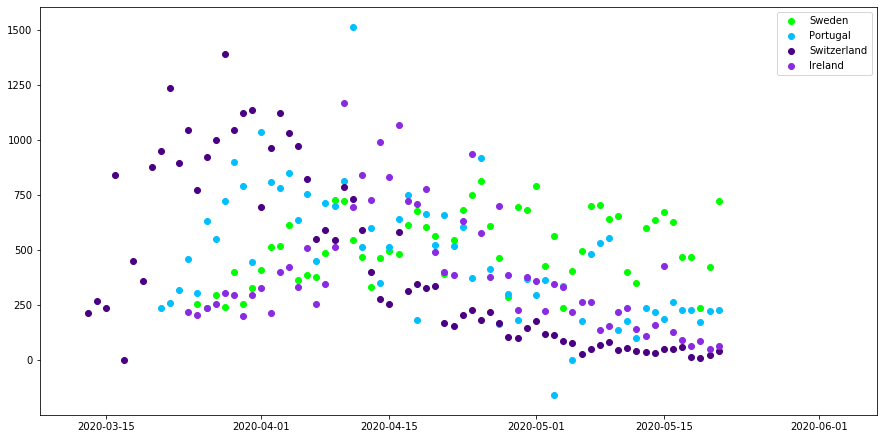

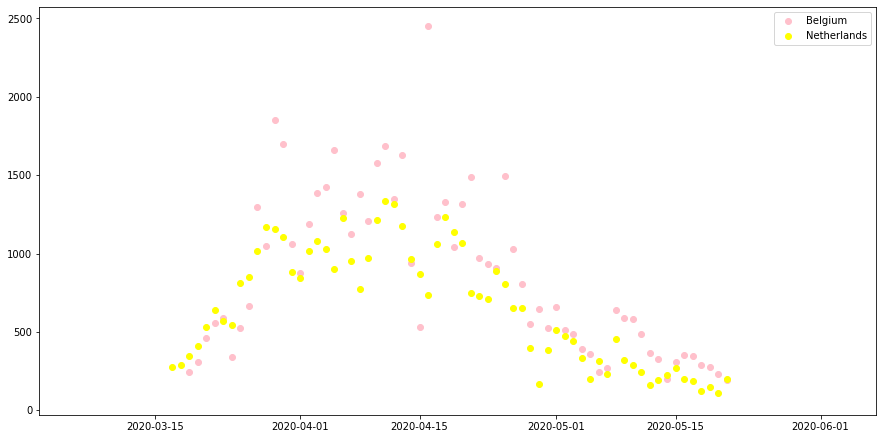

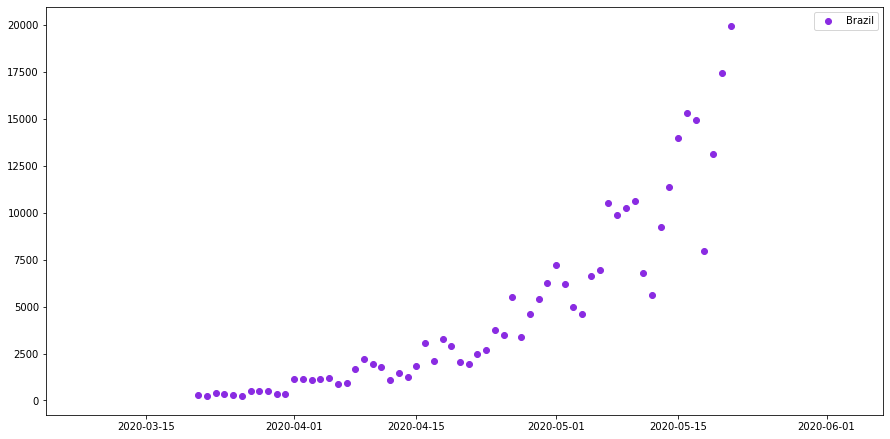

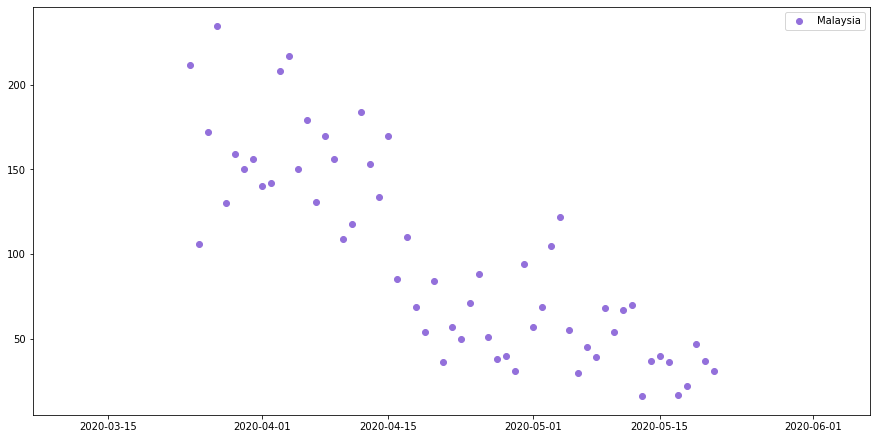

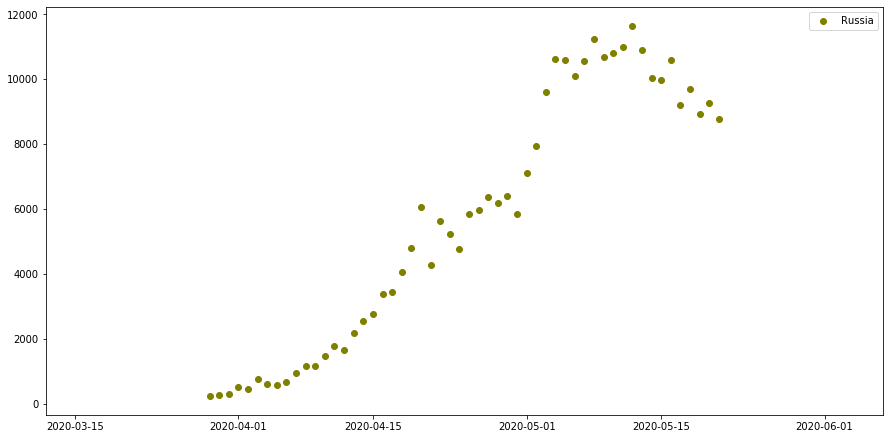

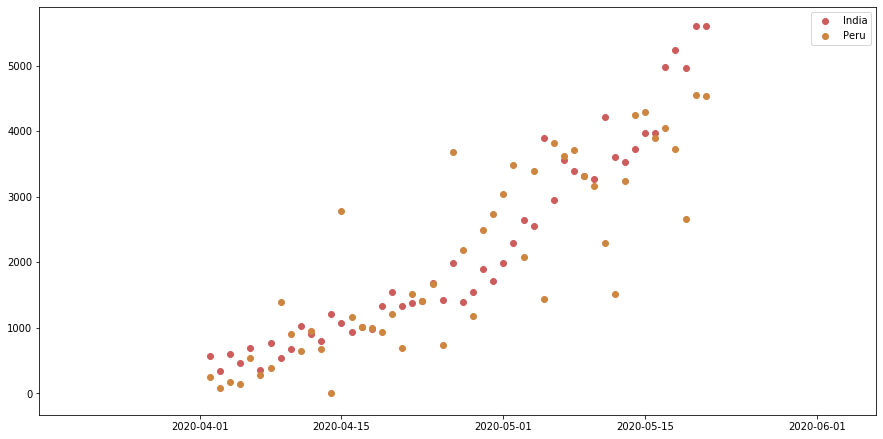

In [1111]:
new_classes=[]
for c in classes:
    if(len(c)==0):
        continue
    else:
        new_classes.append(c)
    
for c in new_classes:
        scatterSimilar(c)

It seems our classifier has worked fine.
Now, let's make the same procedure but setting a threshold for the number of days equal to 50 in place of 60, to include other countries and understanding how the algorthm works

In [1112]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                 if (couple[1]>=50):
                     filtered_new_cases[couple[0]]=np.array(df_matrix_new_cases[couple[0]][i:i+50])
                     break
                

filtered_new_cases.head()

,China,Italy,Iran,Germany,Spain,France,United States,Denmark,Norway,Qatar,...,Pakistan,Philippines,Poland,Russia,Serbia,Dominican Republic,India,Japan,Peru,Ukraine
0,259,250,205,284,233,410,271,252,212,238,...,211,272,249,228,202,208,568,225,258,245
1,441,238,385,163,330,286,287,160,132,0,...,118,343,224,270,82,175,336,439,91,10
2,665,240,523,55,433,372,351,128,0,58,...,99,666,193,302,0,96,601,318,181,183
3,787,561,835,237,772,497,511,23,286,17,...,414,0,256,501,159,108,472,336,151,109
4,1753,347,586,157,975,595,777,48,170,64,...,252,227,243,440,160,90,693,383,535,155


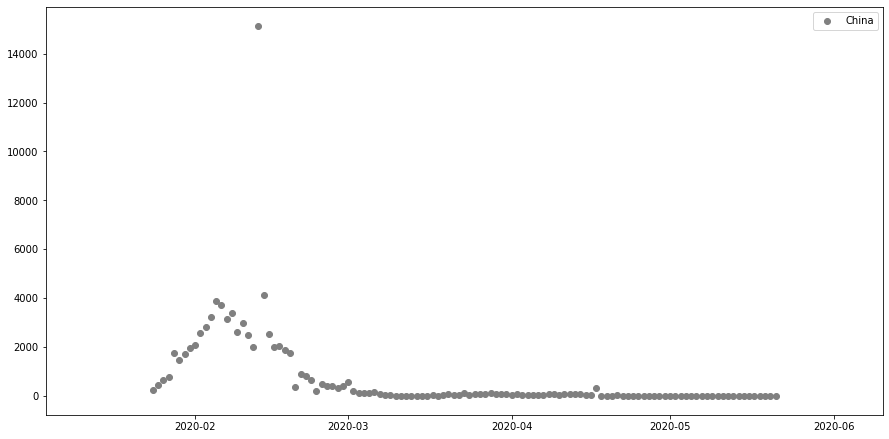

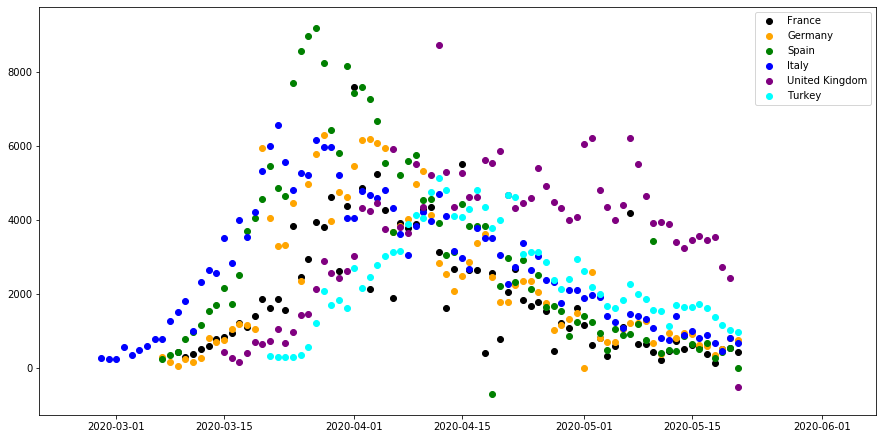

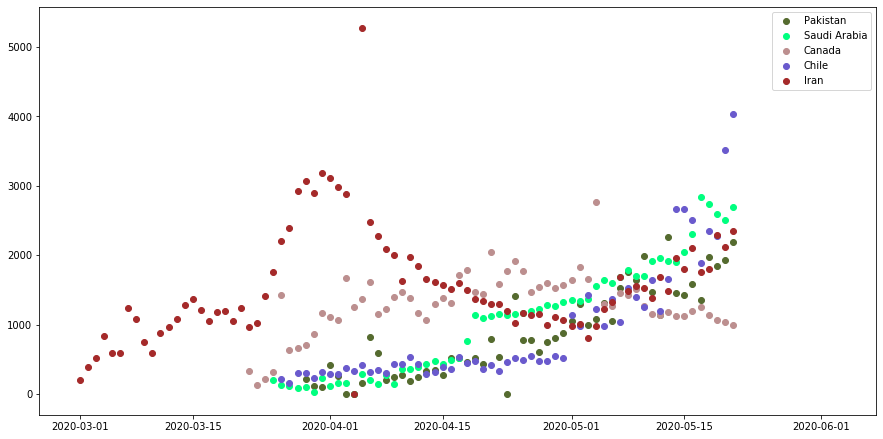

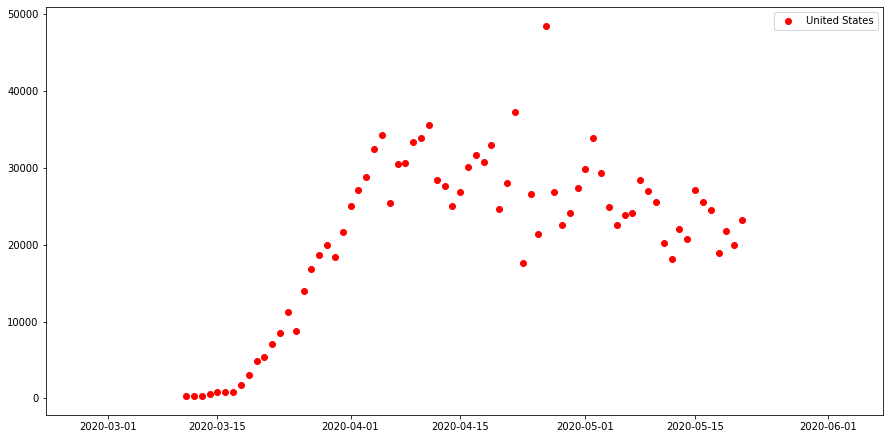

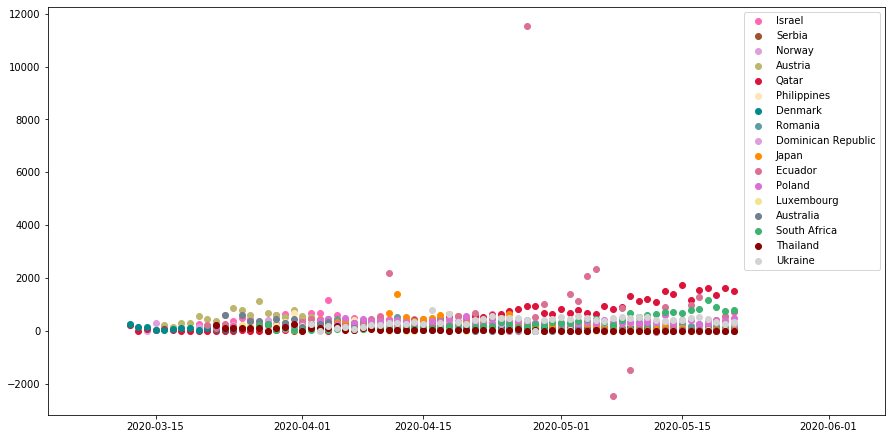

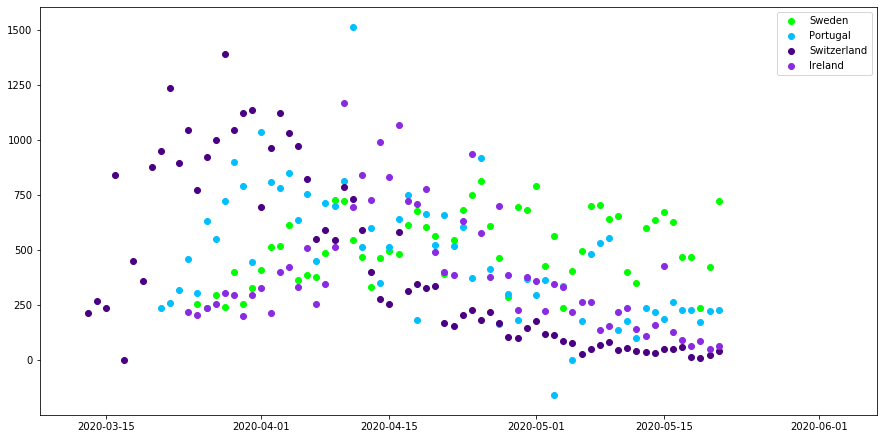

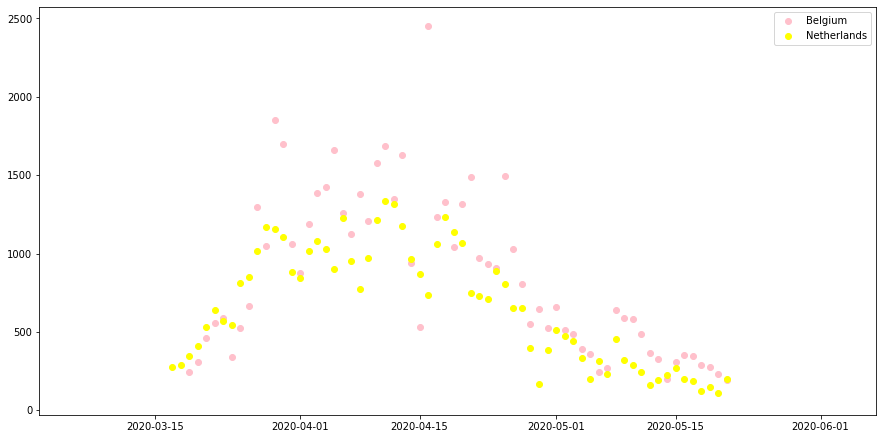

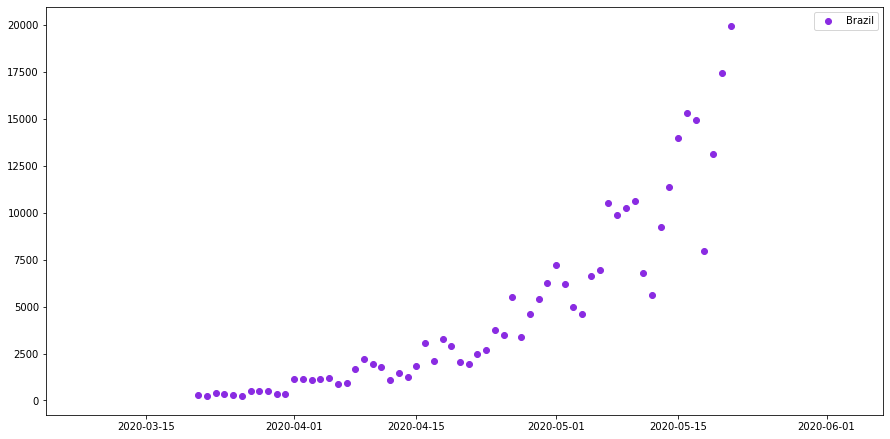

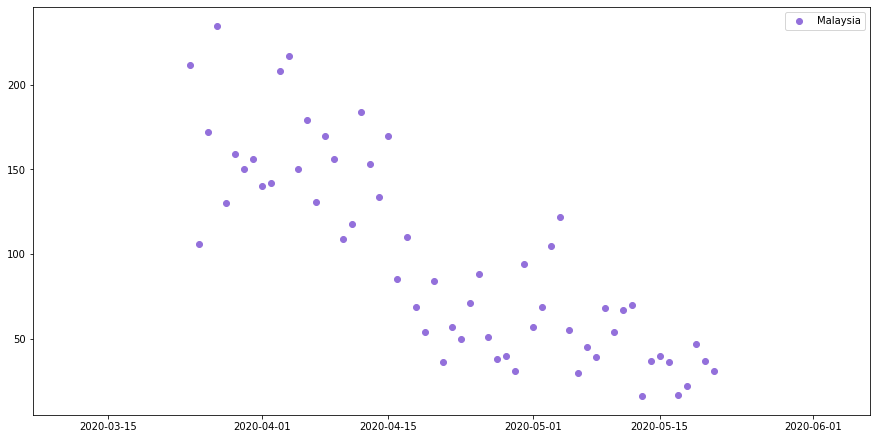

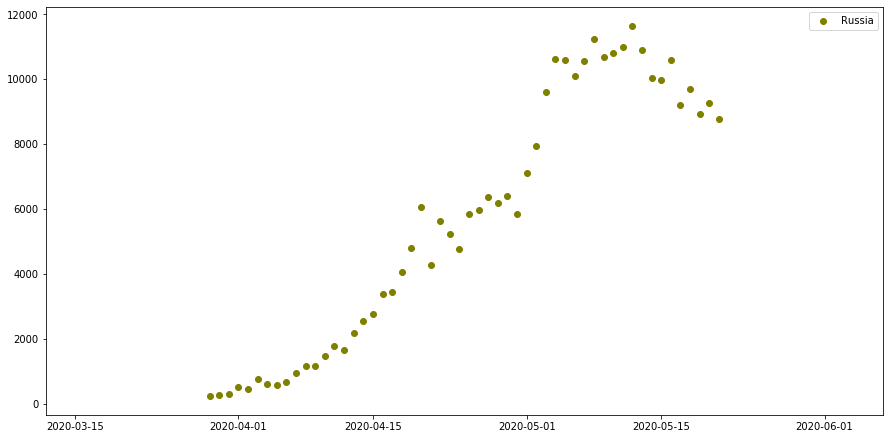

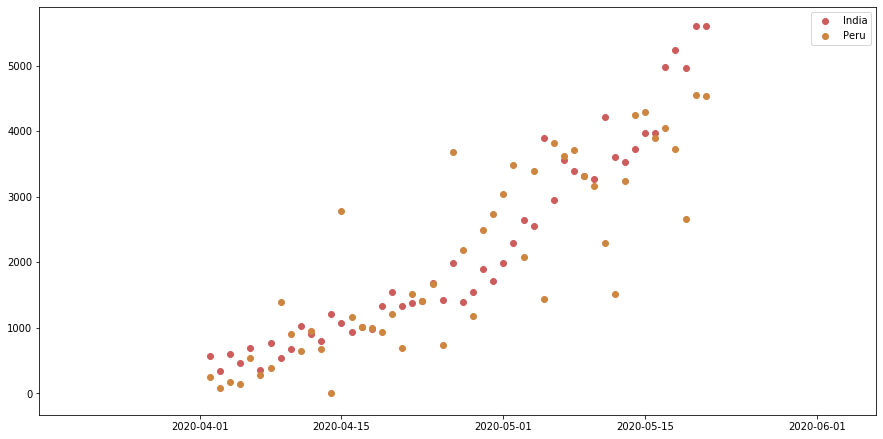

In [1113]:
poly_features=PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(filtered_new_cases.index).reshape(-1, 1))

classes=[]
for i in range(0,len(filtered_new_cases.columns)):
    
    linear_regI=LinearRegression()
    
    linear_regI.fit(x_poly,filtered_new_cases[filtered_new_cases.columns[i]])
    predI = linear_regI.predict(x_poly)
    classe=[filtered_new_cases.columns[i]]
    
    '''
    plt.scatter(filtered_new_cases.index,filtered_new_cases[filtered_new_cases.columns[i]])
    plt.plot(predI,color='red')
    '''
    for j in range(i+1,len(filtered_new_cases.columns)):
        linear_regE=LinearRegression()
    
        linear_regE.fit(x_poly,filtered_new_cases[filtered_new_cases.columns[j]])
        
        predE = linear_regE.predict(x_poly)
        
        if (mean_squared_error(predI,predE)<=3000000):
            classe.append(filtered_new_cases.columns[j])
    classes.append(classe)
classes  

def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def checkMSE(country1,country2):
    linear_regI=LinearRegression()
    
    linear_regI.fit(x_poly,filtered_new_cases[country1])
    predI = linear_regI.predict(x_poly)
    linear_regE=LinearRegression()
    
    linear_regE.fit(x_poly,filtered_new_cases[country2])
    predE = linear_regE.predict(x_poly)
    return mean_squared_error(predI,predE)

def Union(lst1, lst2): 
    final_list = list(set(lst1) | set(lst2)) 
    return final_list 



              

for c in classes:
    for d in classes:
      
        inter=intersection(c,d)
       
        if(len(c)==1):
            continue
        if(len(d)==1):
            continue
        if(len(inter)==len(c)==len(d) or len(inter)==0):
            continue
        else:
             for e in inter:
                    if(e==d[0]):
                        if(len(d)==1):
                            continue
                        if(checkMSE(c[0],e)<= checkMSE(d[1],e)):
                            continue
                        else:
                            c.remove(e)
                    else:
                        if(checkMSE(c[0],e)<= checkMSE(d[0],e)):
                            continue
                        else:
                            c.remove(e)
                  

for i in range(0,len(classes)):
    for j in range(i+1,len(classes)):
        if(len(intersection(classes[i],classes[j]))>0):
            classes[i]=Union(classes[i],classes[j])
            classes[j]=[]

 

new_classes=[]
for c in classes:
    if(len(c)==0):
        continue
    else:
        new_classes.append(c)
    
for c in new_classes:
        scatterSimilar(c)

Now it is necessary to create a dataset to train the model that we then will use to predict the trend of emergency countries in term of desease. The dataset will contain the number of days elapsed as features, the countries as rows and the class where each countries has been classified in the previous steps as target value.

In [1114]:
filtered_new_cases=pd.DataFrame()
array.sort(key = lambda x: x[1],reverse=True) 
index=0

for couple in array:
    for i in range(0,len(df_matrix_new_cases[couple[0]])):
            if(df_matrix_new_cases[couple[0]][i]>200):
                     filtered_new_cases[couple[0]]=df_matrix_new_cases[couple[0]][i:]
                     
                     if(couple[0]==array[0][0]):
                         index=len(df_matrix_new_cases[couple[0]][i:])
                     break

                

filtered_new_cases.index=range(0,index)
filtered_new_cases=filtered_new_cases.transpose()

for i in range(0,len(filtered_new_cases.index)):
     while(True):
        if(math.isnan(filtered_new_cases[0][i])):
                filtered_new_cases[0:][i:]=filtered_new_cases[0:][i:].shift(-1,axis=1)
        else:
            break

filtered_new_cases

,0,1,2,3,4,5,6,7,8,9,...,109,110,111,112,113,114,115,116,117,118
China,259.0,441.0,665.0,787.0,1753.0,1466.0,1740.0,1980.0,2095.0,2590.0,...,1.0,7.0,6.0,5.0,9.0,6.0,10.0,9.0,2.0,2.0
Italy,250.0,238.0,240.0,561.0,347.0,466.0,587.0,769.0,778.0,1247.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Iran,205.0,385.0,523.0,835.0,586.0,591.0,1234.0,1076.0,743.0,595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Germany,284.0,163.0,55.0,237.0,157.0,271.0,802.0,693.0,733.0,1043.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Spain,233.0,330.0,433.0,772.0,975.0,1153.0,1531.0,1683.0,2144.0,1706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tajikistan,211.0,204.0,202.0,205.0,0.0,207.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Armenia,239.0,189.0,351.0,218.0,230.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Sudan,325.0,302.0,0.0,137.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Azerbaijan,231.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


AGGIUNTA COLONNA CLASSI

In [1115]:
groups=[]
inserted=False
for country in filtered_new_cases.index:
    for i in range(0,len(new_classes)):
        if country in new_classes[i]:
            groups.append(i)
            inserted=True
            break
    if not inserted:
        groups.append(-1)
    inserted=False

filtered_new_cases['Cases trend group']=groups
filtered_new_cases

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,Cases trend group
China,259.0,441.0,665.0,787.0,1753.0,1466.0,1740.0,1980.0,2095.0,2590.0,...,7.0,6.0,5.0,9.0,6.0,10.0,9.0,2.0,2.0,0
Italy,250.0,238.0,240.0,561.0,347.0,466.0,587.0,769.0,778.0,1247.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Iran,205.0,385.0,523.0,835.0,586.0,591.0,1234.0,1076.0,743.0,595.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
Germany,284.0,163.0,55.0,237.0,157.0,271.0,802.0,693.0,733.0,1043.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
Spain,233.0,330.0,433.0,772.0,975.0,1153.0,1531.0,1683.0,2144.0,1706.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tajikistan,211.0,204.0,202.0,205.0,0.0,207.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
Armenia,239.0,189.0,351.0,218.0,230.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
Sudan,325.0,302.0,0.0,137.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1
Azerbaijan,231.0,113.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1


FACCIAMO UN PO DI REWORKING PER DARE IN PASTO AL CLASSIFICATORE SOLAMENTE UN CERTO NUMERO DI GIORNI DEI GRUPPI GIà CLASSIFICATI IN PRECEDENZA

In [ ]:
dataForTheModel=filtered_new_cases[range(0,50)][0:len([val for sublist in new_classes for val in sublist])]
labels=filtered_new_cases['Cases trend group'][0:len([val for sublist in new_classes for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0

GRID SEARCH PER PARAMETRI BUONI PER DECISION TREE

In [609]:
sc = StandardScaler()
# Create a pca object
pca = decomposition.PCA()

# Create a logistic regression object with an L2 penalty
decisiontree =DecisionTreeClassifier()

# Create a pipeline of three steps. First, standardize the data.
# Second, tranform the data with PCA.
# Third, train a Decision Tree Classifier on the data.
pipe = Pipeline(steps=[('sc', sc),
                           ('pca', pca),
                           ('decisiontree', decisiontree)])

# Create Parameter Space
# Create a list of a sequence of integers from 1 to 30 (the number of features in X + 1)
n_components = list(range(1,X_train.shape[1]+1,1))

# Create lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = [4,6,8,12]

# Create a dictionary of all the parameter options 
# Note has you can access the parameters of steps of a pipeline by using '__’
parameters = dict(pca__n_components=n_components,
                      decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

# Conduct Parameter Optmization With Pipeline
# Create a grid search object
clf = GridSearchCV(pipe, parameters)

# Fit the grid search
clf.fit(X_train,y_train)

# View The Best Parameters
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])


Best Criterion: entropy
Best max_depth: 8
Best Number Of Components: 3

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=8, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')


DECISION TREE PER 50 GIORNI

In [718]:

clf_50 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=8)

# Train Decision Tree Classifer
clf_50 = clf_50.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_50.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9230769230769231


DECISION TREE PER 47 GIORNI

In [720]:
dataForTheModel=filtered_new_cases[range(0,47)][0:len([val for sublist in new_classes for val in sublist])]
labels=filtered_new_cases['Cases trend group'][0:len([val for sublist in new_classes for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0)

In [819]:
clf_47 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=8)

# Train Decision Tree Classifer
clf_47 = clf_47.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_47.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9230769230769231


DECISION TREE 38 GIORNI

In [820]:
dataForTheModel=filtered_new_cases[range(0,38)][0:len([val for sublist in new_classes for val in sublist])]
labels=filtered_new_cases['Cases trend group'][0:len([val for sublist in new_classes for val in sublist])]

X_train, X_test, y_train, y_test = train_test_split(dataForTheModel, labels, test_size=0.3, random_state=0)

In [950]:
clf_38 = DecisionTreeClassifier(criterion='entropy',splitter='best',max_depth=8)

# Train Decision Tree Classifer
clf_38 = clf_38.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf_38.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7692307692307693


PREDIZIONE DI UNO DEI PAESI CHE NON HANNO ANCORA UN GRUPPO: 

In [1116]:
test=filtered_new_cases[range(0,38)][52:53]
print(test)

              0    1      2      3      4      5      6      7      8      9   \
Singapore  286.0  0.0  390.0  233.0  386.0  334.0  447.0  728.0  623.0  942.0   

           ...     28     29     30     31     32     33     34     35     36  \
Singapore  ...  741.0  768.0  753.0  876.0  451.0  884.0  675.0  752.0  793.0   

              37  
Singapore  465.0  

[1 rows x 38 columns]


In [1117]:
ynew = clf_38.predict(test)
# show the inputs and predicted outputs

print("X=%s, Predicted=%s" % (test[0], ynew[0]))

X=Singapore    286.0
Name: 0, dtype: float64, Predicted=5


CONTROLLO VISIVO PER VEDERE SE LA PREDIZIONE PUO AVERE SENSO

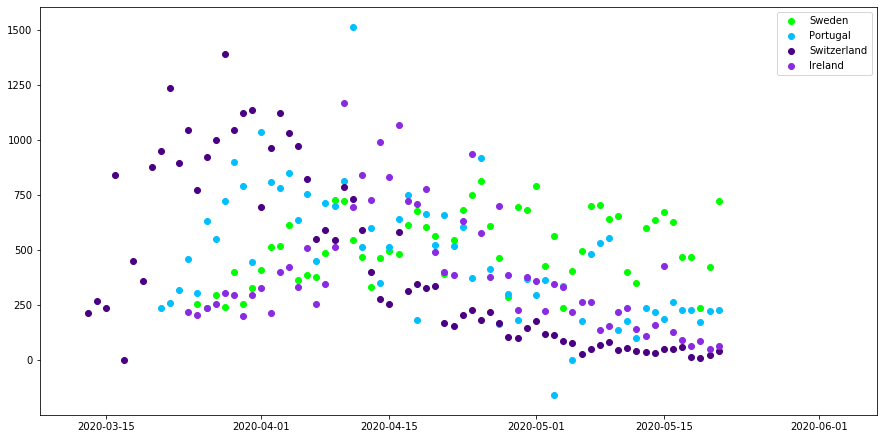

In [991]:
scatterSimilar(new_classes[5])

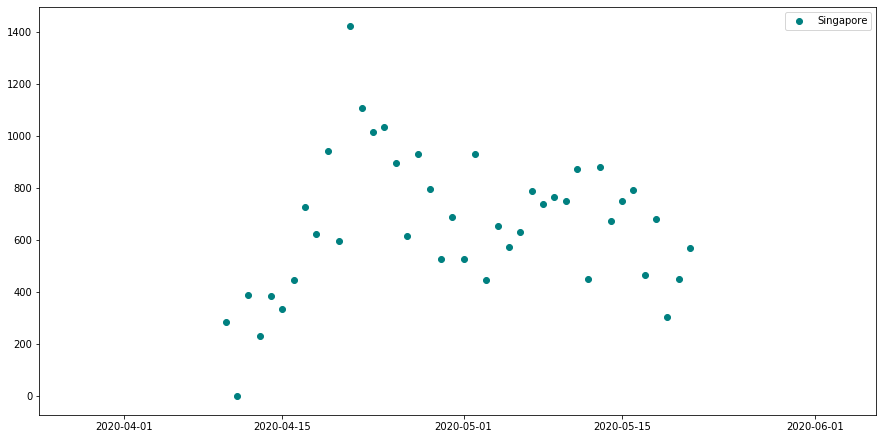

In [996]:
scatterSimilar(['Singapore'])

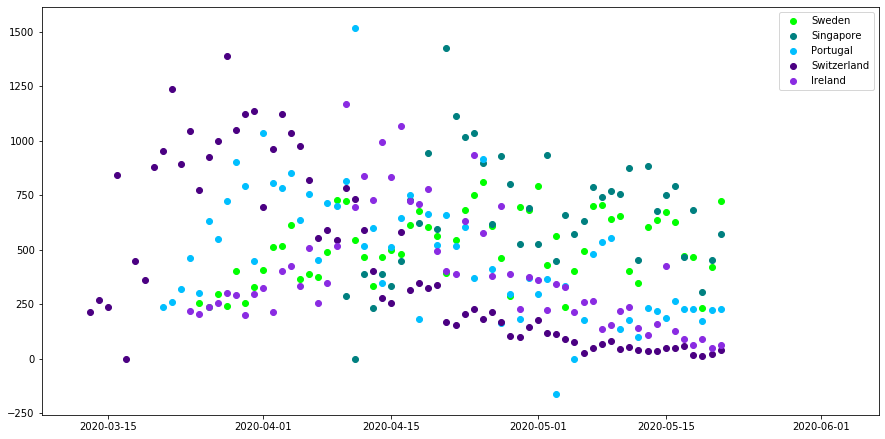

In [994]:
scatterSimilar(Union(new_classes[5],['Singapore']))

MODELLO DI REGRESSIONE DELLA CLASSE APPOSITA

In [1119]:
test=filtered_new_cases.transpose()[Union(new_classes[5],['Singapore'])]
test=test.transpose()
test=test[range(0,50)]
test=test.transpose()
print(test)

    Sweden  Singapore  Portugal  Switzerland  Ireland
0    256.0      286.0     235.0        212.0    219.0
1    238.0        0.0     260.0        267.0    204.0
2    296.0      390.0     320.0        238.0    235.0
3    240.0      233.0     460.0        841.0    255.0
4    401.0      386.0     302.0          0.0    302.0
5    253.0      334.0     633.0        450.0    294.0
6    328.0      447.0     549.0        360.0    200.0
7    407.0      728.0     724.0        878.0    295.0
8    512.0      623.0     902.0        952.0    325.0
9    519.0      942.0     792.0       1237.0    212.0
10   612.0      596.0     446.0        894.0    402.0
11   365.0     1426.0    1035.0       1044.0    424.0
12   387.0     1111.0     808.0        774.0    331.0
13   376.0     1016.0     783.0        925.0    507.0
14   487.0     1037.0     852.0       1000.0    253.0
15   726.0      897.0     638.0       1390.0    345.0
16   722.0      618.0     754.0       1048.0    515.0
17   544.0      931.0     45

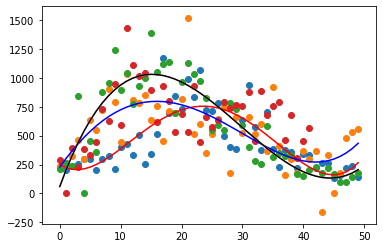

In [1125]:
poly_features=PolynomialFeatures(degree=4,include_bias=False)
x_poly=poly_features.fit_transform(np.array(test.index).reshape(-1, 1))


linear_reg=LinearRegression()


linear_reg.fit(x_poly,test['Ireland'])


predI = linear_reg.predict(x_poly)






plt.scatter(test.index,test['Ireland'])
plt.plot(predI,color='red')
linear_reg.fit(x_poly,test['Portugal'])
predI = linear_reg.predict(x_poly)
plt.scatter(test.index,test['Portugal'])
plt.plot(predI,color='Blue')
linear_reg.fit(x_poly,test['Sweden'])
predI = linear_reg.predict(x_poly)

linear_reg.fit(x_poly,test['Switzerland'])
predI = linear_reg.predict(x_poly)
plt.scatter(test.index,test['Switzerland'])
plt.plot(predI,color='pink')
linear_reg.fit(x_poly,test['Switzerland'])
predI = linear_reg.predict(x_poly)
plt.scatter(test.index,test['Singapore'])
plt.plot(predI,color='black')


In [ ]:
predI = linear_reg.predict(x_poly)
plt.scatter(test.index,test['Switzerland'])
plt.plot(predI,color='pink')